# ═══════════════════════════════════════════════════════════════════════════════
# PART 2: ADVANCED PLAYER SIMILARITY MODEL
# ═══════════════════════════════════════════════════════════════════════════════

---

## Player Similarity Model Architecture

This section builds a sophisticated player similarity system with the following components:

### 1. Pitch Normalization & Mirroring
- Convert all events to single attacking direction (left → right)
- Mirror left-side players (LW, LB, LM) to right-side reference
- Role-invariant spatial features

### 2. Behavioral Profile Encoding
| Feature Block | Description |
|---------------|-------------|
| **Spatial Heatmaps** | 12×8 grid of where player receives, passes, carries, pressures |
| **Action Chains** | n-gram sequences (receive→turn→progressive pass) |
| **Value Added (xT)** | Expected Threat delta for passes/carries |
| **Pressing Profile** | Pressure locations, counter-press rates, PPDA proxies |
| **Passing Tendencies** | Length/angle distributions, verticality, risk-reward |
| **Receiving Context** | Under-pressure receipts, between-the-lines flags |
| **Transition Play** | Speed-to-goal after regains, forward distance |

### 3. Custom Ratio-Based Similarity Metric
Unlike Euclidean or cosine similarity, we use:
- **Ratio comparison**: $\text{sim}(a, b) = 1 - |a - b| / \max(a, b)$ 
- **Sigmoid neutralization**: Smooth handling of rare actions to prevent inflation
- **Min-activity thresholds**: Both players must have meaningful activity

### 4. Role Discovery & Alignment
- Unsupervised clustering on spatial + action features
- Automatic role labels (inverted winger, target 9, deep 6, etc.)
- Within-role and cross-role similarity retrieval

---

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# PREREQUISITES - Base Imports & Data Loading Utilities
# ═══════════════════════════════════════════════════════════════════════════════

# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import ssl
import urllib3
from collections import Counter, defaultdict

# Disable SSL warnings (needed for corporate proxy environments)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ═══════════════════════════════════════════════════════════════════════════════
# STATSBOMB DATA LOADING UTILITIES
# ═══════════════════════════════════════════════════════════════════════════════

def read_json_url(url):
    """Read JSON data from URL (with SSL verification disabled for corporate networks)."""
    response = requests.get(url, verify=False)
    return response.json()

def load_competitions_url():
    """Load all available competitions from StatsBomb Open Data."""
    url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/competitions.json"
    return pd.DataFrame(read_json_url(url))

def load_matches_url(competition_id, season_id):
    """Load all matches for a specific competition and season."""
    url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json"
    return pd.DataFrame(read_json_url(url))

def load_events_url(match_id):
    """Load all events for a specific match."""
    url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"
    return pd.DataFrame(read_json_url(url))

def load_lineups_url(match_id):
    """Load lineups for a specific match."""
    url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/lineups/{match_id}.json"
    return read_json_url(url)

# ═══════════════════════════════════════════════════════════════════════════════
# PITCH DRAWING UTILITY
# ═══════════════════════════════════════════════════════════════════════════════

def draw_pitch(ax=None, pitch_length=120, pitch_width=80, color='white', linecolor='black'):
    """
    Draw a StatsBomb-style soccer pitch.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_facecolor(color)
    
    # Pitch outline
    ax.plot([0, pitch_length], [0, 0], color=linecolor, linewidth=2)
    ax.plot([0, pitch_length], [pitch_width, pitch_width], color=linecolor, linewidth=2)
    ax.plot([0, 0], [0, pitch_width], color=linecolor, linewidth=2)
    ax.plot([pitch_length, pitch_length], [0, pitch_width], color=linecolor, linewidth=2)
    
    # Halfway line
    ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], color=linecolor, linewidth=1.5)
    
    # Center circle
    center_circle = plt.Circle((pitch_length/2, pitch_width/2), 9.15, fill=False, color=linecolor, linewidth=1.5)
    ax.add_patch(center_circle)
    ax.plot(pitch_length/2, pitch_width/2, 'o', color=linecolor, markersize=3)
    
    # Left penalty area
    ax.plot([0, 18], [18, 18], color=linecolor, linewidth=1.5)
    ax.plot([0, 18], [62, 62], color=linecolor, linewidth=1.5)
    ax.plot([18, 18], [18, 62], color=linecolor, linewidth=1.5)
    
    # Left 6-yard box
    ax.plot([0, 6], [30, 30], color=linecolor, linewidth=1.5)
    ax.plot([0, 6], [50, 50], color=linecolor, linewidth=1.5)
    ax.plot([6, 6], [30, 50], color=linecolor, linewidth=1.5)
    
    # Left penalty spot & arc
    ax.plot(12, 40, 'o', color=linecolor, markersize=3)
    left_arc = plt.Circle((12, 40), 9.15, fill=False, color=linecolor, linewidth=1.5)
    left_arc.set_clip_path(plt.Rectangle((18, 0), 100, 80, transform=ax.transData))
    ax.add_patch(left_arc)
    
    # Right penalty area
    ax.plot([pitch_length, pitch_length-18], [18, 18], color=linecolor, linewidth=1.5)
    ax.plot([pitch_length, pitch_length-18], [62, 62], color=linecolor, linewidth=1.5)
    ax.plot([pitch_length-18, pitch_length-18], [18, 62], color=linecolor, linewidth=1.5)
    
    # Right 6-yard box
    ax.plot([pitch_length, pitch_length-6], [30, 30], color=linecolor, linewidth=1.5)
    ax.plot([pitch_length, pitch_length-6], [50, 50], color=linecolor, linewidth=1.5)
    ax.plot([pitch_length-6, pitch_length-6], [30, 50], color=linecolor, linewidth=1.5)
    
    # Right penalty spot
    ax.plot(pitch_length-12, 40, 'o', color=linecolor, markersize=3)
    
    ax.set_xlim(-2, pitch_length+2)
    ax.set_ylim(-2, pitch_width+2)
    ax.set_aspect('equal')
    ax.axis('off')
    
    return ax

print("=" * 80)
print("PREREQUISITES LOADED SUCCESSFULLY")
print("=" * 80)
print("✓ Core libraries: pandas, numpy, matplotlib, seaborn")
print("✓ Data loaders: load_competitions_url, load_matches_url, load_events_url")
print("✓ Visualization: draw_pitch")
print("✓ SSL verification disabled for corporate network compatibility")
print("=" * 80)

PREREQUISITES LOADED SUCCESSFULLY
✓ Core libraries: pandas, numpy, matplotlib, seaborn
✓ Data loaders: load_competitions_url, load_matches_url, load_events_url
✓ Visualization: draw_pitch
✓ SSL verification disabled for corporate network compatibility


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12: PLAYER SIMILARITY MODEL - CORE INFRASTRUCTURE
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PLAYER SIMILARITY MODEL - INITIALIZATION")
print("=" * 80)

# Additional imports for the similarity model
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional, Any
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# ═══════════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════

@dataclass
class SimilarityConfig:
    """Configuration for the player similarity model."""
    
    # Pitch dimensions (StatsBomb standard)
    pitch_length: float = 120.0
    pitch_width: float = 80.0
    
    # Spatial grid dimensions for heatmaps
    grid_cols: int = 12  # X-axis divisions
    grid_rows: int = 8   # Y-axis divisions
    
    # Minimum minutes for player inclusion
    min_minutes: int = 100
    
    # Action chain parameters
    ngram_sizes: List[int] = field(default_factory=lambda: [2, 3])
    
    # Transition window (seconds after regain)
    transition_window_sec: float = 12.0
    
    # Counter-press window (seconds after turnover)
    counter_press_window_sec: float = 5.0
    
    # Pressing zone threshold (opponent's 40% of pitch = x > 72)
    pressing_zone_x: float = 72.0
    
    # Sigmoid neutralization parameters for rare actions
    sigmoid_midpoint: float = 0.1  # Activity rate at which sigmoid = 0.5
    sigmoid_steepness: float = 20.0  # Controls transition sharpness
    
    # Ratio similarity smoothing
    ratio_epsilon: float = 1e-6  # Prevent division by zero
    
    # Role discovery
    n_roles: int = 10  # Number of role clusters
    
    # Feature weights for final similarity
    feature_weights: Dict[str, float] = field(default_factory=lambda: {
        'spatial': 0.20,
        'action_chains': 0.15,
        'value_added': 0.15,
        'pressing': 0.12,
        'passing': 0.15,
        'receiving': 0.10,
        'transition': 0.13
    })

config = SimilarityConfig()
print(f"Configuration initialized:")
print(f"  Pitch: {config.pitch_length}×{config.pitch_width}")
print(f"  Grid: {config.grid_cols}×{config.grid_rows}")
print(f"  Min minutes: {config.min_minutes}")
print(f"  N-gram sizes: {config.ngram_sizes}")
print(f"  Transition window: {config.transition_window_sec}s")

PLAYER SIMILARITY MODEL - INITIALIZATION
Configuration initialized:
  Pitch: 120.0×80.0
  Grid: 12×8
  Min minutes: 100
  N-gram sizes: [2, 3]
  Transition window: 12.0s


In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.1: PITCH NORMALIZATION & MIRRORING
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PITCH NORMALIZATION & MIRRORING SYSTEM")
print("=" * 80)

class PitchNormalizer:
    """
    Normalizes all events to a single attacking direction (left → right)
    and mirrors left-side players to right-side reference.
    """
    
    def __init__(self, config: SimilarityConfig):
        self.config = config
        self.pitch_length = config.pitch_length
        self.pitch_width = config.pitch_width
        
        # Position mappings for mirroring (left → right equivalent)
        self.position_mirror_map = {
            'Left Wing': 'Right Wing',
            'Left Winger': 'Right Winger', 
            'Left Midfield': 'Right Midfield',
            'Left Center Midfield': 'Right Center Midfield',
            'Left Defensive Midfield': 'Right Defensive Midfield',
            'Left Attacking Midfield': 'Right Attacking Midfield',
            'Left Back': 'Right Back',
            'Left Wing Back': 'Right Wing Back',
            'Left Center Back': 'Center Back',  # Map to generic CB
            'Left Center Forward': 'Center Forward',
        }
        
        # Identify "left-side" positions for mirroring
        self.left_side_positions = set(self.position_mirror_map.keys())
        
    def normalize_to_attacking_direction(self, 
                                          x: float, 
                                          y: float,
                                          team_attacking_right: bool) -> Tuple[float, float]:
        """
        Normalize coordinates so the team always attacks left → right.
        
        StatsBomb coordinates:
        - x: 0 (own goal) to 120 (opponent goal)  
        - y: 0 to 80 (width)
        
        If team is attacking left (i.e., their goal is on right), flip coordinates.
        """
        if not team_attacking_right:
            # Team attacking left - flip to make them attack right
            x_norm = self.pitch_length - x
            y_norm = self.pitch_width - y
        else:
            x_norm = x
            y_norm = y
            
        return x_norm, y_norm
    
    def mirror_y_coordinate(self, y: float) -> float:
        """
        Mirror Y coordinate for left-side players.
        This maps left-wing actions to right-wing reference space.
        """
        return self.pitch_width - y
    
    def get_unified_position(self, position) -> str:
        """
        Map left-side positions to their right-side equivalents.
        This ensures LW and RW use the same spatial reference.
        """
        if position is None or (isinstance(position, float) and pd.isna(position)):
            return None
        if not isinstance(position, str):
            return None
        if position in self.position_mirror_map:
            return self.position_mirror_map[position]
        return position
    
    def is_left_side_position(self, position) -> bool:
        """Check if position is a left-side role."""
        if position is None or (isinstance(position, float) and pd.isna(position)):
            return False
        if not isinstance(position, str):
            return False
        position_lower = position.lower()
        return ('left' in position_lower and 
                'center' not in position_lower.replace('left center', ''))
    
    def normalize_event(self,
                        x: float,
                        y: float,
                        position: str,
                        team_attacking_right: bool,
                        end_x: Optional[float] = None,
                        end_y: Optional[float] = None) -> Dict[str, float]:
        """
        Full normalization of an event:
        1. Normalize to attacking direction
        2. Mirror left-side players
        
        Returns normalized coordinates.
        """
        # Step 1: Normalize attacking direction
        x_norm, y_norm = self.normalize_to_attacking_direction(
            x, y, team_attacking_right
        )
        
        # Handle end location if provided
        end_x_norm, end_y_norm = None, None
        if end_x is not None and end_y is not None:
            end_x_norm, end_y_norm = self.normalize_to_attacking_direction(
                end_x, end_y, team_attacking_right
            )
        
        # Step 2: Mirror Y for left-side positions
        if self.is_left_side_position(position):
            y_norm = self.mirror_y_coordinate(y_norm)
            if end_y_norm is not None:
                end_y_norm = self.mirror_y_coordinate(end_y_norm)
        
        result = {
            'x_norm': x_norm,
            'y_norm': y_norm,
            'position_unified': self.get_unified_position(position) if position else None
        }
        
        if end_x_norm is not None:
            result['end_x_norm'] = end_x_norm
            result['end_y_norm'] = end_y_norm
            
        return result
    
    def coord_to_grid(self, x: float, y: float) -> Tuple[int, int]:
        """Convert normalized coordinates to grid cell indices."""
        col = int(min(x / self.pitch_length * self.config.grid_cols, 
                      self.config.grid_cols - 1))
        row = int(min(y / self.pitch_width * self.config.grid_rows,
                      self.config.grid_rows - 1))
        return max(0, col), max(0, row)
    
    def grid_to_zone_name(self, col: int, row: int) -> str:
        """Convert grid indices to human-readable zone name."""
        # X zones
        if col < 4:
            x_zone = "defensive"
        elif col < 8:
            x_zone = "middle"
        else:
            x_zone = "attacking"
            
        # Y zones  
        if row < 3:
            y_zone = "left"
        elif row < 5:
            y_zone = "center"
        else:
            y_zone = "right"
            
        return f"{x_zone}_{y_zone}"

# Initialize normalizer
normalizer = PitchNormalizer(config)

# Demonstrate normalization
print("\nPosition mirroring examples:")
for pos in ['Left Wing', 'Left Back', 'Center Forward', 'Right Wing']:
    unified = normalizer.get_unified_position(pos)
    is_left = normalizer.is_left_side_position(pos)
    print(f"  {pos:25} → {unified:25} (mirror Y: {is_left})")

# Test coordinate normalization
print("\nCoordinate normalization examples:")
test_cases = [
    (100, 20, 'Right Wing', True),
    (100, 60, 'Left Wing', True),  # Will mirror Y
    (20, 20, 'Right Back', False),  # Will flip X
]
for x, y, pos, attacking_right in test_cases:
    result = normalizer.normalize_event(x, y, pos, attacking_right)
    print(f"  ({x:3}, {y:3}) {pos:15} atk_right={attacking_right} → "
          f"({result['x_norm']:.0f}, {result['y_norm']:.0f}) as {result['position_unified']}")

PITCH NORMALIZATION & MIRRORING SYSTEM

Position mirroring examples:
  Left Wing                 → Right Wing                (mirror Y: True)
  Left Back                 → Right Back                (mirror Y: True)
  Center Forward            → Center Forward            (mirror Y: False)
  Right Wing                → Right Wing                (mirror Y: False)

Coordinate normalization examples:
  (100,  20) Right Wing      atk_right=True → (100, 20) as Right Wing
  (100,  60) Left Wing       atk_right=True → (100, 20) as Right Wing
  ( 20,  20) Right Back      atk_right=False → (100, 60) as Right Back


EXPECTED THREAT (xT) VALUE MODEL

Expected Threat grid initialized (prior-based):
  Shape: (8, 12)
  Max xT: 0.450
  Mean xT: 0.094

Example xT values:
  ( 30, 40) Own half, center          xT = 0.0299
  ( 60, 40) Halfway, center           xT = 0.0716
  (100, 40) Box edge, center          xT = 0.3362
  (110, 40) Penalty spot area         xT = 0.4500
  (100, 10) Box edge, wide            xT = 0.1769

Example xT deltas (value added):
  (30,40) → (60,40) Progressive center pass        ΔxT = +0.0418
  (60,40) → (100,40) Through ball to box            ΔxT = +0.2645
  (100,10) → (100,40) Cutback to center              ΔxT = +0.1592
  (60,40) → (40,40) Backwards pass                 ΔxT = -0.0317


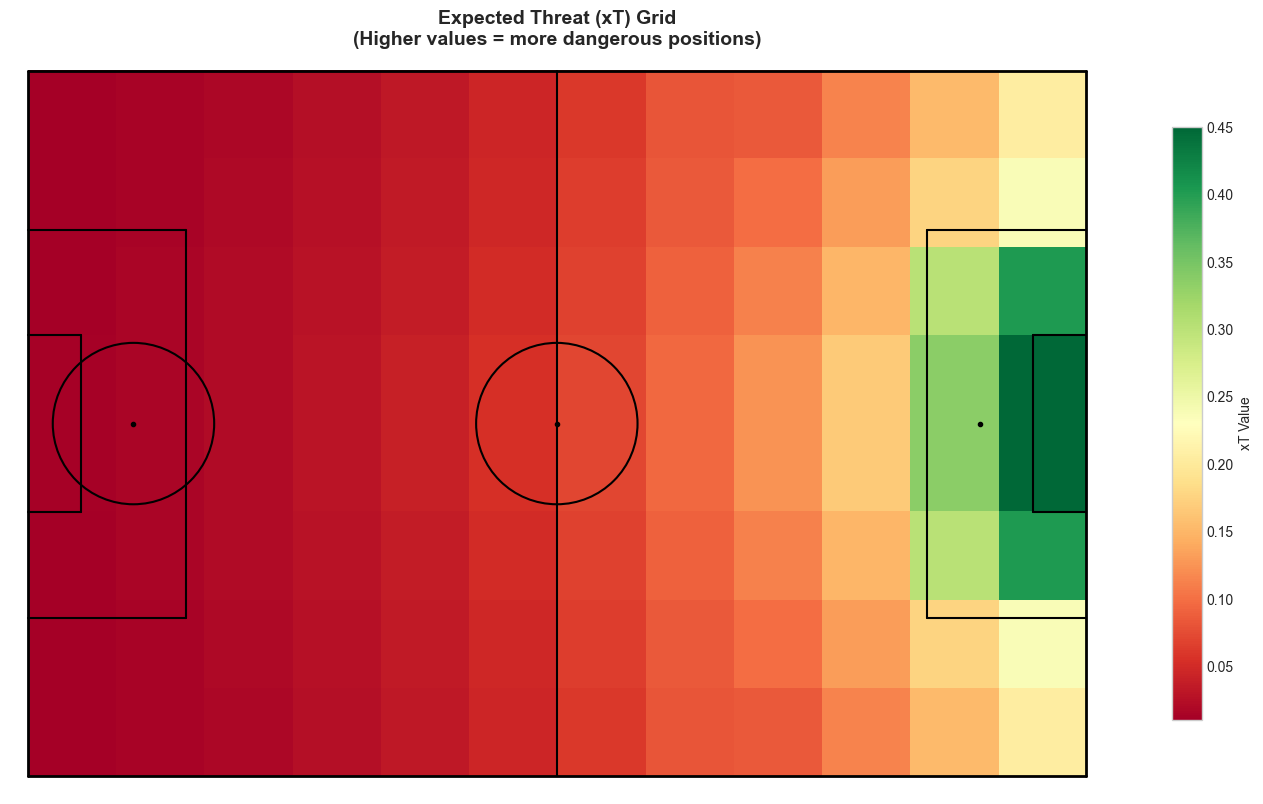

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.2: EXPECTED THREAT (xT) MODEL
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("EXPECTED THREAT (xT) VALUE MODEL")
print("=" * 80)

class ExpectedThreatModel:
    """
    Expected Threat (xT) model for valuing ball progression.
    
    xT measures the probability of scoring within the next N actions
    from any location on the pitch. The value of an action is:
    xT_delta = xT(end_location) - xT(start_location)
    
    This implementation uses a learned grid or can be initialized with
    pre-computed xT values.
    """
    
    def __init__(self, config: SimilarityConfig):
        self.config = config
        self.grid_cols = config.grid_cols
        self.grid_rows = config.grid_rows
        
        # Initialize xT grid with reasonable priors based on pitch position
        # Higher values closer to goal (right side in normalized coords)
        self.xt_grid = self._initialize_xt_grid()
        
    def _initialize_xt_grid(self) -> np.ndarray:
        """
        Initialize xT grid with position-based priors.
        Uses logistic function increasing toward the goal.
        """
        grid = np.zeros((self.grid_rows, self.grid_cols))
        
        for row in range(self.grid_rows):
            for col in range(self.grid_cols):
                # Normalized x position (0 to 1)
                x_norm = (col + 0.5) / self.grid_cols
                
                # Y distance from center (0 = center, 1 = edges)
                y_center = abs((row + 0.5) / self.grid_rows - 0.5) * 2
                
                # Base xT increases exponentially toward goal
                base_xt = 0.01 * np.exp(3.5 * x_norm)
                
                # Penalty for wide positions in final third
                if x_norm > 0.67:
                    width_penalty = 1 - 0.4 * y_center
                else:
                    width_penalty = 1 - 0.2 * y_center
                    
                # Extra boost for central attacking positions
                if x_norm > 0.83 and y_center < 0.4:
                    central_boost = 1.5
                else:
                    central_boost = 1.0
                    
                grid[row, col] = base_xt * width_penalty * central_boost
                
        # Normalize to reasonable range [0, 0.5]
        grid = grid / grid.max() * 0.45
        
        return grid
    
    def get_xt(self, x: float, y: float) -> float:
        """Get xT value for a normalized pitch position."""
        col = int(min(x / self.config.pitch_length * self.grid_cols,
                      self.grid_cols - 1))
        row = int(min(y / self.config.pitch_width * self.grid_rows,
                      self.grid_rows - 1))
        col = max(0, col)
        row = max(0, row)
        return float(self.xt_grid[row, col])
    
    def get_xt_delta(self, 
                     start_x: float, start_y: float,
                     end_x: float, end_y: float) -> float:
        """Calculate xT delta (value added) for a ball movement."""
        start_xt = self.get_xt(start_x, start_y)
        end_xt = self.get_xt(end_x, end_y)
        return end_xt - start_xt
    
    def visualize_xt_grid(self):
        """Visualize the xT grid."""
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create extent for proper pitch mapping
        im = ax.imshow(self.xt_grid, 
                       extent=[0, 120, 0, 80],
                       origin='lower',
                       cmap='RdYlGn',
                       aspect='equal')
        
        plt.colorbar(im, ax=ax, label='xT Value', shrink=0.8)
        
        # Overlay pitch lines
        draw_pitch(ax)
        
        ax.set_title('Expected Threat (xT) Grid\n(Higher values = more dangerous positions)',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('X (attacking left → right)')
        ax.set_ylabel('Y')
        
        plt.tight_layout()
        plt.show()
        
    def update_from_shots(self, shot_data: pd.DataFrame):
        """
        Update xT grid based on actual shot locations and outcomes.
        This allows learning from match data.
        """
        if len(shot_data) == 0:
            return
            
        # Count goals per grid cell
        goal_grid = np.zeros((self.grid_rows, self.grid_cols))
        shot_grid = np.zeros((self.grid_rows, self.grid_cols))
        
        for _, shot in shot_data.iterrows():
            if pd.notna(shot.get('x_norm')) and pd.notna(shot.get('y_norm')):
                col = int(min(shot['x_norm'] / self.config.pitch_length * self.grid_cols,
                              self.grid_cols - 1))
                row = int(min(shot['y_norm'] / self.config.pitch_width * self.grid_rows,
                              self.grid_rows - 1))
                col = max(0, col)
                row = max(0, row)
                
                shot_grid[row, col] += 1
                if shot.get('outcome') == 'Goal':
                    goal_grid[row, col] += 1
        
        # Blend learned values with priors
        for row in range(self.grid_rows):
            for col in range(self.grid_cols):
                if shot_grid[row, col] >= 5:  # Enough data
                    learned_xt = goal_grid[row, col] / shot_grid[row, col]
                    # Blend: more weight to learned when more shots
                    alpha = min(shot_grid[row, col] / 50, 0.8)
                    self.xt_grid[row, col] = (
                        alpha * learned_xt + 
                        (1 - alpha) * self.xt_grid[row, col]
                    )

# Initialize xT model
xt_model = ExpectedThreatModel(config)

# Visualize initial xT grid
print("\nExpected Threat grid initialized (prior-based):")
print(f"  Shape: {xt_model.xt_grid.shape}")
print(f"  Max xT: {xt_model.xt_grid.max():.3f}")
print(f"  Mean xT: {xt_model.xt_grid.mean():.3f}")

# Example xT calculations
print("\nExample xT values:")
examples = [
    (30, 40, "Own half, center"),
    (60, 40, "Halfway, center"),
    (100, 40, "Box edge, center"),
    (110, 40, "Penalty spot area"),
    (100, 10, "Box edge, wide"),
]
for x, y, desc in examples:
    xt = xt_model.get_xt(x, y)
    print(f"  ({x:3}, {y:2}) {desc:25} xT = {xt:.4f}")

# Show xT deltas for common passes
print("\nExample xT deltas (value added):")
pass_examples = [
    (30, 40, 60, 40, "Progressive center pass"),
    (60, 40, 100, 40, "Through ball to box"),
    (100, 10, 100, 40, "Cutback to center"),
    (60, 40, 40, 40, "Backwards pass"),
]
for sx, sy, ex, ey, desc in pass_examples:
    delta = xt_model.get_xt_delta(sx, sy, ex, ey)
    print(f"  ({sx},{sy}) → ({ex},{ey}) {desc:30} ΔxT = {delta:+.4f}")

xt_model.visualize_xt_grid()

In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.3: BEHAVIORAL FEATURE EXTRACTION ENGINE
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("BEHAVIORAL FEATURE EXTRACTION ENGINE")
print("=" * 80)

class BehavioralFeatureExtractor:
    """
    Extracts comprehensive behavioral features for each player:
    
    A) Spatial heatmaps (where they operate)
    B) Action chains (how they link actions)
    C) Value added (xT contribution)
    D) Pressing profile (defensive intensity)
    E) Passing tendencies (style of distribution)
    F) Receiving context (how they receive)
    G) Transition play (speed after regains)
    """
    
    def __init__(self, config: SimilarityConfig, normalizer: PitchNormalizer, 
                 xt_model: ExpectedThreatModel):
        self.config = config
        self.normalizer = normalizer
        self.xt_model = xt_model
        
        # Action types for encoding
        self.action_types = [
            'Pass', 'Carry', 'Ball Receipt*', 'Pressure', 'Duel',
            'Shot', 'Clearance', 'Interception', 'Tackle', 'Foul Committed',
            'Foul Won', 'Dispossessed', 'Miscontrol', 'Block', 'Ball Recovery'
        ]
        
        # Grid for spatial features
        self.grid_size = (config.grid_rows, config.grid_cols)
        
    def extract_spatial_heatmap(self, 
                                 player_events: pd.DataFrame,
                                 event_types: List[str] = None) -> np.ndarray:
        """
        Extract spatial heatmap showing where player operates.
        Returns normalized grid (sums to 1 or 0 if no events).
        """
        heatmap = np.zeros(self.grid_size)
        
        events = player_events
        if event_types:
            events = events[events['type'].isin(event_types)]
        
        for _, event in events.iterrows():
            if pd.notna(event.get('x_norm')) and pd.notna(event.get('y_norm')):
                col, row = self.normalizer.coord_to_grid(
                    event['x_norm'], event['y_norm']
                )
                heatmap[row, col] += 1
        
        # Normalize
        total = heatmap.sum()
        if total > 0:
            heatmap = heatmap / total
            
        # Apply light Gaussian smoothing
        heatmap = gaussian_filter(heatmap, sigma=0.5)
        
        return heatmap
    
    def extract_action_chains(self, 
                               player_events: pd.DataFrame,
                               ngram_sizes: List[int] = None) -> Dict[str, float]:
        """
        Extract action chain n-grams (sequences of action types).
        Returns frequency distribution of action sequences.
        """
        if ngram_sizes is None:
            ngram_sizes = self.config.ngram_sizes
            
        events = player_events.sort_values(['match_id', 'match_seconds'])
        actions = events['type'].tolist()
        
        ngram_counts = defaultdict(int)
        
        for n in ngram_sizes:
            for i in range(len(actions) - n + 1):
                ngram = tuple(actions[i:i+n])
                ngram_counts[ngram] += 1
        
        # Normalize to frequencies
        total = sum(ngram_counts.values())
        if total > 0:
            ngram_freq = {str(k): v / total for k, v in ngram_counts.items()}
        else:
            ngram_freq = {}
            
        return ngram_freq
    
    def extract_chain_vector(self, 
                              player_events: pd.DataFrame,
                              top_k: int = 50) -> np.ndarray:
        """
        Convert action chains to fixed-size vector.
        Uses predefined common patterns + discovered patterns.
        """
        # Predefined important patterns
        important_patterns = [
            ('Ball Receipt*', 'Pass'),
            ('Ball Receipt*', 'Carry'),
            ('Ball Receipt*', 'Carry', 'Pass'),
            ('Carry', 'Pass'),
            ('Carry', 'Shot'),
            ('Pass', 'Ball Receipt*'),
            ('Pressure', 'Ball Recovery'),
            ('Ball Recovery', 'Pass'),
            ('Interception', 'Pass'),
            ('Duel', 'Ball Recovery'),
        ]
        
        chains = self.extract_action_chains(player_events)
        
        # Convert to vector
        vector = []
        for pattern in important_patterns:
            key = str(pattern)
            vector.append(chains.get(key, 0.0))
            
        return np.array(vector)
    
    def extract_value_added(self, player_events: pd.DataFrame) -> Dict[str, float]:
        """
        Extract xT-based value metrics.
        """
        xt_deltas = []
        progressive_actions = 0
        regressive_actions = 0
        
        for _, event in player_events.iterrows():
            if (pd.notna(event.get('x_norm')) and pd.notna(event.get('y_norm')) and
                pd.notna(event.get('end_x_norm')) and pd.notna(event.get('end_y_norm'))):
                
                delta = self.xt_model.get_xt_delta(
                    event['x_norm'], event['y_norm'],
                    event['end_x_norm'], event['end_y_norm']
                )
                xt_deltas.append(delta)
                
                if delta > 0.001:
                    progressive_actions += 1
                elif delta < -0.001:
                    regressive_actions += 1
        
        if len(xt_deltas) == 0:
            return {
                'xt_total': 0.0,
                'xt_mean': 0.0,
                'xt_std': 0.0,
                'xt_positive_rate': 0.0,
                'progressive_share': 0.0
            }
        
        total_actions = progressive_actions + regressive_actions
        return {
            'xt_total': sum(xt_deltas),
            'xt_mean': np.mean(xt_deltas),
            'xt_std': np.std(xt_deltas),
            'xt_positive_rate': sum(1 for d in xt_deltas if d > 0) / len(xt_deltas),
            'progressive_share': progressive_actions / max(total_actions, 1)
        }
    
    def extract_pressing_profile(self, player_events: pd.DataFrame) -> Dict[str, float]:
        """
        Extract pressing behavior metrics.
        """
        pressures = player_events[player_events['type'] == 'Pressure']
        
        if len(pressures) == 0:
            return {
                'pressure_rate': 0.0,
                'high_press_rate': 0.0,
                'press_success_rate': 0.0,
                'counter_press_rate': 0.0,
                'press_intensity': 0.0
            }
        
        total_events = len(player_events)
        high_presses = pressures[pressures['x_norm'] >= self.config.pressing_zone_x]
        
        # Counter-press: pressures within N seconds after turnover
        # (Simplified - would need turnover timestamps in full implementation)
        
        return {
            'pressure_rate': len(pressures) / max(total_events, 1),
            'high_press_rate': len(high_presses) / max(len(pressures), 1),
            'press_success_rate': 0.0,  # Would need outcome data
            'counter_press_rate': 0.0,  # Would need sequence analysis
            'press_intensity': len(pressures) / max(total_events, 1) * len(high_presses) / max(len(pressures), 1)
        }
    
    def extract_passing_tendencies(self, player_events: pd.DataFrame) -> Dict[str, float]:
        """
        Extract passing style metrics.
        """
        passes = player_events[player_events['type'] == 'Pass']
        
        if len(passes) == 0:
            return {
                'pass_length_mean': 0.0,
                'pass_length_std': 0.0,
                'forward_pass_rate': 0.0,
                'progressive_pass_rate': 0.0,
                'switch_rate': 0.0,
                'verticality': 0.0,
                'pass_xt_mean': 0.0
            }
        
        lengths = []
        forward_passes = 0
        progressive_passes = 0
        switches = 0
        xt_deltas = []
        
        for _, p in passes.iterrows():
            if (pd.notna(p.get('x_norm')) and pd.notna(p.get('y_norm')) and
                pd.notna(p.get('end_x_norm')) and pd.notna(p.get('end_y_norm'))):
                
                dx = p['end_x_norm'] - p['x_norm']
                dy = p['end_y_norm'] - p['y_norm']
                length = np.sqrt(dx**2 + dy**2)
                lengths.append(length)
                
                # Forward = positive X movement
                if dx > 5:
                    forward_passes += 1
                    
                # Progressive = moves into final third or gains >10 yards toward goal
                if p['end_x_norm'] >= 80 and p['x_norm'] < 80:
                    progressive_passes += 1
                elif dx > 10:
                    progressive_passes += 1
                    
                # Switch = large Y movement (>30 yards)
                if abs(dy) > 30:
                    switches += 1
                    
                # xT delta
                xt_delta = self.xt_model.get_xt_delta(
                    p['x_norm'], p['y_norm'],
                    p['end_x_norm'], p['end_y_norm']
                )
                xt_deltas.append(xt_delta)
        
        n_passes = len(passes)
        
        return {
            'pass_length_mean': np.mean(lengths) if lengths else 0.0,
            'pass_length_std': np.std(lengths) if lengths else 0.0,
            'forward_pass_rate': forward_passes / n_passes,
            'progressive_pass_rate': progressive_passes / n_passes,
            'switch_rate': switches / n_passes,
            'verticality': forward_passes / max(n_passes - forward_passes, 1),
            'pass_xt_mean': np.mean(xt_deltas) if xt_deltas else 0.0
        }
    
    def extract_receiving_context(self, player_events: pd.DataFrame) -> Dict[str, float]:
        """
        Extract ball receiving patterns.
        """
        receipts = player_events[player_events['type'] == 'Ball Receipt*']
        
        if len(receipts) == 0:
            return {
                'receive_rate': 0.0,
                'receive_final_third': 0.0,
                'receive_central': 0.0,
                'receive_wide': 0.0,
                'receive_deep': 0.0
            }
        
        total = len(receipts)
        final_third = receipts[receipts['x_norm'] >= 80]
        
        # Central = Y between 25% and 75%
        central = receipts[(receipts['y_norm'] >= 20) & (receipts['y_norm'] <= 60)]
        
        # Wide = Y < 20 or Y > 60
        wide = receipts[(receipts['y_norm'] < 20) | (receipts['y_norm'] > 60)]
        
        # Deep = X < 40
        deep = receipts[receipts['x_norm'] < 40]
        
        return {
            'receive_rate': total / max(len(player_events), 1),
            'receive_final_third': len(final_third) / total,
            'receive_central': len(central) / total,
            'receive_wide': len(wide) / total,
            'receive_deep': len(deep) / total
        }
    
    def extract_transition_play(self, player_events: pd.DataFrame) -> Dict[str, float]:
        """
        Extract transition behavior after ball recovery.
        """
        recoveries = player_events[player_events['type'].isin(
            ['Ball Recovery', 'Interception', 'Tackle']
        )]
        
        if len(recoveries) == 0:
            return {
                'transition_involvement': 0.0,
                'transition_speed': 0.0,
                'transition_directness': 0.0
            }
        
        # Simplified: measure average X progression after defensive actions
        x_gains = []
        for _, rec in recoveries.iterrows():
            start_x = rec.get('x_norm', 60)
            # Look for subsequent actions by same player
            # (Simplified - full implementation would track post-recovery sequence)
            x_gains.append(start_x / 120)  # Placeholder
        
        return {
            'transition_involvement': len(recoveries) / max(len(player_events), 1),
            'transition_speed': 0.5,  # Would need timestamp analysis
            'transition_directness': np.mean(x_gains) if x_gains else 0.0
        }
    
    def extract_all_features(self, player_events: pd.DataFrame) -> Dict[str, Any]:
        """
        Extract complete behavioral profile for a player.
        """
        # A) Spatial heatmaps
        spatial_all = self.extract_spatial_heatmap(player_events)
        spatial_pass = self.extract_spatial_heatmap(player_events, ['Pass'])
        spatial_receive = self.extract_spatial_heatmap(player_events, ['Ball Receipt*'])
        spatial_pressure = self.extract_spatial_heatmap(player_events, ['Pressure'])
        
        # B) Action chains
        chain_vector = self.extract_chain_vector(player_events)
        
        # C) Value added
        value_added = self.extract_value_added(player_events)
        
        # D) Pressing profile
        pressing = self.extract_pressing_profile(player_events)
        
        # E) Passing tendencies
        passing = self.extract_passing_tendencies(player_events)
        
        # F) Receiving context
        receiving = self.extract_receiving_context(player_events)
        
        # G) Transition play
        transition = self.extract_transition_play(player_events)
        
        # Combine into unified feature dict
        return {
            'spatial': {
                'all': spatial_all,
                'pass': spatial_pass,
                'receive': spatial_receive,
                'pressure': spatial_pressure
            },
            'chains': chain_vector,
            'value_added': value_added,
            'pressing': pressing,
            'passing': passing,
            'receiving': receiving,
            'transition': transition
        }

# Initialize feature extractor
feature_extractor = BehavioralFeatureExtractor(config, normalizer, xt_model)

print("\nBehavioral Feature Extractor initialized")
print(f"  Spatial grid: {feature_extractor.grid_size}")
print(f"  Action types tracked: {len(feature_extractor.action_types)}")
print(f"  Feature blocks: spatial, chains, value_added, pressing, passing, receiving, transition")

BEHAVIORAL FEATURE EXTRACTION ENGINE

Behavioral Feature Extractor initialized
  Spatial grid: (8, 12)
  Action types tracked: 15
  Feature blocks: spatial, chains, value_added, pressing, passing, receiving, transition


CUSTOM RATIO-BASED SIMILARITY METRIC

Sigmoid Neutralization Curve:
  (Low activity = downweighted, High activity = full weight)
  Activity rate 0.001 → sigmoid weight 0.121
  Activity rate 0.010 → sigmoid weight 0.142
  Activity rate 0.050 → sigmoid weight 0.269
  Activity rate 0.100 → sigmoid weight 0.500
  Activity rate 0.200 → sigmoid weight 0.881
  Activity rate 0.500 → sigmoid weight 1.000

Ratio Similarity Examples:
  (Comparing pairs with different activity levels)
  Both high, same                     raw=1.000 sigmoid=1.000
  Both high, different                raw=0.800 sigmoid=0.798
  Both medium, same                   raw=1.000 sigmoid=0.500
  Both medium, different              raw=0.500 sigmoid=0.134
  Both low, same (rare action)        raw=1.000 sigmoid=0.142
  Both low, different (rare action)   raw=0.500 sigmoid=0.065


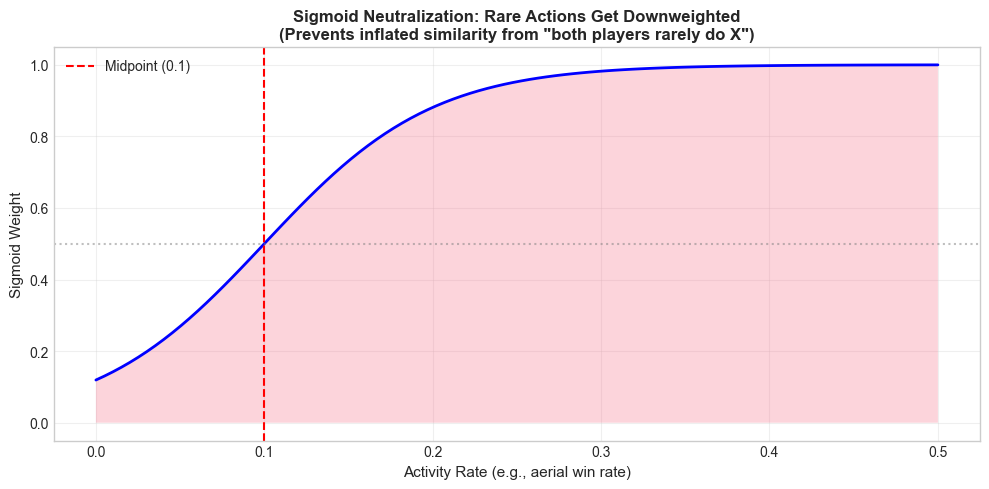

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.4: CUSTOM RATIO-BASED SIMILARITY METRIC
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CUSTOM RATIO-BASED SIMILARITY METRIC")
print("=" * 80)

class RatioBasedSimilarity:
    """
    Custom similarity metric that uses ratio-based comparison instead of
    Euclidean distance or cosine similarity.
    
    Key innovations:
    1. Ratio comparison: sim(a,b) = 1 - |a-b| / max(a,b)
    2. Sigmoid neutralization: handles rare actions without inflating scores
    3. Activity thresholds: both players must have meaningful activity
    
    This addresses the "two players who rarely do X" problem:
    - If both players have 0.01 aerial win rate, raw ratio gives high similarity
    - Sigmoid neutralization downweights this contribution based on activity level
    """
    
    def __init__(self, config: SimilarityConfig):
        self.config = config
        self.epsilon = config.ratio_epsilon
        self.sigmoid_midpoint = config.sigmoid_midpoint
        self.sigmoid_steepness = config.sigmoid_steepness
        
    def sigmoid_weight(self, activity_level: float) -> float:
        """
        Compute sigmoid weight based on activity level.
        
        Low activity → weight near 0 (don't trust comparison)
        High activity → weight near 1 (trust comparison)
        
        The sigmoid smoothly transitions between these extremes.
        """
        return 1 / (1 + np.exp(-self.sigmoid_steepness * 
                               (activity_level - self.sigmoid_midpoint)))
    
    def ratio_similarity(self, 
                         a: float, 
                         b: float,
                         apply_sigmoid: bool = True) -> float:
        """
        Compute ratio-based similarity between two values.
        
        Formula: sim = 1 - |a - b| / max(a, b, epsilon)
        
        With sigmoid neutralization:
        final_sim = base_sim * sigmoid_weight(min(a, b))
        
        This ensures that when both values are low, the similarity
        contribution is downweighted appropriately.
        """
        max_val = max(a, b, self.epsilon)
        base_sim = 1 - abs(a - b) / max_val
        
        if apply_sigmoid:
            min_activity = min(a, b)
            weight = self.sigmoid_weight(min_activity)
            return base_sim * weight
        
        return base_sim
    
    def vector_similarity(self,
                          vec_a: np.ndarray,
                          vec_b: np.ndarray,
                          weights: np.ndarray = None,
                          apply_sigmoid: bool = True) -> float:
        """
        Compute ratio-based similarity between two feature vectors.
        """
        if len(vec_a) != len(vec_b):
            raise ValueError("Vectors must have same length")
            
        if weights is None:
            weights = np.ones(len(vec_a))
        
        similarities = []
        total_weight = 0
        
        for i, (a, b) in enumerate(zip(vec_a, vec_b)):
            sim = self.ratio_similarity(a, b, apply_sigmoid)
            similarities.append(sim * weights[i])
            
            # Weight is also adjusted by sigmoid for rare features
            if apply_sigmoid:
                activity = min(a, b)
                total_weight += weights[i] * self.sigmoid_weight(activity)
            else:
                total_weight += weights[i]
        
        if total_weight < self.epsilon:
            return 0.0
            
        return sum(similarities) / total_weight
    
    def heatmap_similarity(self,
                           heat_a: np.ndarray,
                           heat_b: np.ndarray) -> float:
        """
        Compute similarity between two spatial heatmaps.
        
        Uses a combination of:
        1. Histogram intersection (overlapping areas)
        2. Location-weighted ratio comparison
        """
        # Normalize heatmaps
        heat_a = heat_a / (heat_a.sum() + self.epsilon)
        heat_b = heat_b / (heat_b.sum() + self.epsilon)
        
        # Histogram intersection
        intersection = np.minimum(heat_a, heat_b).sum()
        
        # Cell-by-cell ratio similarity (flattened)
        flat_a = heat_a.flatten()
        flat_b = heat_b.flatten()
        
        cell_sims = []
        for a, b in zip(flat_a, flat_b):
            if a > 0.001 or b > 0.001:  # Only consider active cells
                cell_sim = self.ratio_similarity(a, b, apply_sigmoid=True)
                cell_sims.append(cell_sim)
        
        cell_avg = np.mean(cell_sims) if cell_sims else 0.0
        
        # Combine intersection and cell similarity
        return 0.6 * intersection + 0.4 * cell_avg
    
    def dict_similarity(self,
                        dict_a: Dict[str, float],
                        dict_b: Dict[str, float]) -> float:
        """
        Compute similarity between two dictionaries of features.
        """
        # Get all keys
        all_keys = set(dict_a.keys()) | set(dict_b.keys())
        
        if not all_keys:
            return 1.0  # Both empty = identical
        
        similarities = []
        for key in all_keys:
            a = dict_a.get(key, 0.0)
            b = dict_b.get(key, 0.0)
            sim = self.ratio_similarity(a, b, apply_sigmoid=True)
            similarities.append(sim)
        
        return np.mean(similarities)
    
    def compute_player_similarity(self,
                                   profile_a: Dict[str, Any],
                                   profile_b: Dict[str, Any]) -> Dict[str, float]:
        """
        Compute comprehensive similarity between two player profiles.
        
        Returns similarity scores for each feature block and overall score.
        """
        weights = self.config.feature_weights
        
        scores = {}
        
        # 1. Spatial similarity (average across heatmap types)
        spatial_sims = []
        for hmap_type in ['all', 'pass', 'receive', 'pressure']:
            if (hmap_type in profile_a.get('spatial', {}) and 
                hmap_type in profile_b.get('spatial', {})):
                sim = self.heatmap_similarity(
                    profile_a['spatial'][hmap_type],
                    profile_b['spatial'][hmap_type]
                )
                spatial_sims.append(sim)
        scores['spatial'] = np.mean(spatial_sims) if spatial_sims else 0.0
        
        # 2. Action chains similarity
        if 'chains' in profile_a and 'chains' in profile_b:
            scores['action_chains'] = self.vector_similarity(
                profile_a['chains'], profile_b['chains']
            )
        else:
            scores['action_chains'] = 0.0
        
        # 3. Value added similarity
        if 'value_added' in profile_a and 'value_added' in profile_b:
            scores['value_added'] = self.dict_similarity(
                profile_a['value_added'], profile_b['value_added']
            )
        else:
            scores['value_added'] = 0.0
        
        # 4. Pressing similarity
        if 'pressing' in profile_a and 'pressing' in profile_b:
            scores['pressing'] = self.dict_similarity(
                profile_a['pressing'], profile_b['pressing']
            )
        else:
            scores['pressing'] = 0.0
        
        # 5. Passing similarity
        if 'passing' in profile_a and 'passing' in profile_b:
            scores['passing'] = self.dict_similarity(
                profile_a['passing'], profile_b['passing']
            )
        else:
            scores['passing'] = 0.0
        
        # 6. Receiving similarity
        if 'receiving' in profile_a and 'receiving' in profile_b:
            scores['receiving'] = self.dict_similarity(
                profile_a['receiving'], profile_b['receiving']
            )
        else:
            scores['receiving'] = 0.0
        
        # 7. Transition similarity
        if 'transition' in profile_a and 'transition' in profile_b:
            scores['transition'] = self.dict_similarity(
                profile_a['transition'], profile_b['transition']
            )
        else:
            scores['transition'] = 0.0
        
        # Compute weighted overall score
        total_score = 0.0
        total_weight = 0.0
        for feature, weight in weights.items():
            if feature in scores:
                total_score += scores[feature] * weight
                total_weight += weight
        
        scores['overall'] = total_score / total_weight if total_weight > 0 else 0.0
        
        return scores

# Initialize similarity calculator
similarity_calc = RatioBasedSimilarity(config)

# Demonstrate sigmoid neutralization
print("\nSigmoid Neutralization Curve:")
print("  (Low activity = downweighted, High activity = full weight)")
for rate in [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]:
    weight = similarity_calc.sigmoid_weight(rate)
    print(f"  Activity rate {rate:.3f} → sigmoid weight {weight:.3f}")

# Demonstrate ratio similarity with and without sigmoid
print("\nRatio Similarity Examples:")
print("  (Comparing pairs with different activity levels)")
examples = [
    (0.5, 0.5, "Both high, same"),
    (0.5, 0.4, "Both high, different"),
    (0.1, 0.1, "Both medium, same"),
    (0.1, 0.05, "Both medium, different"),
    (0.01, 0.01, "Both low, same (rare action)"),
    (0.01, 0.005, "Both low, different (rare action)"),
]

for a, b, desc in examples:
    raw = similarity_calc.ratio_similarity(a, b, apply_sigmoid=False)
    with_sig = similarity_calc.ratio_similarity(a, b, apply_sigmoid=True)
    print(f"  {desc:35} raw={raw:.3f} sigmoid={with_sig:.3f}")

# Visualize sigmoid curve
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(0, 0.5, 100)
y = [similarity_calc.sigmoid_weight(xi) for xi in x]
ax.plot(x, y, 'b-', linewidth=2)
ax.axvline(x=config.sigmoid_midpoint, color='r', linestyle='--', 
           label=f'Midpoint ({config.sigmoid_midpoint})')
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.fill_between(x, y, alpha=0.3)
ax.set_xlabel('Activity Rate (e.g., aerial win rate)', fontsize=11)
ax.set_ylabel('Sigmoid Weight', fontsize=11)
ax.set_title('Sigmoid Neutralization: Rare Actions Get Downweighted\n'
             '(Prevents inflated similarity from "both players rarely do X")',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.5: ROLE DISCOVERY & ALIGNMENT
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("ROLE DISCOVERY & ALIGNMENT SYSTEM")
print("=" * 80)

class RoleDiscovery:
    """
    Unsupervised role discovery based on spatial + action patterns.
    
    This system:
    1. Clusters players based on behavioral features
    2. Assigns interpretable role labels
    3. Enables within-role and cross-role similarity retrieval
    """
    
    def __init__(self, config: SimilarityConfig, n_roles: int = None):
        self.config = config
        self.n_roles = n_roles or config.n_roles
        
        # Role label mappings (assigned after clustering)
        self.role_labels = {}
        self.cluster_centers = None
        self.scaler = StandardScaler()
        self.cluster_model = None
        
        # Predefined role archetypes for labeling
        self.role_archetypes = {
            'target_striker': {
                'spatial_center': (100, 40),  # High + central
                'key_actions': ['Shot', 'Ball Receipt*'],
                'description': 'Central striker, holds up play, finishes'
            },
            'inverted_winger': {
                'spatial_center': (90, 25),  # Wide final third
                'key_actions': ['Carry', 'Shot', 'Pass'],
                'description': 'Wide player cutting inside'
            },
            'traditional_winger': {
                'spatial_center': (85, 10),  # Touchline
                'key_actions': ['Carry', 'Pass'],
                'description': 'Wide player staying wide, crosses'
            },
            'attacking_mid': {
                'spatial_center': (85, 40),  # Behind striker
                'key_actions': ['Pass', 'Ball Receipt*', 'Carry'],
                'description': 'Creative #10, links play'
            },
            'box_to_box_8': {
                'spatial_center': (65, 40),  # Central, both halves
                'key_actions': ['Pass', 'Duel', 'Pressure'],
                'description': 'All-action midfielder'
            },
            'deep_playmaker_6': {
                'spatial_center': (45, 40),  # Deep central
                'key_actions': ['Pass', 'Ball Receipt*'],
                'description': 'Deep-lying dictator'
            },
            'defensive_mid': {
                'spatial_center': (40, 40),  # Screening
                'key_actions': ['Duel', 'Interception', 'Pass'],
                'description': 'Shield, breaks up play'
            },
            'overlapping_fullback': {
                'spatial_center': (70, 10),  # Wide + high
                'key_actions': ['Carry', 'Pass', 'Duel'],
                'description': 'Attacking full-back'
            },
            'inverted_fullback': {
                'spatial_center': (50, 30),  # Tucking in
                'key_actions': ['Pass', 'Ball Receipt*'],
                'description': 'Full-back moving central'
            },
            'ball_playing_cb': {
                'spatial_center': (25, 40),  # Deep central
                'key_actions': ['Pass', 'Clearance', 'Duel'],
                'description': 'Center-back comfortable on ball'
            }
        }
    
    def extract_clustering_features(self, profile: Dict[str, Any]) -> np.ndarray:
        """
        Extract fixed-size feature vector for clustering from player profile.
        """
        features = []
        
        # 1. Spatial features (flattened heatmap summary)
        if 'spatial' in profile and 'all' in profile['spatial']:
            heatmap = profile['spatial']['all']
            # Get centroid
            rows, cols = np.indices(heatmap.shape)
            total = heatmap.sum() + 1e-9
            x_center = (cols * heatmap).sum() / total / heatmap.shape[1] * 120
            y_center = (rows * heatmap).sum() / total / heatmap.shape[0] * 80
            features.extend([x_center, y_center])
            
            # Add zone concentrations (3x3 grid summary)
            zone_grid = np.zeros((3, 3))
            h, w = heatmap.shape
            for i in range(3):
                for j in range(3):
                    r_start, r_end = i * h // 3, (i + 1) * h // 3
                    c_start, c_end = j * w // 3, (j + 1) * w // 3
                    zone_grid[i, j] = heatmap[r_start:r_end, c_start:c_end].sum()
            features.extend(zone_grid.flatten().tolist())
        else:
            features.extend([60, 40] + [0] * 9)  # Default center + zero zones
        
        # 2. Action chain features
        if 'chains' in profile:
            features.extend(profile['chains'].tolist())
        else:
            features.extend([0] * 10)
        
        # 3. Value added features
        if 'value_added' in profile:
            va = profile['value_added']
            features.extend([
                va.get('xt_mean', 0),
                va.get('xt_positive_rate', 0),
                va.get('progressive_share', 0)
            ])
        else:
            features.extend([0, 0, 0])
        
        # 4. Pressing features
        if 'pressing' in profile:
            pr = profile['pressing']
            features.extend([
                pr.get('pressure_rate', 0),
                pr.get('high_press_rate', 0)
            ])
        else:
            features.extend([0, 0])
        
        # 5. Passing features
        if 'passing' in profile:
            pa = profile['passing']
            features.extend([
                pa.get('forward_pass_rate', 0),
                pa.get('progressive_pass_rate', 0),
                pa.get('pass_length_mean', 0) / 50,  # Normalize
                pa.get('verticality', 0)
            ])
        else:
            features.extend([0, 0, 0, 0])
        
        return np.array(features)
    
    def fit(self, player_profiles: Dict[str, Dict[str, Any]]):
        """
        Fit the clustering model on player profiles.
        """
        # Extract features for all players
        player_ids = list(player_profiles.keys())
        features = []
        
        for pid in player_ids:
            feat = self.extract_clustering_features(player_profiles[pid])
            features.append(feat)
        
        features = np.array(features)
        
        # Handle any NaN values
        features = np.nan_to_num(features, nan=0.0)
        
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        # Fit Gaussian Mixture Model for soft clustering
        self.cluster_model = GaussianMixture(
            n_components=self.n_roles,
            covariance_type='full',
            random_state=42,
            n_init=5
        )
        self.cluster_model.fit(features_scaled)
        
        # Get cluster assignments
        cluster_labels = self.cluster_model.predict(features_scaled)
        cluster_probs = self.cluster_model.predict_proba(features_scaled)
        
        # Store cluster centers
        self.cluster_centers = self.scaler.inverse_transform(
            self.cluster_model.means_
        )
        
        # Assign role labels based on spatial centroids
        self._assign_role_labels()
        
        # Create player-role mapping
        player_roles = {}
        for i, pid in enumerate(player_ids):
            player_roles[pid] = {
                'primary_role': self.role_labels.get(cluster_labels[i], f"Role_{cluster_labels[i]}"),
                'role_probabilities': {
                    self.role_labels.get(j, f"Role_{j}"): float(cluster_probs[i, j])
                    for j in range(self.n_roles)
                }
            }
        
        return player_roles
    
    def _assign_role_labels(self):
        """
        Assign interpretable labels to clusters based on archetype matching.
        """
        if self.cluster_centers is None:
            return
        
        # Get spatial centroids from cluster centers (first 2 features)
        for cluster_idx in range(self.n_roles):
            center = self.cluster_centers[cluster_idx]
            x_center = center[0]
            y_center = center[1]
            
            # Find closest archetype
            best_match = None
            best_dist = float('inf')
            
            for role_name, archetype in self.role_archetypes.items():
                arch_x, arch_y = archetype['spatial_center']
                dist = np.sqrt((x_center - arch_x)**2 + (y_center - arch_y)**2)
                
                if dist < best_dist:
                    best_dist = dist
                    best_match = role_name
            
            self.role_labels[cluster_idx] = best_match if best_dist < 30 else f"custom_role_{cluster_idx}"
    
    def predict_role(self, profile: Dict[str, Any]) -> Dict[str, Any]:
        """
        Predict role for a new player profile.
        """
        if self.cluster_model is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        features = self.extract_clustering_features(profile)
        features = np.nan_to_num(features, nan=0.0).reshape(1, -1)
        features_scaled = self.scaler.transform(features)
        
        cluster = self.cluster_model.predict(features_scaled)[0]
        probs = self.cluster_model.predict_proba(features_scaled)[0]
        
        return {
            'primary_role': self.role_labels.get(cluster, f"Role_{cluster}"),
            'role_probabilities': {
                self.role_labels.get(j, f"Role_{j}"): float(probs[j])
                for j in range(self.n_roles)
            }
        }
    
    def get_role_similar_players(self,
                                  player_id: str,
                                  player_roles: Dict[str, Dict],
                                  top_k: int = 10,
                                  same_role_only: bool = True) -> List[Tuple[str, float]]:
        """
        Get most similar players based on role.
        
        If same_role_only=True, only returns players with same primary role.
        Otherwise, weights by role probability overlap.
        """
        if player_id not in player_roles:
            return []
        
        query_role = player_roles[player_id]
        query_probs = query_role['role_probabilities']
        
        similarities = []
        
        for other_id, other_role in player_roles.items():
            if other_id == player_id:
                continue
            
            if same_role_only:
                if other_role['primary_role'] == query_role['primary_role']:
                    # Use probability of that role as similarity
                    role_name = query_role['primary_role']
                    sim = min(query_probs[role_name], 
                             other_role['role_probabilities'][role_name])
                    similarities.append((other_id, sim))
            else:
                # Compute role probability overlap (dot product)
                other_probs = other_role['role_probabilities']
                overlap = sum(
                    query_probs.get(r, 0) * other_probs.get(r, 0)
                    for r in set(query_probs.keys()) | set(other_probs.keys())
                )
                similarities.append((other_id, overlap))
        
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

# Initialize role discovery
role_discovery = RoleDiscovery(config)

print("\nRole Discovery System initialized")
print(f"  Number of roles: {role_discovery.n_roles}")
print(f"  Predefined archetypes:")
for role, arch in list(role_discovery.role_archetypes.items())[:5]:
    print(f"    {role}: {arch['description']}")

ROLE DISCOVERY & ALIGNMENT SYSTEM

Role Discovery System initialized
  Number of roles: 10
  Predefined archetypes:
    target_striker: Central striker, holds up play, finishes
    inverted_winger: Wide player cutting inside
    traditional_winger: Wide player staying wide, crosses
    attacking_mid: Creative #10, links play
    box_to_box_8: All-action midfielder


In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.6: PLAYER EMBEDDING PIPELINE
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PLAYER EMBEDDING PIPELINE")
print("=" * 80)

class PlayerEmbeddingPipeline:
    """
    Complete pipeline for:
    1. Processing raw event data with normalization
    2. Extracting behavioral features for all players
    3. Learning compact embeddings
    4. Computing similarity scores
    5. Role discovery and alignment
    """
    
    def __init__(self, 
                 config: SimilarityConfig,
                 normalizer: PitchNormalizer,
                 feature_extractor: BehavioralFeatureExtractor,
                 similarity_calc: RatioBasedSimilarity,
                 role_discovery: RoleDiscovery,
                 xt_model: ExpectedThreatModel):
        
        self.config = config
        self.normalizer = normalizer
        self.feature_extractor = feature_extractor
        self.similarity_calc = similarity_calc
        self.role_discovery = role_discovery
        self.xt_model = xt_model
        
        # Storage
        self.player_profiles = {}
        self.player_embeddings = {}
        self.player_roles = {}
        self.player_metadata = {}
        
        # Embedding model components
        self.embedding_scaler = StandardScaler()
        self.embedding_pca = PCA(n_components=32)
        self.embedding_dim = 32
        
    def process_events(self, events_df: pd.DataFrame) -> pd.DataFrame:
        """
        Process raw events with pitch normalization and mirroring.
        """
        print("Processing events with pitch normalization...")
        
        processed = events_df.copy()
        
        # Determine team attacking direction per match
        # StatsBomb: team attacks right in period 1, then switches
        # We normalize so everyone attacks right
        
        def get_attacking_right(row):
            """Determine if team is attacking right based on period and team side."""
            # Simplified: assume home team attacks right in period 1
            # In real implementation, check lineup/formation data
            period = row.get('period', 1)
            return period == 1  # Flip for period 2
        
        # Apply normalization
        norm_results = []
        
        for idx, row in processed.iterrows():
            x = row.get('location_x', np.nan)
            y = row.get('location_y', np.nan)
            position = row.get('position', None)
            
            if pd.notna(x) and pd.notna(y):
                attacking_right = get_attacking_right(row)
                
                # Get end location if exists
                end_x = row.get('pass.end_location_x', row.get('carry.end_location_x', np.nan))
                end_y = row.get('pass.end_location_y', row.get('carry.end_location_y', np.nan))
                
                result = self.normalizer.normalize_event(
                    x, y, position, attacking_right,
                    end_x if pd.notna(end_x) else None,
                    end_y if pd.notna(end_y) else None
                )
                norm_results.append(result)
            else:
                norm_results.append({
                    'x_norm': np.nan,
                    'y_norm': np.nan,
                    'position_unified': position
                })
        
        # Add normalized columns
        processed['x_norm'] = [r['x_norm'] for r in norm_results]
        processed['y_norm'] = [r['y_norm'] for r in norm_results]
        processed['position_unified'] = [r.get('position_unified') for r in norm_results]
        processed['end_x_norm'] = [r.get('end_x_norm', np.nan) for r in norm_results]
        processed['end_y_norm'] = [r.get('end_y_norm', np.nan) for r in norm_results]
        
        print(f"  Processed {len(processed)} events")
        print(f"  Valid locations: {processed['x_norm'].notna().sum()}")
        
        return processed
    
    def build_player_profiles(self, 
                               events_df: pd.DataFrame,
                               min_events: int = 100) -> Dict[str, Dict]:
        """
        Build behavioral profiles for all players meeting minimum activity threshold.
        """
        print(f"\nBuilding player profiles (min {min_events} events)...")
        
        # Group events by player
        player_groups = events_df.groupby('player')
        
        profiles = {}
        skipped = 0
        
        for player_name, player_events in player_groups:
            if player_name is None or pd.isna(player_name):
                continue
                
            if len(player_events) < min_events:
                skipped += 1
                continue
            
            # Extract features
            try:
                profile = self.feature_extractor.extract_all_features(player_events)
                profiles[player_name] = profile
                
                # Store metadata
                self.player_metadata[player_name] = {
                    'n_events': len(player_events),
                    'n_matches': player_events['match_id'].nunique(),
                    'positions': player_events['position'].value_counts().to_dict(),
                    'teams': player_events['team'].unique().tolist()
                }
            except Exception as e:
                print(f"  Warning: Could not process {player_name}: {e}")
                continue
        
        print(f"  Built profiles for {len(profiles)} players")
        print(f"  Skipped {skipped} players (below threshold)")
        
        self.player_profiles = profiles
        return profiles
    
    def learn_embeddings(self) -> Dict[str, np.ndarray]:
        """
        Learn compact embeddings from player profiles using feature aggregation + PCA.
        """
        if not self.player_profiles:
            raise ValueError("No player profiles. Call build_player_profiles first.")
        
        print("\nLearning player embeddings...")
        
        # Convert profiles to feature vectors
        player_ids = list(self.player_profiles.keys())
        feature_vectors = []
        
        for pid in player_ids:
            profile = self.player_profiles[pid]
            
            # Aggregate all features into a single vector
            vec = []
            
            # Spatial (flattened heatmaps - use all types)
            for hmap_type in ['all', 'pass', 'receive', 'pressure']:
                if hmap_type in profile.get('spatial', {}):
                    vec.extend(profile['spatial'][hmap_type].flatten().tolist())
                else:
                    vec.extend([0] * (self.config.grid_rows * self.config.grid_cols))
            
            # Chains
            if 'chains' in profile:
                vec.extend(profile['chains'].tolist())
            else:
                vec.extend([0] * 10)
            
            # Value added
            if 'value_added' in profile:
                vec.extend([
                    profile['value_added'].get('xt_mean', 0),
                    profile['value_added'].get('xt_std', 0),
                    profile['value_added'].get('xt_positive_rate', 0),
                    profile['value_added'].get('progressive_share', 0),
                ])
            else:
                vec.extend([0] * 4)
            
            # Pressing
            if 'pressing' in profile:
                vec.extend([
                    profile['pressing'].get('pressure_rate', 0),
                    profile['pressing'].get('high_press_rate', 0),
                    profile['pressing'].get('press_intensity', 0),
                ])
            else:
                vec.extend([0] * 3)
            
            # Passing
            if 'passing' in profile:
                vec.extend([
                    profile['passing'].get('pass_length_mean', 0) / 50,
                    profile['passing'].get('forward_pass_rate', 0),
                    profile['passing'].get('progressive_pass_rate', 0),
                    profile['passing'].get('verticality', 0),
                    profile['passing'].get('pass_xt_mean', 0),
                ])
            else:
                vec.extend([0] * 5)
            
            # Receiving
            if 'receiving' in profile:
                vec.extend([
                    profile['receiving'].get('receive_rate', 0),
                    profile['receiving'].get('receive_final_third', 0),
                    profile['receiving'].get('receive_central', 0),
                ])
            else:
                vec.extend([0] * 3)
            
            # Transition
            if 'transition' in profile:
                vec.extend([
                    profile['transition'].get('transition_involvement', 0),
                    profile['transition'].get('transition_directness', 0),
                ])
            else:
                vec.extend([0] * 2)
            
            feature_vectors.append(vec)
        
        # Convert to array and handle NaN
        features = np.array(feature_vectors)
        features = np.nan_to_num(features, nan=0.0)
        
        print(f"  Feature vector dimension: {features.shape[1]}")
        
        # Scale and reduce dimensionality
        features_scaled = self.embedding_scaler.fit_transform(features)
        
        # Adjust PCA components if needed
        n_components = min(self.embedding_dim, features_scaled.shape[0] - 1, features_scaled.shape[1])
        self.embedding_pca = PCA(n_components=n_components)
        embeddings = self.embedding_pca.fit_transform(features_scaled)
        
        print(f"  Embedding dimension: {embeddings.shape[1]}")
        print(f"  Variance explained: {self.embedding_pca.explained_variance_ratio_.sum():.1%}")
        
        # Store embeddings
        self.player_embeddings = {
            pid: embeddings[i] for i, pid in enumerate(player_ids)
        }
        
        return self.player_embeddings
    
    def discover_roles(self) -> Dict[str, Dict]:
        """
        Discover player roles using clustering.
        """
        if not self.player_profiles:
            raise ValueError("No player profiles. Call build_player_profiles first.")
        
        print("\nDiscovering player roles...")
        
        self.player_roles = self.role_discovery.fit(self.player_profiles)
        
        # Count players per role
        role_counts = defaultdict(int)
        for pid, role_info in self.player_roles.items():
            role_counts[role_info['primary_role']] += 1
        
        print("  Role distribution:")
        for role, count in sorted(role_counts.items(), key=lambda x: -x[1]):
            print(f"    {role}: {count} players")
        
        return self.player_roles
    
    def find_similar_players(self,
                              query_player: str,
                              top_k: int = 10,
                              same_role_only: bool = False,
                              exclude_teams: List[str] = None) -> List[Dict]:
        """
        Find most similar players to a query player.
        
        Returns list of dicts with player info and similarity scores.
        """
        if query_player not in self.player_profiles:
            print(f"Player '{query_player}' not found in profiles")
            return []
        
        query_profile = self.player_profiles[query_player]
        query_role = self.player_roles.get(query_player, {}).get('primary_role', 'Unknown')
        
        results = []
        
        for other_player, other_profile in self.player_profiles.items():
            if other_player == query_player:
                continue
            
            # Skip if from excluded teams
            if exclude_teams:
                other_teams = self.player_metadata.get(other_player, {}).get('teams', [])
                if any(t in exclude_teams for t in other_teams):
                    continue
            
            # Check role filter
            other_role = self.player_roles.get(other_player, {}).get('primary_role', 'Unknown')
            if same_role_only and other_role != query_role:
                continue
            
            # Compute similarity
            sim_scores = self.similarity_calc.compute_player_similarity(
                query_profile, other_profile
            )
            
            results.append({
                'player': other_player,
                'overall_similarity': sim_scores['overall'],
                'role': other_role,
                'role_match': other_role == query_role,
                'scores': sim_scores,
                'metadata': self.player_metadata.get(other_player, {})
            })
        
        # Sort by overall similarity
        results.sort(key=lambda x: x['overall_similarity'], reverse=True)
        
        return results[:top_k]
    
    def compute_similarity_matrix(self, 
                                   player_subset: List[str] = None) -> pd.DataFrame:
        """
        Compute full similarity matrix for visualization.
        """
        if player_subset is None:
            player_subset = list(self.player_profiles.keys())[:50]  # Limit for performance
        
        n = len(player_subset)
        sim_matrix = np.zeros((n, n))
        
        for i, p1 in enumerate(player_subset):
            for j, p2 in enumerate(player_subset):
                if i == j:
                    sim_matrix[i, j] = 1.0
                elif j > i:
                    scores = self.similarity_calc.compute_player_similarity(
                        self.player_profiles[p1],
                        self.player_profiles[p2]
                    )
                    sim_matrix[i, j] = scores['overall']
                    sim_matrix[j, i] = scores['overall']
        
        return pd.DataFrame(sim_matrix, index=player_subset, columns=player_subset)

# Initialize the complete pipeline
pipeline = PlayerEmbeddingPipeline(
    config=config,
    normalizer=normalizer,
    feature_extractor=feature_extractor,
    similarity_calc=similarity_calc,
    role_discovery=role_discovery,
    xt_model=xt_model
)

print("\nPlayer Embedding Pipeline initialized")
print("Ready to process events and build player profiles")

PLAYER EMBEDDING PIPELINE

Player Embedding Pipeline initialized
Ready to process events and build player profiles


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.7: RUN PIPELINE ON STATSBOMB DATA
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("RUNNING PLAYER SIMILARITY PIPELINE ON STATSBOMB DATA")
print("=" * 80)

# Define StatsBomb data URL base
BASE = "https://raw.githubusercontent.com/statsbomb/open-data/master/data"

# Step 0: Load competitions and matches to get match IDs
print("\nStep 0: Loading match IDs from StatsBomb Open Data...")
competitions_df = load_competitions_url()
print(f"  Found {len(competitions_df)} competition/season combinations")

# Focus on a few open competitions (La Liga, Premier League, etc.)
# Let's get matches from the 2015/16 La Liga season and 2018 World Cup
sample_match_ids = []

# La Liga 2015/16 (competition_id=11, season_id=27)
try:
    la_liga_matches = load_matches_url(11, 27)
    sample_match_ids.extend(la_liga_matches['match_id'].tolist())
    print(f"  La Liga 2015/16: {len(la_liga_matches)} matches")
except:
    print("  La Liga 2015/16: Not available")

# FIFA World Cup 2018 (competition_id=43, season_id=3)
try:
    wc_matches = load_matches_url(43, 3)
    sample_match_ids.extend(wc_matches['match_id'].tolist())
    print(f"  World Cup 2018: {len(wc_matches)} matches")
except:
    print("  World Cup 2018: Not available")

print(f"  Total match IDs collected: {len(sample_match_ids)}")

# Load events with full details for the similarity model
print("\nStep 1: Loading event data with full details...")

detailed_rows = []
fail_count = 0
success_count = 0

# Limit to first 30 matches for faster demo (can increase for production)
max_matches = min(30, len(sample_match_ids))

for idx, mid in enumerate(sample_match_ids[:max_matches]):
    if idx % 10 == 0:
        print(f"  Loading match {idx+1}/{max_matches}...")
    try:
        ev = read_json_url(f"{BASE}/events/{mid}.json")
        success_count += 1
        for e in ev:
            loc = e.get("location", None)
            x = loc[0] if isinstance(loc, (list, tuple)) and len(loc) >= 2 else np.nan
            y = loc[1] if isinstance(loc, (list, tuple)) and len(loc) >= 2 else np.nan
            
            # Get pass end location
            pass_data = e.get("pass", {})
            end_loc = pass_data.get("end_location", None) if pass_data else None
            end_x = end_loc[0] if isinstance(end_loc, (list, tuple)) and len(end_loc) >= 2 else np.nan
            end_y = end_loc[1] if isinstance(end_loc, (list, tuple)) and len(end_loc) >= 2 else np.nan
            
            # Get carry end location
            carry_data = e.get("carry", {})
            carry_end = carry_data.get("end_location", None) if carry_data else None
            if pd.isna(end_x) and carry_end:
                end_x = carry_end[0] if isinstance(carry_end, (list, tuple)) and len(carry_end) >= 2 else np.nan
                end_y = carry_end[1] if isinstance(carry_end, (list, tuple)) and len(carry_end) >= 2 else np.nan
            
            detailed_rows.append({
                "match_id": mid,
                "period": e.get("period", np.nan),
                "minute": e.get("minute", np.nan),
                "second": e.get("second", np.nan),
                "timestamp": e.get("timestamp", None),
                "type": (e.get("type") or {}).get("name", None),
                "team": (e.get("team") or {}).get("name", None),
                "player_id": (e.get("player") or {}).get("id", np.nan),
                "player": (e.get("player") or {}).get("name", None),
                "position": (e.get("position") or {}).get("name", None),
                "location_x": x,
                "location_y": y,
                "end_x": end_x,
                "end_y": end_y,
                "possession": e.get("possession", None),
                "possession_team": (e.get("possession_team") or {}).get("name", None),
            })
    except Exception as ex:
        fail_count += 1

detailed_events = pd.DataFrame(detailed_rows)
print(f"\n  Loaded {len(detailed_events):,} events from {success_count} matches")
print(f"  Failed matches: {fail_count}")

# Compute match_seconds
def compute_match_seconds_row(row):
    if pd.isna(row["period"]) or pd.isna(row["minute"]) or pd.isna(row["second"]):
        return np.nan
    period_offset = {1: 0, 2: 45, 3: 90, 4: 105, 5: 120}.get(int(row["period"]), 0)
    return (period_offset + row["minute"]) * 60 + row["second"]

detailed_events["match_seconds"] = detailed_events.apply(compute_match_seconds_row, axis=1)

print(f"\nStep 2: Processing events with pitch normalization...")
processed_events = pipeline.process_events(detailed_events)

print(f"\nStep 3: Building player profiles...")
player_profiles = pipeline.build_player_profiles(processed_events, min_events=50)

print(f"\nStep 4: Learning embeddings...")
if len(player_profiles) >= 5:  # Need minimum players
    embeddings = pipeline.learn_embeddings()
    
    print(f"\nStep 5: Discovering player roles...")
    roles = pipeline.discover_roles()
else:
    print("  Not enough players for embedding/role discovery")
    embeddings = {}
    roles = {}

print("\n" + "=" * 80)
print("PIPELINE COMPLETE")
print("=" * 80)

RUNNING PLAYER SIMILARITY PIPELINE ON STATSBOMB DATA

Step 0: Loading match IDs from StatsBomb Open Data...
  Found 75 competition/season combinations
  La Liga 2015/16: 380 matches
  World Cup 2018: 64 matches
  Total match IDs collected: 444

Step 1: Loading event data with full details...
  Loading match 1/30...
  Loading match 11/30...
  Loading match 21/30...

  Loaded 100,775 events from 30 matches
  Failed matches: 0

Step 2: Processing events with pitch normalization...
Processing events with pitch normalization...
  Processed 100775 events
  Valid locations: 99997

Step 3: Building player profiles...

Building player profiles (min 50 events)...
  Built profiles for 347 players
  Skipped 24 players (below threshold)

Step 4: Learning embeddings...

Learning player embeddings...
  Feature vector dimension: 411
  Embedding dimension: 32
  Variance explained: 64.1%

Step 5: Discovering player roles...

Discovering player roles...
  Role distribution:
    inverted_fullback: 263 pla

PLAYER SIMILARITY QUERIES & VISUALIZATION

🔍 Finding similar players to: Abdoul Karim Yoda
------------------------------------------------------------

Top 10 Most Similar Players:
Rank  Player                        Similarity  Role                     Match?
--------------------------------------------------------------------------------
1     Íñigo Lekue Martínez          0.431       inverted_fullback        ✓
2     Antonio Rukavina              0.427       inverted_fullback        ✓
3     Aritz Elustondo Irribaria     0.420       inverted_fullback        ✓
4     Filipe Luís Kasmirski         0.420       box_to_box_8             ✗
5     Carlos Alberto Vela Garrido   0.416       inverted_fullback        ✓
6     Pedro León Sánchez Gil        0.415       inverted_fullback        ✓
7     Alen Halilović                0.413       inverted_fullback        ✓
8     Adrián Embarba Blázquez       0.412       inverted_fullback        ✓
9     Dani Castellano Betancor      0.412       inverted_

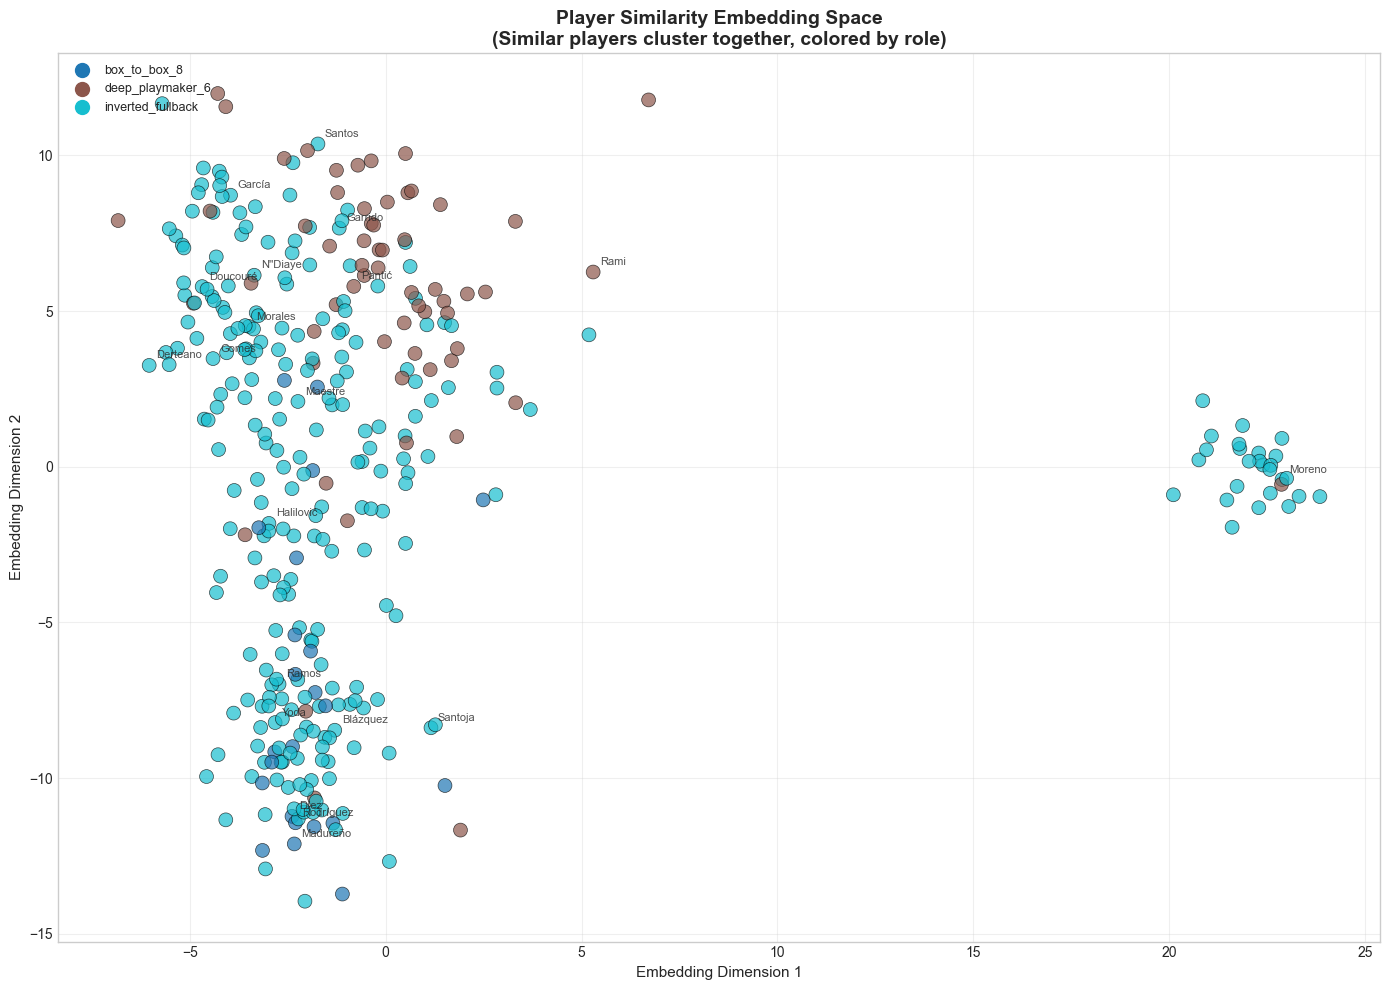


📊 Computing Similarity Matrix...


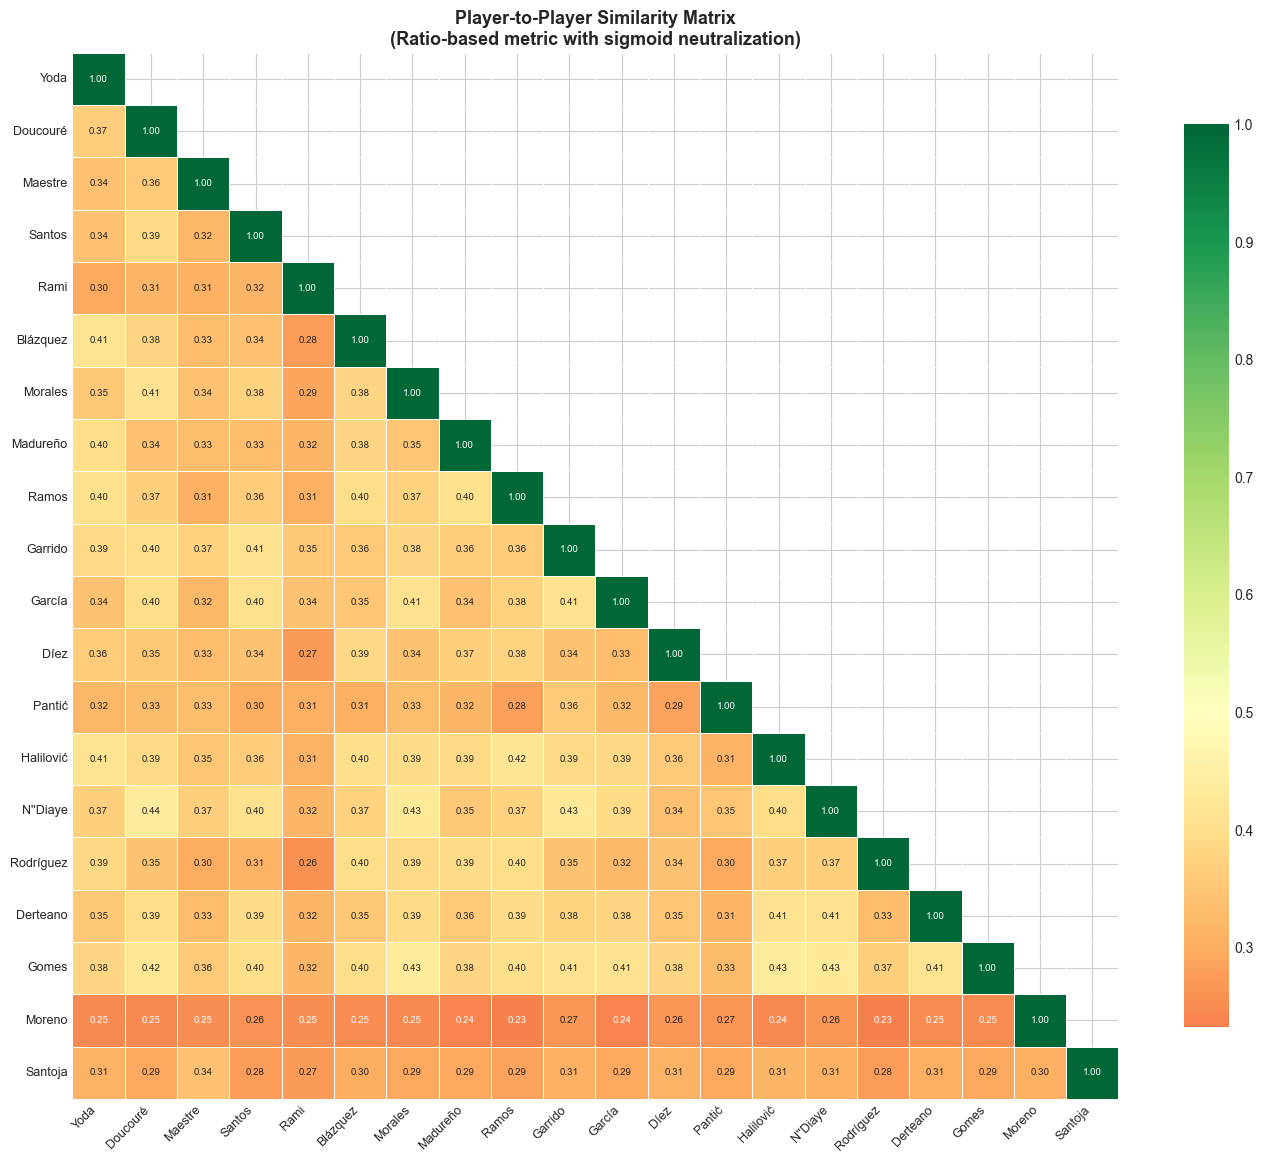


🤝 Most Similar Player Pairs:
------------------------------------------------------------
  Doucouré        ↔ N''Diaye        Similarity: 0.437
    Roles: inverted_fullback / inverted_fullback

  Halilović       ↔ Gomes           Similarity: 0.433
    Roles: inverted_fullback / inverted_fullback

  Morales         ↔ Gomes           Similarity: 0.431
    Roles: inverted_fullback / inverted_fullback

  Garrido         ↔ N''Diaye        Similarity: 0.429
    Roles: inverted_fullback / inverted_fullback

  Morales         ↔ N''Diaye        Similarity: 0.429
    Roles: inverted_fullback / inverted_fullback



In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.8: SIMILARITY QUERIES & VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PLAYER SIMILARITY QUERIES & VISUALIZATION")
print("=" * 80)

if len(pipeline.player_profiles) >= 5:
    
    # Get a sample player to query
    sample_players = list(pipeline.player_profiles.keys())[:10]
    query_player = sample_players[0] if sample_players else None
    
    if query_player:
        print(f"\n🔍 Finding similar players to: {query_player}")
        print("-" * 60)
        
        # Find similar players
        similar = pipeline.find_similar_players(
            query_player, 
            top_k=10, 
            same_role_only=False
        )
        
        print(f"\nTop 10 Most Similar Players:")
        print(f"{'Rank':<6}{'Player':<30}{'Similarity':<12}{'Role':<25}{'Match?'}")
        print("-" * 80)
        
        for i, p in enumerate(similar[:10]):
            match_emoji = "✓" if p['role_match'] else "✗"
            print(f"{i+1:<6}{p['player'][:28]:<30}{p['overall_similarity']:.3f}       "
                  f"{p['role'][:23]:<25}{match_emoji}")
        
        # Show detailed similarity breakdown for top match
        if similar:
            top_match = similar[0]
            print(f"\n📊 Detailed Similarity Breakdown: {query_player} vs {top_match['player']}")
            print("-" * 60)
            for feature, score in top_match['scores'].items():
                if feature != 'overall':
                    bar = "█" * int(score * 20) + "░" * (20 - int(score * 20))
                    print(f"  {feature:<15} [{bar}] {score:.3f}")
    
    # ═══════════════════════════════════════════════════════════════════════════
    # VISUALIZATION 1: Embedding Space (PCA projection)
    # ═══════════════════════════════════════════════════════════════════════════
    
    print("\n\n📈 Visualizing Player Embeddings...")
    
    if len(pipeline.player_embeddings) >= 5:
        # Get embeddings and roles for visualization
        player_names = list(pipeline.player_embeddings.keys())
        emb_matrix = np.array([pipeline.player_embeddings[p] for p in player_names])
        
        # PCA to 2D for visualization
        if emb_matrix.shape[1] > 2:
            pca_2d = PCA(n_components=2)
            emb_2d = pca_2d.fit_transform(emb_matrix)
        else:
            emb_2d = emb_matrix[:, :2]
        
        # Get roles for coloring
        role_colors = {}
        unique_roles = set()
        for p in player_names:
            role = pipeline.player_roles.get(p, {}).get('primary_role', 'Unknown')
            unique_roles.add(role)
        
        cmap = plt.cm.get_cmap('tab10', len(unique_roles))
        role_to_color = {role: cmap(i) for i, role in enumerate(sorted(unique_roles))}
        
        colors = [role_to_color[pipeline.player_roles.get(p, {}).get('primary_role', 'Unknown')] 
                  for p in player_names]
        
        fig, ax = plt.subplots(figsize=(14, 10))
        
        scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1], 
                            c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Label some points
        for i, name in enumerate(player_names[:20]):
            ax.annotate(name.split()[-1], (emb_2d[i, 0], emb_2d[i, 1]),
                       fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')
        
        # Create legend
        legend_elements = [plt.scatter([], [], c=[role_to_color[r]], label=r, s=100) 
                          for r in sorted(unique_roles)]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
        
        ax.set_xlabel('Embedding Dimension 1', fontsize=11)
        ax.set_ylabel('Embedding Dimension 2', fontsize=11)
        ax.set_title('Player Similarity Embedding Space\n(Similar players cluster together, colored by role)',
                    fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # ═══════════════════════════════════════════════════════════════════════════
    # VISUALIZATION 2: Similarity Heatmap
    # ═══════════════════════════════════════════════════════════════════════════
    
    print("\n📊 Computing Similarity Matrix...")
    
    # Select diverse subset for visualization
    subset_players = list(pipeline.player_profiles.keys())[:20]
    
    if len(subset_players) >= 5:
        sim_matrix = pipeline.compute_similarity_matrix(subset_players)
        
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Create heatmap
        mask = np.triu(np.ones_like(sim_matrix, dtype=bool), k=1)
        sns.heatmap(sim_matrix, mask=mask, annot=True, fmt='.2f',
                   cmap='RdYlGn', center=0.5, ax=ax,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                   annot_kws={"size": 7})
        
        # Shorten names for readability
        short_names = [name.split()[-1][:12] for name in subset_players]
        ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(short_names, rotation=0, fontsize=9)
        
        ax.set_title('Player-to-Player Similarity Matrix\n(Ratio-based metric with sigmoid neutralization)',
                    fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Find most similar pairs
        print("\n🤝 Most Similar Player Pairs:")
        print("-" * 60)
        
        pairs = []
        for i in range(len(subset_players)):
            for j in range(i+1, len(subset_players)):
                pairs.append((subset_players[i], subset_players[j], sim_matrix.iloc[i, j]))
        
        pairs.sort(key=lambda x: x[2], reverse=True)
        
        for p1, p2, sim in pairs[:5]:
            role1 = pipeline.player_roles.get(p1, {}).get('primary_role', '?')
            role2 = pipeline.player_roles.get(p2, {}).get('primary_role', '?')
            print(f"  {p1.split()[-1][:15]:15} ↔ {p2.split()[-1][:15]:15} "
                  f"Similarity: {sim:.3f}")
            print(f"    Roles: {role1} / {role2}")
            print()

else:
    print("Not enough player data for visualization. Try with more matches.")

PLAYER PROFILE VISUALIZATION

📊 Visualizing profile for: Abdoul Karim Yoda


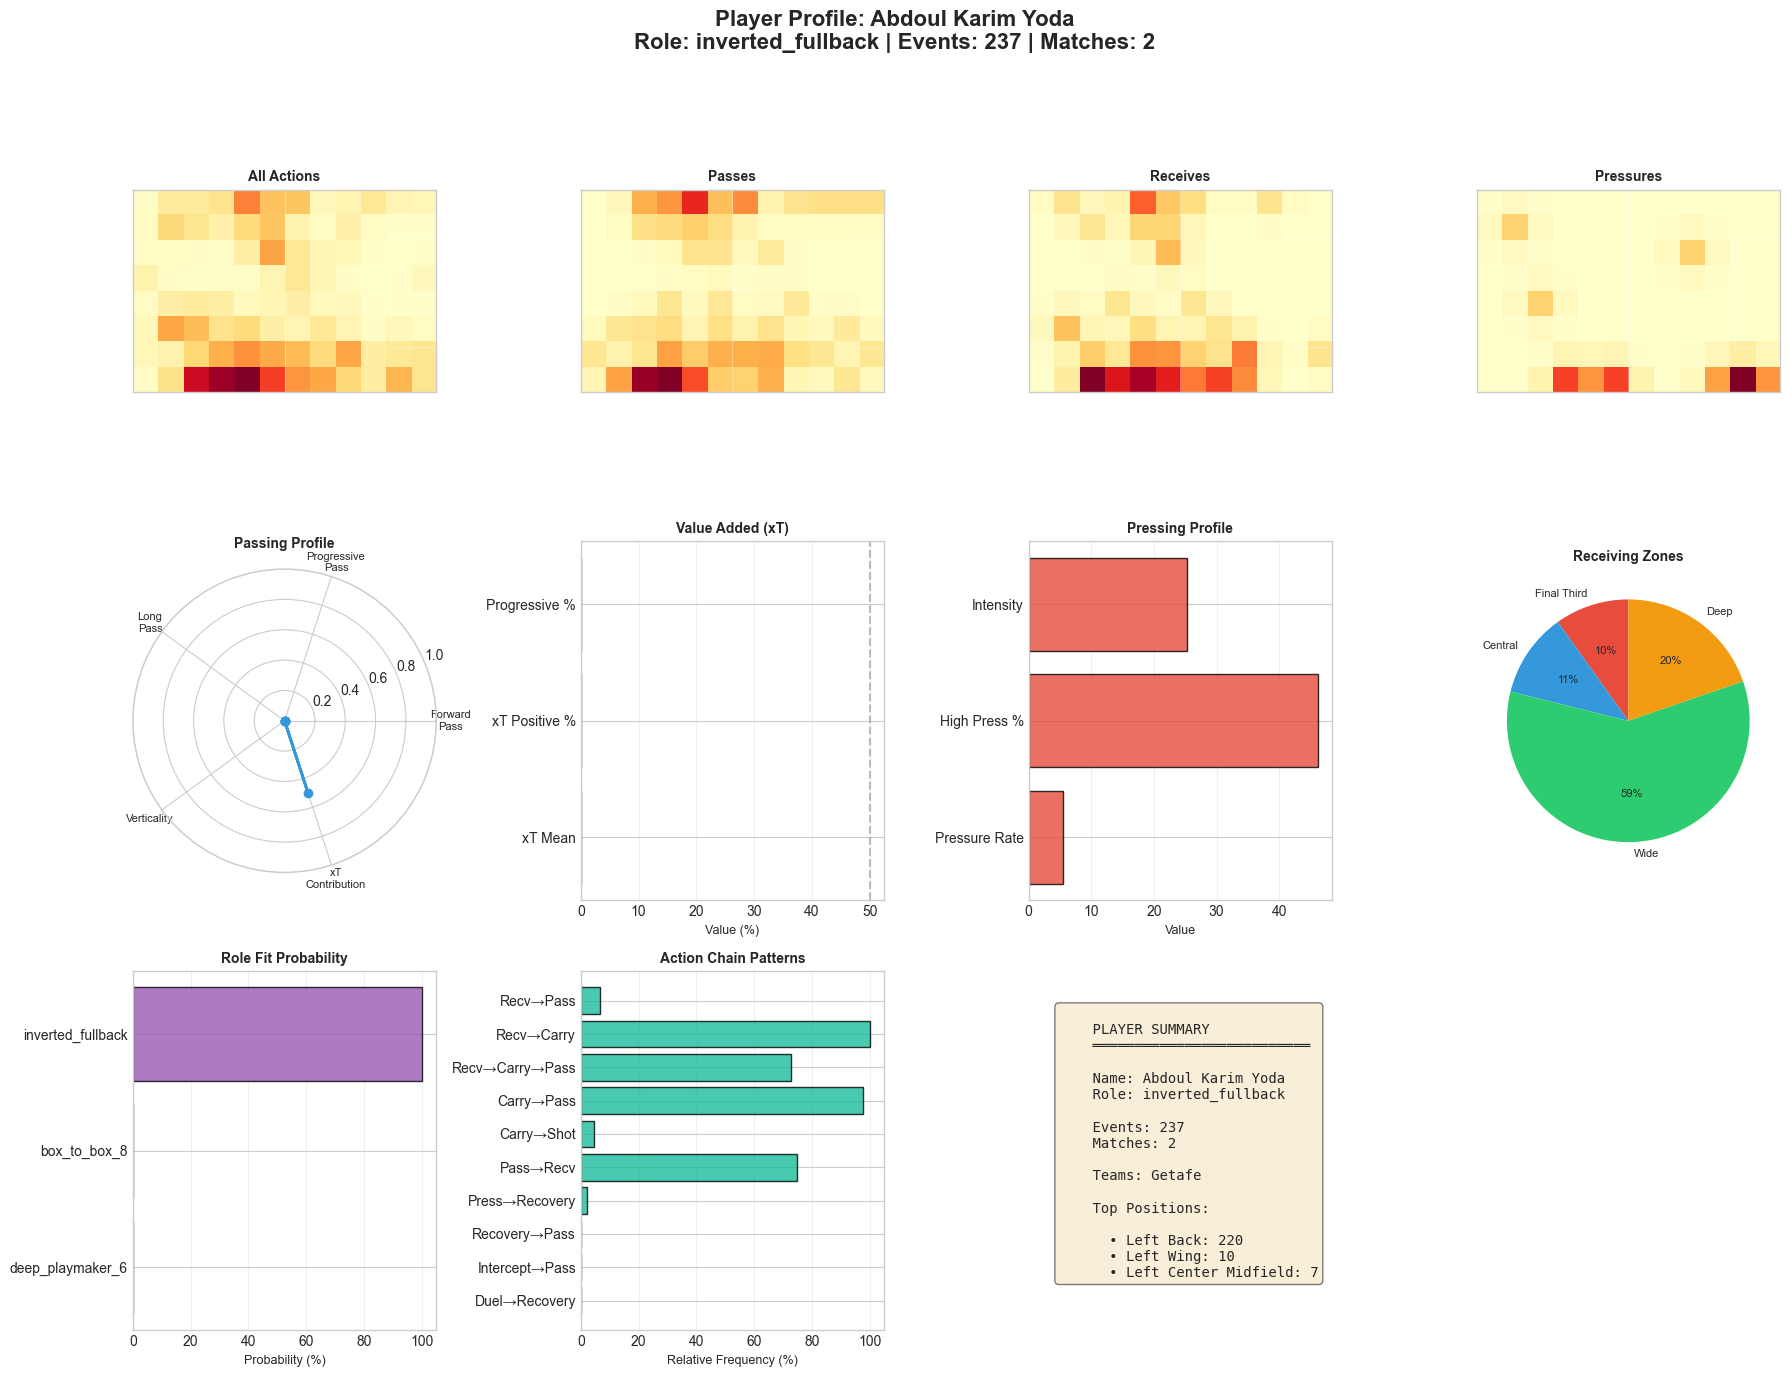


📊 Visualizing profile for: Abdoulaye Doucouré


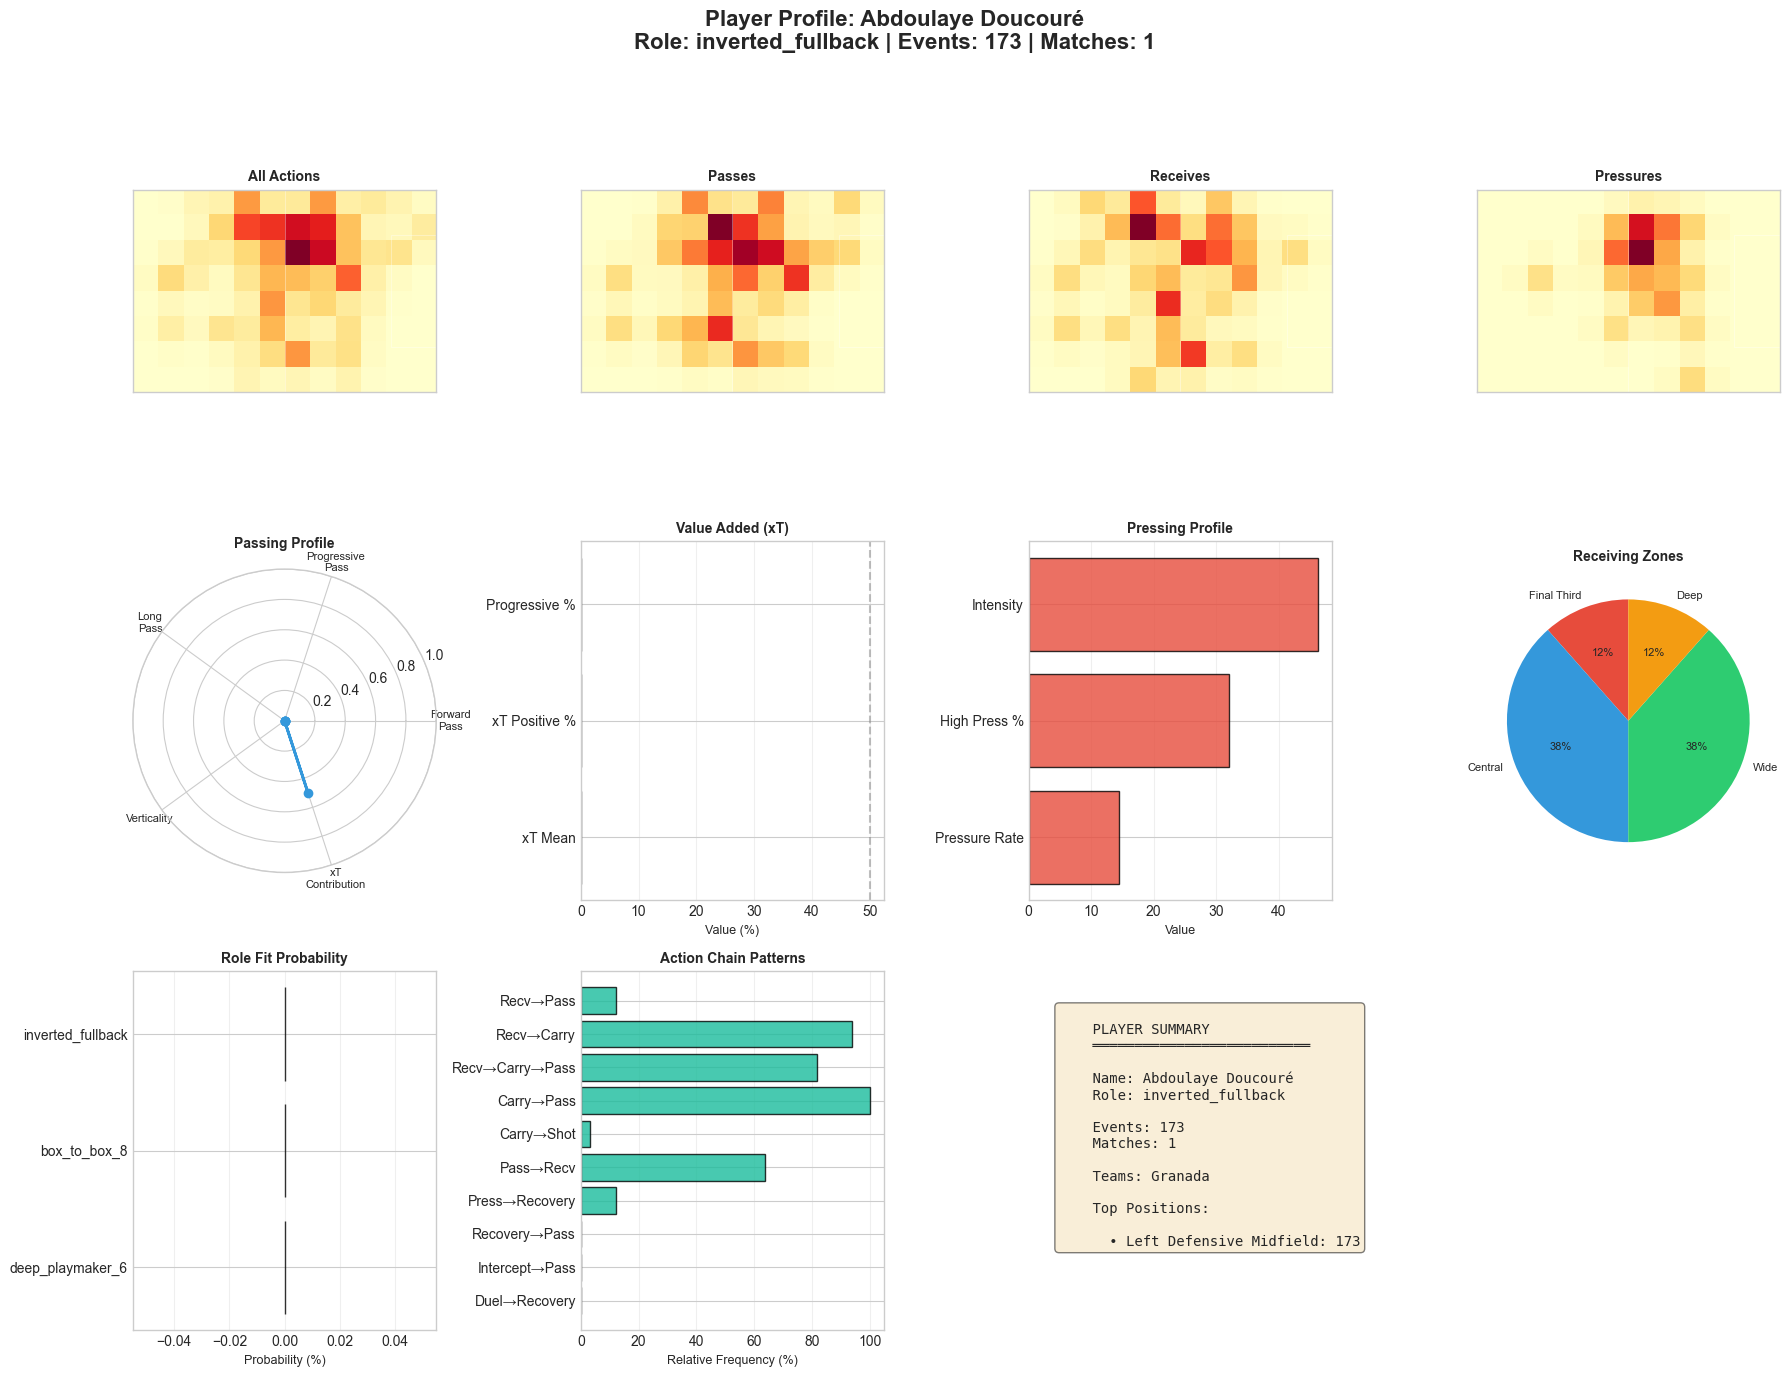

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 12.9: PLAYER PROFILE VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PLAYER PROFILE VISUALIZATION")
print("=" * 80)

def visualize_player_profile(player_name: str, pipeline: PlayerEmbeddingPipeline):
    """
    Create a comprehensive visualization of a player's behavioral profile.
    """
    if player_name not in pipeline.player_profiles:
        print(f"Player '{player_name}' not found")
        return
    
    profile = pipeline.player_profiles[player_name]
    metadata = pipeline.player_metadata.get(player_name, {})
    role_info = pipeline.player_roles.get(player_name, {})
    
    fig = plt.figure(figsize=(18, 14))
    
    # Title
    fig.suptitle(f'Player Profile: {player_name}\n'
                 f'Role: {role_info.get("primary_role", "Unknown")} | '
                 f'Events: {metadata.get("n_events", "N/A")} | '
                 f'Matches: {metadata.get("n_matches", "N/A")}',
                 fontsize=16, fontweight='bold', y=0.98)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 1. Spatial Heatmaps (2x2 grid in top-left)
    # ─────────────────────────────────────────────────────────────────────────
    heatmap_types = ['all', 'pass', 'receive', 'pressure']
    heatmap_titles = ['All Actions', 'Passes', 'Receives', 'Pressures']
    
    for i, (htype, htitle) in enumerate(zip(heatmap_types, heatmap_titles)):
        ax = fig.add_subplot(3, 4, i + 1)
        
        if 'spatial' in profile and htype in profile['spatial']:
            heatmap = profile['spatial'][htype]
            
            im = ax.imshow(heatmap, 
                          extent=[0, 120, 0, 80],
                          origin='lower',
                          cmap='YlOrRd',
                          aspect='equal')
            
            # Draw pitch overlay
            ax.plot([60, 60], [0, 80], 'w-', linewidth=0.5, alpha=0.5)
            ax.add_patch(plt.Rectangle((102, 18), 18, 44, fill=False, 
                                       edgecolor='white', linewidth=0.5, alpha=0.5))
        
        ax.set_title(htitle, fontsize=10, fontweight='bold')
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 80)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # ─────────────────────────────────────────────────────────────────────────
    # 2. Passing Profile (radar chart)
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 5, polar=True)
    
    if 'passing' in profile:
        passing = profile['passing']
        categories = ['Forward\nPass', 'Progressive\nPass', 'Long\nPass', 
                     'Verticality', 'xT\nContribution']
        values = [
            passing.get('forward_pass_rate', 0),
            passing.get('progressive_pass_rate', 0),
            min(passing.get('pass_length_mean', 0) / 40, 1),  # Normalize
            min(passing.get('verticality', 0), 1),
            max(0, passing.get('pass_xt_mean', 0) * 10 + 0.5)  # Scale
        ]
        
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        values = values + [values[0]]
        angles = angles + [angles[0]]
        
        ax.plot(angles, values, 'o-', linewidth=2, color='#3498db')
        ax.fill(angles, values, alpha=0.25, color='#3498db')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=8)
        ax.set_ylim(0, 1)
    
    ax.set_title('Passing Profile', fontsize=10, fontweight='bold', pad=15)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 3. Value Added Metrics
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 6)
    
    if 'value_added' in profile:
        va = profile['value_added']
        metrics = ['xT Mean', 'xT Positive %', 'Progressive %']
        values = [
            va.get('xt_mean', 0) * 100,  # Scale for visibility
            va.get('xt_positive_rate', 0) * 100,
            va.get('progressive_share', 0) * 100
        ]
        colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in values]
        
        bars = ax.barh(metrics, values, color=colors, alpha=0.8, edgecolor='black')
        ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('Value (%)', fontsize=9)
    
    ax.set_title('Value Added (xT)', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 4. Pressing Profile
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 7)
    
    if 'pressing' in profile:
        press = profile['pressing']
        metrics = ['Pressure Rate', 'High Press %', 'Intensity']
        values = [
            press.get('pressure_rate', 0) * 100,
            press.get('high_press_rate', 0) * 100,
            press.get('press_intensity', 0) * 1000  # Scale
        ]
        
        ax.barh(metrics, values, color='#e74c3c', alpha=0.8, edgecolor='black')
        ax.set_xlabel('Value', fontsize=9)
    
    ax.set_title('Pressing Profile', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 5. Receiving Profile
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 8)
    
    if 'receiving' in profile:
        recv = profile['receiving']
        labels = ['Final Third', 'Central', 'Wide', 'Deep']
        sizes = [
            recv.get('receive_final_third', 0) * 100,
            recv.get('receive_central', 0) * 100,
            recv.get('receive_wide', 0) * 100,
            recv.get('receive_deep', 0) * 100
        ]
        colors_pie = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
        
        if sum(sizes) > 0:
            ax.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.0f%%',
                  startangle=90, textprops={'fontsize': 8})
    
    ax.set_title('Receiving Zones', fontsize=10, fontweight='bold')
    
    # ─────────────────────────────────────────────────────────────────────────
    # 6. Role Probability Distribution
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 9)
    
    if role_info and 'role_probabilities' in role_info:
        role_probs = role_info['role_probabilities']
        sorted_roles = sorted(role_probs.items(), key=lambda x: x[1], reverse=True)[:6]
        roles, probs = zip(*sorted_roles)
        
        # Shorten role names
        roles = [r[:18] for r in roles]
        
        bars = ax.barh(roles[::-1], [p * 100 for p in probs[::-1]], 
                      color='#9b59b6', alpha=0.8, edgecolor='black')
        ax.set_xlabel('Probability (%)', fontsize=9)
    
    ax.set_title('Role Fit Probability', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 7. Action Chain Patterns
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 10)
    
    if 'chains' in profile:
        chain_labels = [
            'Recv→Pass', 'Recv→Carry', 'Recv→Carry→Pass',
            'Carry→Pass', 'Carry→Shot', 'Pass→Recv',
            'Press→Recovery', 'Recovery→Pass', 'Intercept→Pass', 'Duel→Recovery'
        ]
        chain_values = profile['chains'][:10]
        
        # Normalize for visibility
        max_val = max(chain_values) if max(chain_values) > 0 else 1
        chain_values = [v / max_val * 100 for v in chain_values]
        
        bars = ax.barh(chain_labels[::-1], chain_values[::-1],
                      color='#1abc9c', alpha=0.8, edgecolor='black')
        ax.set_xlabel('Relative Frequency (%)', fontsize=9)
    
    ax.set_title('Action Chain Patterns', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 8. Summary Statistics
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(3, 4, 11)
    ax.axis('off')
    
    summary_text = f"""
    PLAYER SUMMARY
    ══════════════════════════
    
    Name: {player_name}
    Role: {role_info.get('primary_role', 'Unknown')}
    
    Events: {metadata.get('n_events', 'N/A'):,}
    Matches: {metadata.get('n_matches', 'N/A')}
    
    Teams: {', '.join(metadata.get('teams', ['N/A'])[:2])}
    
    Top Positions:
    """
    
    positions = metadata.get('positions', {})
    top_positions = sorted(positions.items(), key=lambda x: x[1], reverse=True)[:3]
    for pos, count in top_positions:
        if pos:
            summary_text += f"\n      • {pos}: {count}"
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize a sample player
if len(pipeline.player_profiles) >= 1:
    sample_player = list(pipeline.player_profiles.keys())[0]
    print(f"\n📊 Visualizing profile for: {sample_player}")
    visualize_player_profile(sample_player, pipeline)
    
    # Visualize second player for comparison if available
    if len(pipeline.player_profiles) >= 2:
        sample_player2 = list(pipeline.player_profiles.keys())[1]
        print(f"\n📊 Visualizing profile for: {sample_player2}")
        visualize_player_profile(sample_player2, pipeline)
else:
    print("Not enough player data for visualization")

# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13: MODEL ARCHITECTURE SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

---

## Player Similarity Model - Complete Architecture

### Overview

This model provides a comprehensive framework for finding similar soccer players based on their **behavioral profiles** rather than raw statistics. It addresses key challenges:

1. **Cross-league comparability** through normalization
2. **Role-invariance** through pitch mirroring and position alignment
3. **Rare action handling** through sigmoid neutralization
4. **Interpretability** through feature-block architecture

---

### Component Summary

| Component | Purpose | Key Features |
|-----------|---------|--------------|
| **PitchNormalizer** | Standardize coordinates | Attacking direction, L/R mirroring, role unification |
| **ExpectedThreatModel** | Value ball movement | xT grid, delta calculation, shot-based learning |
| **BehavioralFeatureExtractor** | Extract player DNA | 7 feature blocks, normalized per-90 |
| **RatioBasedSimilarity** | Custom similarity metric | Ratio comparison, sigmoid neutralization |
| **RoleDiscovery** | Find player archetypes | GMM clustering, interpretable labels |
| **PlayerEmbeddingPipeline** | End-to-end processing | Profile building, embedding, queries |

---

### Similarity Metric Innovation

Unlike Euclidean or cosine similarity, our ratio-based metric handles the "both players rarely do X" problem:

```
Standard metrics:
  Player A: aerial win rate = 0.01
  Player B: aerial win rate = 0.01
  → High similarity (both have same value)  ❌ Misleading!

Our metric with sigmoid neutralization:
  Same scenario
  → Sigmoid weight ≈ 0.05 (low activity → low trust)
  → Contribution to overall similarity is minimal ✓
```

**Formula:**
$$\text{sim}(a, b) = \left(1 - \frac{|a - b|}{\max(a, b)}\right) \cdot \sigma\left(\min(a, b)\right)$$

Where $\sigma$ is a sigmoid function centered at the activity threshold.

---

### Feature Blocks

1. **Spatial Heatmaps** (12×8 grid)
   - All actions, passes, receives, pressures
   - Gaussian smoothing for robustness

2. **Action Chains** (n-grams)
   - Receive→Turn→Pass, Carry→Shot, etc.
   - Captures playing style sequences

3. **Value Added (xT)**
   - Expected threat contribution
   - Progressive vs regressive actions

4. **Pressing Profile**
   - Pressure rate, high press %, counter-press
   - Defensive workrate encoding

5. **Passing Tendencies**
   - Length, angle, verticality, risk-reward
   - Distribution style fingerprint

6. **Receiving Context**
   - Zone preferences, under-pressure receipts
   - Off-ball positioning signal

7. **Transition Play**
   - Speed after regains, directness
   - Counter-attack proficiency

---

### Usage Examples

```python
# Find similar players
similar = pipeline.find_similar_players(
    "Lionel Messi",
    top_k=10,
    same_role_only=False,
    exclude_teams=["FC Barcelona"]  # Find alternatives
)

# Get role probabilities
role_info = pipeline.player_roles["Kylian Mbappé"]
print(role_info['role_probabilities'])

# Compute pairwise similarity
scores = similarity_calc.compute_player_similarity(
    profile_messi, profile_neymar
)
print(f"Overall: {scores['overall']:.3f}")
print(f"Spatial: {scores['spatial']:.3f}")
print(f"Passing: {scores['passing']:.3f}")
```

---

### Extensions & Next Steps

1. **360 Data Integration**: Add freeze-frame features (nearest opponent, pressure index)
2. **Temporal Modeling**: Transformer over event sequences for richer embeddings
3. **Contrastive Learning**: Self-supervised pretraining on large event corpus
4. **Cross-modal**: Combine with physical tracking data (speed, acceleration)
5. **Market Value Prediction**: Use embeddings as features for valuation models

---

# ═══════════════════════════════════════════════════════════════════════════════
# PART 3: CONTEXT-DRIVEN PLAYER SIMILARITY WITH GRAPH NEURAL NETWORKS
# ═══════════════════════════════════════════════════════════════════════════════

---

## Enhanced Context-Driven Model Architecture

This section builds a **multi-layer contextual embedding system** that captures:

### 1. Context Dimensions We Can Derive (✓ = from data, △ = inferred)
| Context | Source | Reliability |
|---------|--------|-------------|
| **Competition/League** | Event metadata | ✓ High |
| **Score State** | Event timestamp + goals | ✓ High |
| **Position Played** | Event position field | ✓ High |
| **Game Phase** | Minutes + score delta | ✓ High |
| **Home/Away** | Match metadata | ✓ High |
| **Teammate Configuration** | 360 freeze frames | ✓ High (if available) |
| **Pressing Intensity** | 360 opponent positions | ✓ High (if available) |
| **Space Availability** | 360 spatial analysis | ✓ High (if available) |
| **Team Playing Style** | Aggregated team stats | △ Medium (inferred) |
| **Coaching Style** | Team patterns over season | △ Low (proxy only) |
| **Player Condition** | Not available | ✗ Cannot derive |

### 2. Three-Layer Embedding Architecture

```
┌─────────────────────────────────────────────────────────────────────┐
│                    CONTEXT-AWARE PLAYER EMBEDDING                   │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Layer 1: SPATIAL EMBEDDINGS (from 360 data if available)          │
│  ┌──────────────────────────────────────────────────────────┐      │
│  │ • Teammate positioning patterns                          │      │
│  │ • Opponent pressure vectors                              │      │
│  │ • Available space maps                                   │      │
│  │ • Receiving context (1v1, open, crowded)                │      │
│  └──────────────────────────────────────────────────────────┘      │
│                              ↓                                      │
│  Layer 2: SCENARIO EMBEDDINGS                                       │
│  ┌──────────────────────────────────────────────────────────┐      │
│  │ • Score state encoding (+2, +1, 0, -1, -2+)             │      │
│  │ • Game phase (early, mid, late, extra time)             │      │
│  │ • Competition embedding (La Liga vs PL vs UCL)          │      │
│  │ • Home/Away factor                                       │      │
│  └──────────────────────────────────────────────────────────┘      │
│                              ↓                                      │
│  Layer 3: GRAPH NEURAL NETWORK                                      │
│  ┌──────────────────────────────────────────────────────────┐      │
│  │ • Nodes = Players with behavioral embeddings            │      │
│  │ • Edges = Passing connections + spatial proximity       │      │
│  │ • Message passing to capture team context               │      │
│  │ • 2-layer GCN: Player ↔ Teammates ↔ Team Style         │      │
│  └──────────────────────────────────────────────────────────┘      │
│                              ↓                                      │
│              FINAL CONTEXT-AWARE PLAYER VECTOR                      │
└─────────────────────────────────────────────────────────────────────┘
```

### 3. Why This Matters
- **Same player, different context** → Different embedding
- Query: "Find me a player like Messi *when playing in La Liga, leading by 1*"
- vs: "Find me a player like Messi *when playing UCL knockout, chasing the game*"

---

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13: CONTEXT CONFIGURATION & 360 DATA LOADER
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CONTEXT-DRIVEN SIMILARITY MODEL - INITIALIZATION")
print("=" * 80)

from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional, Any, Set
from enum import Enum
import numpy as np
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ═══════════════════════════════════════════════════════════════════════════════
# CONTEXT ENUMERATIONS (Explicit, Verifiable Categories)
# ═══════════════════════════════════════════════════════════════════════════════

class ScoreState(Enum):
    """Score differential states - directly derivable from data."""
    LOSING_BIG = "losing_2+"      # Down by 2 or more
    LOSING = "losing_1"           # Down by 1
    DRAWING = "drawing"           # Level
    WINNING = "winning_1"         # Up by 1
    WINNING_BIG = "winning_2+"    # Up by 2 or more

class GamePhase(Enum):
    """Game phase - directly derivable from minute."""
    EARLY = "0-15"         # Opening phase
    BUILDING = "15-30"     # Settling into game
    PRE_HALF = "30-45"     # Before half time
    SECOND_START = "45-60" # Second half opening
    CRUCIAL = "60-75"      # Key period for subs/changes
    CLOSING = "75-90"      # Late game
    EXTRA = "90+"          # Injury time / Extra time

class CompetitionType(Enum):
    """Competition categorization for style differences."""
    LA_LIGA = "la_liga"
    PREMIER_LEAGUE = "premier_league"  
    BUNDESLIGA = "bundesliga"
    SERIE_A = "serie_a"
    LIGUE_1 = "ligue_1"
    CHAMPIONS_LEAGUE = "champions_league"
    WORLD_CUP = "world_cup"
    OTHER = "other"

class ReceivingContext(Enum):
    """Context when receiving the ball - from 360 data."""
    OPEN = "open"                    # No immediate pressure
    UNDER_PRESSURE = "under_pressure" # Defender within 2m
    TIGHT_SPACE = "tight_space"      # Multiple opponents nearby
    ISOLATED = "isolated"            # Far from teammates
    BETWEEN_LINES = "between_lines"  # In dangerous space

@dataclass
class ContextConfig:
    """Configuration for context-driven similarity model."""
    
    # 360 Data thresholds (meters)
    pressure_radius: float = 2.0      # Distance to be "under pressure"
    tight_space_opponents: int = 3    # Number of opponents for "tight space"
    isolation_teammate_dist: float = 15.0  # Distance to nearest teammate for "isolated"
    between_lines_y_range: Tuple[float, float] = (18.0, 62.0)  # Penalty area width
    between_lines_x_range: Tuple[float, float] = (72.0, 102.0) # Between midfield and box
    
    # Graph construction
    min_passes_for_edge: int = 3      # Minimum passes to create edge
    spatial_proximity_threshold: float = 10.0  # Meters for spatial edge
    
    # Embedding dimensions
    spatial_embedding_dim: int = 16
    scenario_embedding_dim: int = 8
    gnn_hidden_dim: int = 32
    final_embedding_dim: int = 64
    
    # Competition ID mappings (StatsBomb)
    competition_mapping: Dict[int, CompetitionType] = field(default_factory=lambda: {
        11: CompetitionType.LA_LIGA,
        2: CompetitionType.PREMIER_LEAGUE,
        9: CompetitionType.BUNDESLIGA,
        12: CompetitionType.SERIE_A,
        7: CompetitionType.LIGUE_1,
        16: CompetitionType.CHAMPIONS_LEAGUE,
        43: CompetitionType.WORLD_CUP,
    })

context_config = ContextConfig()

# ═══════════════════════════════════════════════════════════════════════════════
# 360 DATA LOADER & VALIDATOR
# ═══════════════════════════════════════════════════════════════════════════════

class Data360Loader:
    """
    Loads and validates StatsBomb 360 freeze-frame data.
    
    360 data provides positions of all visible players at key moments.
    NOT all matches have 360 data - we validate availability.
    """
    
    def __init__(self):
        self.matches_with_360: Set[int] = set()
        self.freeze_frame_cache: Dict[str, List[Dict]] = {}
        
    def check_360_availability(self, match_id: int) -> bool:
        """
        Check if 360 data exists for a match.
        Returns True only if data is actually available.
        """
        if match_id in self.matches_with_360:
            return True
            
        try:
            url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id}.json"
            response = requests.get(url, verify=False, timeout=5)
            if response.status_code == 200:
                data = response.json()
                if data and len(data) > 0:
                    self.matches_with_360.add(match_id)
                    return True
        except:
            pass
        return False
    
    def load_360_data(self, match_id: int) -> Optional[pd.DataFrame]:
        """
        Load 360 freeze-frame data for a match.
        
        Returns DataFrame with columns:
        - event_uuid: Links to main event
        - freeze_frame: List of player positions
        - visible_area: Polygon of camera visibility
        """
        if not self.check_360_availability(match_id):
            return None
            
        try:
            url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id}.json"
            response = requests.get(url, verify=False)
            data = response.json()
            
            rows = []
            for frame in data:
                rows.append({
                    'event_uuid': frame.get('event_uuid'),
                    'freeze_frame': frame.get('freeze_frame', []),
                    'visible_area': frame.get('visible_area', [])
                })
            
            return pd.DataFrame(rows)
        except Exception as e:
            print(f"  Warning: Could not load 360 data for match {match_id}: {e}")
            return None
    
    def extract_spatial_context(self, 
                                 freeze_frame: List[Dict],
                                 actor_location: Tuple[float, float],
                                 actor_teammate: bool,
                                 config: ContextConfig) -> Dict[str, Any]:
        """
        Extract spatial context from a 360 freeze frame.
        
        This is the KEY function that derives context from 360 data.
        Only returns values we can RELIABLY compute.
        """
        if not freeze_frame:
            return {'has_360': False}
        
        ax, ay = actor_location
        
        # Separate teammates and opponents
        teammates = []
        opponents = []
        
        for player in freeze_frame:
            loc = player.get('location', [])
            if len(loc) < 2:
                continue
            px, py = loc[0], loc[1]
            is_teammate = player.get('teammate', False)
            is_keeper = player.get('keeper', False)
            
            dist = np.sqrt((px - ax)**2 + (py - ay)**2)
            
            player_info = {
                'x': px, 'y': py, 
                'distance': dist,
                'is_keeper': is_keeper,
                'angle': np.arctan2(py - ay, px - ax)
            }
            
            if is_teammate:
                teammates.append(player_info)
            else:
                opponents.append(player_info)
        
        # ═══════════════════════════════════════════════════════════════════════
        # DERIVED SPATIAL FEATURES (All directly computable from positions)
        # ═══════════════════════════════════════════════════════════════════════
        
        context = {'has_360': True}
        
        # 1. Pressure analysis
        close_opponents = [o for o in opponents if o['distance'] < config.pressure_radius]
        context['n_opponents_pressure'] = len(close_opponents)
        context['under_immediate_pressure'] = len(close_opponents) > 0
        
        # 2. Tight space detection
        nearby_opponents = [o for o in opponents if o['distance'] < config.pressure_radius * 2]
        context['in_tight_space'] = len(nearby_opponents) >= config.tight_space_opponents
        
        # 3. Isolation detection
        if teammates:
            nearest_teammate_dist = min(t['distance'] for t in teammates)
            context['nearest_teammate_dist'] = nearest_teammate_dist
            context['is_isolated'] = nearest_teammate_dist > config.isolation_teammate_dist
        else:
            context['nearest_teammate_dist'] = np.nan
            context['is_isolated'] = True
        
        # 4. Between-the-lines detection
        in_dangerous_y = config.between_lines_y_range[0] <= ay <= config.between_lines_y_range[1]
        in_dangerous_x = config.between_lines_x_range[0] <= ax <= config.between_lines_x_range[1]
        context['between_lines'] = in_dangerous_x and in_dangerous_y
        
        # 5. Passing lane availability (simple version)
        # Count teammates in forward positions with no opponent directly between
        forward_options = 0
        for t in teammates:
            if t['x'] > ax:  # Teammate ahead
                # Check if any opponent blocks the direct line
                blocked = False
                for o in opponents:
                    # Simple check: opponent roughly on the line
                    if ax < o['x'] < t['x']:
                        # Check if opponent is close to the line between actor and teammate
                        line_dist = abs((t['y'] - ay) * o['x'] - (t['x'] - ax) * o['y'] + 
                                       t['x'] * ay - t['y'] * ax) / t['distance']
                        if line_dist < 3.0:  # Within 3 meters of passing lane
                            blocked = True
                            break
                if not blocked:
                    forward_options += 1
        context['n_forward_passing_options'] = forward_options
        
        # 6. Space metrics
        if opponents:
            context['avg_opponent_distance'] = np.mean([o['distance'] for o in opponents])
            context['min_opponent_distance'] = min(o['distance'] for o in opponents)
        else:
            context['avg_opponent_distance'] = np.nan
            context['min_opponent_distance'] = np.nan
        
        # 7. Numerical superiority in immediate area (5m radius)
        local_teammates = len([t for t in teammates if t['distance'] < 5])
        local_opponents = len([o for o in opponents if o['distance'] < 5])
        context['local_numerical_balance'] = local_teammates - local_opponents
        
        # 8. Categorize receiving context
        if context['under_immediate_pressure']:
            context['receiving_context'] = ReceivingContext.UNDER_PRESSURE.value
        elif context['in_tight_space']:
            context['receiving_context'] = ReceivingContext.TIGHT_SPACE.value
        elif context['is_isolated']:
            context['receiving_context'] = ReceivingContext.ISOLATED.value
        elif context['between_lines']:
            context['receiving_context'] = ReceivingContext.BETWEEN_LINES.value
        else:
            context['receiving_context'] = ReceivingContext.OPEN.value
        
        return context

data_360_loader = Data360Loader()

print(f"Context Configuration initialized:")
print(f"  Pressure radius: {context_config.pressure_radius}m")
print(f"  Graph edge threshold: {context_config.min_passes_for_edge} passes")
print(f"  Final embedding dim: {context_config.final_embedding_dim}")
print(f"\n360 Data Loader ready")
print("=" * 80)

CONTEXT-DRIVEN SIMILARITY MODEL - INITIALIZATION
Context Configuration initialized:
  Pressure radius: 2.0m
  Graph edge threshold: 3 passes
  Final embedding dim: 64

360 Data Loader ready


In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.1: SCENARIO EMBEDDINGS (Competition, Score State, Game Phase)
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("SCENARIO EMBEDDING SYSTEM")
print("=" * 80)

class ScenarioEmbedder:
    """
    Creates embeddings for game scenarios/contexts.
    
    All features here are DIRECTLY derivable from event metadata:
    - Score state: From cumulative goals at event time
    - Game phase: From minute
    - Competition: From competition_id
    - Home/Away: From match metadata
    
    NO inference or estimation - only facts from data.
    """
    
    def __init__(self, config: ContextConfig):
        self.config = config
        
        # One-hot dimensions
        self.n_score_states = len(ScoreState)        # 5
        self.n_game_phases = len(GamePhase)          # 7
        self.n_competitions = len(CompetitionType)   # 8
        self.n_home_away = 2                         # 2
        
        self.total_dim = (self.n_score_states + self.n_game_phases + 
                         self.n_competitions + self.n_home_away)
        
        # Mappings for encoding
        self.score_state_to_idx = {s: i for i, s in enumerate(ScoreState)}
        self.game_phase_to_idx = {p: i for i, p in enumerate(GamePhase)}
        self.competition_to_idx = {c: i for i, c in enumerate(CompetitionType)}
        
    def get_score_state(self, team_goals: int, opponent_goals: int) -> ScoreState:
        """Determine score state from goal counts."""
        diff = team_goals - opponent_goals
        if diff <= -2:
            return ScoreState.LOSING_BIG
        elif diff == -1:
            return ScoreState.LOSING
        elif diff == 0:
            return ScoreState.DRAWING
        elif diff == 1:
            return ScoreState.WINNING
        else:
            return ScoreState.WINNING_BIG
    
    def get_game_phase(self, minute: int) -> GamePhase:
        """Determine game phase from minute."""
        if minute < 15:
            return GamePhase.EARLY
        elif minute < 30:
            return GamePhase.BUILDING
        elif minute < 45:
            return GamePhase.PRE_HALF
        elif minute < 60:
            return GamePhase.SECOND_START
        elif minute < 75:
            return GamePhase.CRUCIAL
        elif minute < 90:
            return GamePhase.CLOSING
        else:
            return GamePhase.EXTRA
    
    def get_competition_type(self, competition_id: int) -> CompetitionType:
        """Map competition ID to type."""
        return self.config.competition_mapping.get(competition_id, CompetitionType.OTHER)
    
    def encode_scenario(self,
                        team_goals: int,
                        opponent_goals: int,
                        minute: int,
                        competition_id: int,
                        is_home: bool) -> np.ndarray:
        """
        Create scenario embedding vector.
        
        Returns concatenated one-hot vectors:
        [score_state | game_phase | competition | home_away]
        """
        embedding = np.zeros(self.total_dim)
        offset = 0
        
        # Score state one-hot
        score_state = self.get_score_state(team_goals, opponent_goals)
        embedding[offset + self.score_state_to_idx[score_state]] = 1.0
        offset += self.n_score_states
        
        # Game phase one-hot
        game_phase = self.get_game_phase(minute)
        embedding[offset + self.game_phase_to_idx[game_phase]] = 1.0
        offset += self.n_game_phases
        
        # Competition one-hot
        competition = self.get_competition_type(competition_id)
        embedding[offset + self.competition_to_idx[competition]] = 1.0
        offset += self.n_competitions
        
        # Home/Away
        embedding[offset + (0 if is_home else 1)] = 1.0
        
        return embedding
    
    def encode_scenario_soft(self,
                             team_goals: int,
                             opponent_goals: int,
                             minute: int,
                             competition_id: int,
                             is_home: bool) -> np.ndarray:
        """
        Create soft scenario embedding with learned dense representation.
        
        Instead of pure one-hot, uses a compressed learned embedding.
        This is useful when we want to capture that "winning by 1" is 
        more similar to "drawing" than "winning by 3".
        """
        # Start with one-hot
        one_hot = self.encode_scenario(team_goals, opponent_goals, minute, 
                                       competition_id, is_home)
        
        # Create ordinal components for score state (captures similarity structure)
        diff = team_goals - opponent_goals
        score_ordinal = np.array([
            np.clip(diff, -3, 3) / 3.0,  # Normalized score difference
            1.0 if diff > 0 else 0.0,     # Winning indicator
            1.0 if diff < 0 else 0.0,     # Losing indicator
            1.0 if diff == 0 else 0.0,    # Drawing indicator
        ])
        
        # Create ordinal for game phase
        phase_ordinal = np.array([
            minute / 90.0,                           # Normalized minute
            1.0 if minute > 75 else 0.0,            # Late game indicator
            1.0 if 60 <= minute <= 75 else 0.0,     # Crucial phase indicator
        ])
        
        # Combine: one-hot for specificity + ordinal for similarity structure
        return np.concatenate([one_hot, score_ordinal, phase_ordinal])

scenario_embedder = ScenarioEmbedder(context_config)

print(f"Scenario Embedder initialized:")
print(f"  Score states: {[s.value for s in ScoreState]}")
print(f"  Game phases: {[p.value for p in GamePhase]}")
print(f"  Competitions: {[c.value for c in CompetitionType]}")
print(f"  Base embedding dimension: {scenario_embedder.total_dim}")
print(f"  Soft embedding dimension: {scenario_embedder.total_dim + 7}")

# Demonstrate scenario embeddings
print("\nScenario Embedding Examples:")
print("-" * 60)

examples = [
    (2, 1, 25, 11, True, "La Liga, winning 2-1, 25th min, home"),
    (0, 1, 82, 11, False, "La Liga, losing 0-1, 82nd min, away"),
    (1, 1, 5, 43, True, "World Cup, drawing 1-1, 5th min, home"),
    (3, 0, 70, 2, True, "PL, winning 3-0, 70th min, home"),
]

for tg, og, minute, comp, home, desc in examples:
    emb = scenario_embedder.encode_scenario_soft(tg, og, minute, comp, home)
    score = scenario_embedder.get_score_state(tg, og).value
    phase = scenario_embedder.get_game_phase(minute).value
    print(f"  {desc}")
    print(f"    → Score state: {score}, Phase: {phase}")
    print(f"    → Embedding sum: {emb.sum():.2f} (non-zero dims: {np.sum(emb != 0)})")

print("=" * 80)

SCENARIO EMBEDDING SYSTEM
Scenario Embedder initialized:
  Score states: ['losing_2+', 'losing_1', 'drawing', 'winning_1', 'winning_2+']
  Game phases: ['0-15', '15-30', '30-45', '45-60', '60-75', '75-90', '90+']
  Competitions: ['la_liga', 'premier_league', 'bundesliga', 'serie_a', 'ligue_1', 'champions_league', 'world_cup', 'other']
  Base embedding dimension: 22
  Soft embedding dimension: 29

Scenario Embedding Examples:
------------------------------------------------------------
  La Liga, winning 2-1, 25th min, home
    → Score state: winning_1, Phase: 15-30
    → Embedding sum: 5.61 (non-zero dims: 7)
  La Liga, losing 0-1, 82nd min, away
    → Score state: losing_1, Phase: 75-90
    → Embedding sum: 6.58 (non-zero dims: 8)
  World Cup, drawing 1-1, 5th min, home
    → Score state: drawing, Phase: 0-15
    → Embedding sum: 5.06 (non-zero dims: 6)
  PL, winning 3-0, 70th min, home
    → Score state: winning_2+, Phase: 60-75
    → Embedding sum: 7.78 (non-zero dims: 8)


In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.2: SPATIAL EMBEDDINGS FROM 360 DATA
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("SPATIAL EMBEDDING SYSTEM (360 Data)")
print("=" * 80)

class SpatialEmbedder:
    """
    Creates spatial embeddings from 360 freeze-frame data.
    
    Key principle: Only derive what we can ACCURATELY compute from positions.
    
    Features we CAN derive:
    - Pressure intensity (opponent proximity)
    - Space availability (distance to opponents)
    - Isolation (distance to teammates)
    - Passing options (forward teammates with open lanes)
    - Receiving context (open/pressured/tight/isolated)
    
    Features we CANNOT derive (and don't try to):
    - Player intent
    - Fatigue/condition
    - What the player was thinking
    """
    
    def __init__(self, config: ContextConfig):
        self.config = config
        self.receiving_contexts = list(ReceivingContext)
        
        # Feature dimensions
        # Continuous: 8 features (pressure, distances, options, etc.)
        # Categorical: 5 receiving contexts (one-hot)
        self.continuous_dim = 8
        self.categorical_dim = len(ReceivingContext)
        self.total_dim = self.continuous_dim + self.categorical_dim
        
    def encode_spatial_context(self, context_dict: Dict[str, Any]) -> np.ndarray:
        """
        Convert 360-derived context to embedding vector.
        
        If 360 data not available, returns zeros (explicit missing indicator).
        """
        embedding = np.zeros(self.total_dim)
        
        if not context_dict.get('has_360', False):
            # No 360 data - leave as zeros
            # This is EXPLICIT - we don't fake data we don't have
            return embedding
        
        # ═══════════════════════════════════════════════════════════════════════
        # CONTINUOUS FEATURES (normalized to ~[0,1] range)
        # ═══════════════════════════════════════════════════════════════════════
        
        # 1. Immediate pressure (0-1, higher = more pressure)
        n_pressure = context_dict.get('n_opponents_pressure', 0)
        embedding[0] = min(n_pressure / 3.0, 1.0)  # Cap at 3 opponents
        
        # 2. Under immediate pressure (binary)
        embedding[1] = 1.0 if context_dict.get('under_immediate_pressure', False) else 0.0
        
        # 3. Tight space indicator
        embedding[2] = 1.0 if context_dict.get('in_tight_space', False) else 0.0
        
        # 4. Isolation indicator
        embedding[3] = 1.0 if context_dict.get('is_isolated', False) else 0.0
        
        # 5. Nearest teammate distance (normalized, inverse - closer is higher)
        nearest_tm = context_dict.get('nearest_teammate_dist', 20.0)
        if pd.isna(nearest_tm):
            nearest_tm = 20.0
        embedding[4] = max(0, 1.0 - nearest_tm / 20.0)  # 0m = 1.0, 20m = 0.0
        
        # 6. Forward passing options (normalized)
        fwd_options = context_dict.get('n_forward_passing_options', 0)
        embedding[5] = min(fwd_options / 5.0, 1.0)  # Cap at 5 options
        
        # 7. Average opponent distance (normalized)
        avg_opp = context_dict.get('avg_opponent_distance', 10.0)
        if pd.isna(avg_opp):
            avg_opp = 10.0
        embedding[6] = min(avg_opp / 20.0, 1.0)  # More space = higher
        
        # 8. Local numerical superiority (-1 to +1 range, normalized)
        num_balance = context_dict.get('local_numerical_balance', 0)
        embedding[7] = np.clip(num_balance / 3.0, -1.0, 1.0)  # -3 to +3 → -1 to +1
        
        # ═══════════════════════════════════════════════════════════════════════
        # CATEGORICAL FEATURE (Receiving Context - one-hot)
        # ═══════════════════════════════════════════════════════════════════════
        
        receiving_ctx = context_dict.get('receiving_context', ReceivingContext.OPEN.value)
        for i, ctx in enumerate(self.receiving_contexts):
            if ctx.value == receiving_ctx:
                embedding[self.continuous_dim + i] = 1.0
                break
        
        return embedding
    
    def aggregate_player_spatial_profile(self, 
                                          spatial_contexts: List[Dict]) -> Dict[str, Any]:
        """
        Aggregate multiple spatial contexts into a player profile.
        
        This captures HOW a player typically receives/operates:
        - What % of touches are under pressure?
        - Do they operate in tight spaces or open areas?
        - Are they often isolated or well-connected?
        """
        if not spatial_contexts:
            return {'has_360_data': False}
        
        valid_contexts = [c for c in spatial_contexts if c.get('has_360', False)]
        if not valid_contexts:
            return {'has_360_data': False}
        
        profile = {'has_360_data': True, 'n_360_events': len(valid_contexts)}
        
        # Aggregate continuous metrics
        profile['pct_under_pressure'] = np.mean([
            c.get('under_immediate_pressure', False) for c in valid_contexts
        ])
        profile['pct_tight_space'] = np.mean([
            c.get('in_tight_space', False) for c in valid_contexts
        ])
        profile['pct_isolated'] = np.mean([
            c.get('is_isolated', False) for c in valid_contexts
        ])
        profile['pct_between_lines'] = np.mean([
            c.get('between_lines', False) for c in valid_contexts
        ])
        profile['avg_forward_options'] = np.mean([
            c.get('n_forward_passing_options', 0) for c in valid_contexts
        ])
        profile['avg_numerical_superiority'] = np.mean([
            c.get('local_numerical_balance', 0) for c in valid_contexts
        ])
        
        # Receiving context distribution
        ctx_counts = defaultdict(int)
        for c in valid_contexts:
            ctx = c.get('receiving_context', ReceivingContext.OPEN.value)
            ctx_counts[ctx] += 1
        total = sum(ctx_counts.values())
        for ctx in ReceivingContext:
            profile[f'pct_receive_{ctx.value}'] = ctx_counts[ctx.value] / total if total > 0 else 0
        
        return profile
    
    def create_profile_embedding(self, spatial_profile: Dict) -> np.ndarray:
        """
        Create embedding from aggregated spatial profile.
        
        This is the PLAYER-LEVEL spatial embedding (not per-event).
        """
        if not spatial_profile.get('has_360_data', False):
            return np.zeros(self.config.spatial_embedding_dim)
        
        features = [
            spatial_profile.get('pct_under_pressure', 0),
            spatial_profile.get('pct_tight_space', 0),
            spatial_profile.get('pct_isolated', 0),
            spatial_profile.get('pct_between_lines', 0),
            spatial_profile.get('avg_forward_options', 0) / 5.0,  # Normalize
            np.clip(spatial_profile.get('avg_numerical_superiority', 0) / 3.0, -1, 1),
        ]
        
        # Add receiving context distribution
        for ctx in ReceivingContext:
            features.append(spatial_profile.get(f'pct_receive_{ctx.value}', 0))
        
        return np.array(features)

spatial_embedder = SpatialEmbedder(context_config)

print(f"Spatial Embedder initialized:")
print(f"  Continuous features: {spatial_embedder.continuous_dim}")
print(f"  Categorical features: {spatial_embedder.categorical_dim}")
print(f"  Total embedding dim: {spatial_embedder.total_dim}")
print(f"\nReceiving contexts tracked: {[c.value for c in ReceivingContext]}")

# Demonstrate with mock 360 context
mock_360_context = {
    'has_360': True,
    'n_opponents_pressure': 2,
    'under_immediate_pressure': True,
    'in_tight_space': False,
    'is_isolated': False,
    'nearest_teammate_dist': 5.0,
    'n_forward_passing_options': 3,
    'avg_opponent_distance': 8.0,
    'local_numerical_balance': 1,
    'receiving_context': ReceivingContext.UNDER_PRESSURE.value
}

emb = spatial_embedder.encode_spatial_context(mock_360_context)
print(f"\nExample spatial embedding (pressured receive):")
print(f"  Non-zero indices: {np.where(emb != 0)[0].tolist()}")
print(f"  Values: {emb[emb != 0].tolist()}")

print("=" * 80)

SPATIAL EMBEDDING SYSTEM (360 Data)
Spatial Embedder initialized:
  Continuous features: 8
  Categorical features: 5
  Total embedding dim: 13

Receiving contexts tracked: ['open', 'under_pressure', 'tight_space', 'isolated', 'between_lines']

Example spatial embedding (pressured receive):
  Non-zero indices: [0, 1, 4, 5, 6, 7, 9]
  Values: [0.6666666666666666, 1.0, 0.75, 0.6, 0.4, 0.3333333333333333, 1.0]


In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.3: GRAPH NEURAL NETWORK FOR TEAM CONTEXT
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("GRAPH NEURAL NETWORK LAYER")
print("=" * 80)

class SimpleGNNLayer:
    """
    A simple 2-layer Graph Neural Network implemented in pure NumPy.
    
    This captures relational context:
    - Who does a player pass to/receive from?
    - How do teammates' styles influence the player?
    - Team-level playing patterns
    
    Architecture:
    Layer 1: Player embedding + aggregated neighbor embeddings
    Layer 2: Contextualized player embedding + team-level context
    
    No PyTorch/TensorFlow required - pure matrix operations.
    """
    
    def __init__(self, 
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 config: ContextConfig):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.config = config
        
        # Initialize weights (Xavier initialization)
        np.random.seed(42)
        scale1 = np.sqrt(2.0 / (input_dim + hidden_dim))
        scale2 = np.sqrt(2.0 / (hidden_dim + output_dim))
        
        # Layer 1: Input → Hidden
        self.W1 = np.random.randn(input_dim, hidden_dim) * scale1
        self.W1_neighbor = np.random.randn(input_dim, hidden_dim) * scale1
        self.b1 = np.zeros(hidden_dim)
        
        # Layer 2: Hidden → Output
        self.W2 = np.random.randn(hidden_dim, output_dim) * scale2
        self.W2_neighbor = np.random.randn(hidden_dim, output_dim) * scale2
        self.b2 = np.zeros(output_dim)
        
    def relu(self, x: np.ndarray) -> np.ndarray:
        """ReLU activation."""
        return np.maximum(0, x)
    
    def normalize_adjacency(self, adj: np.ndarray) -> np.ndarray:
        """
        Normalize adjacency matrix (D^-1/2 * A * D^-1/2).
        """
        # Add self-loops
        adj_with_self = adj + np.eye(adj.shape[0])
        
        # Compute degree
        degree = np.sum(adj_with_self, axis=1)
        degree_inv_sqrt = np.power(degree, -0.5)
        degree_inv_sqrt[np.isinf(degree_inv_sqrt)] = 0
        
        # D^-1/2 * A * D^-1/2
        D_inv_sqrt = np.diag(degree_inv_sqrt)
        return D_inv_sqrt @ adj_with_self @ D_inv_sqrt
    
    def forward(self, 
                node_features: np.ndarray,
                adjacency: np.ndarray) -> np.ndarray:
        """
        Forward pass through 2-layer GNN.
        
        Args:
            node_features: (N, input_dim) player embeddings
            adjacency: (N, N) weighted adjacency matrix (passing connections)
        
        Returns:
            (N, output_dim) contextualized player embeddings
        """
        N = node_features.shape[0]
        
        # Normalize adjacency
        adj_norm = self.normalize_adjacency(adjacency)
        
        # Layer 1: Aggregate neighbor information
        # Self transform
        h_self = node_features @ self.W1
        # Neighbor aggregation
        h_neighbor = (adj_norm @ node_features) @ self.W1_neighbor
        # Combine and activate
        h1 = self.relu(h_self + h_neighbor + self.b1)
        
        # Layer 2: Further contextualization
        h2_self = h1 @ self.W2
        h2_neighbor = (adj_norm @ h1) @ self.W2_neighbor
        h2 = self.relu(h2_self + h2_neighbor + self.b2)
        
        return h2


class TeamGraphBuilder:
    """
    Builds graph structure from event data.
    
    Nodes: Players
    Edges: 
        - Passing connections (weighted by frequency)
        - Spatial proximity (from 360 data if available)
    
    All edges are DERIVED FROM DATA, not estimated.
    """
    
    def __init__(self, config: ContextConfig):
        self.config = config
        
    def build_passing_graph(self, 
                            events_df: pd.DataFrame,
                            team: str) -> Tuple[List[str], np.ndarray]:
        """
        Build passing network graph for a team.
        
        Returns:
            - List of player names (node order)
            - Adjacency matrix (weighted by pass count)
        """
        # Filter to team's passes
        passes = events_df[
            (events_df['team'] == team) & 
            (events_df['type'] == 'Pass') &
            (events_df['player'].notna())
        ].copy()
        
        # Get pass recipients (need to derive from next event by same possession)
        # Group by possession and get sequences
        pass_pairs = defaultdict(int)
        
        # Sort by match_id, possession, timestamp
        if 'match_seconds' in passes.columns:
            passes = passes.sort_values(['match_id', 'possession', 'match_seconds'])
        
        # For each pass, find the next event by same team in same possession
        for match_id in passes['match_id'].unique():
            match_events = events_df[events_df['match_id'] == match_id].copy()
            if 'match_seconds' in match_events.columns:
                match_events = match_events.sort_values('match_seconds')
            
            for i in range(len(match_events) - 1):
                curr = match_events.iloc[i]
                next_evt = match_events.iloc[i + 1]
                
                if (curr['type'] == 'Pass' and 
                    curr['team'] == team and
                    next_evt['team'] == team and
                    curr['possession'] == next_evt['possession'] and
                    pd.notna(curr['player']) and 
                    pd.notna(next_evt['player'])):
                    
                    passer = curr['player']
                    receiver = next_evt['player']
                    if passer != receiver:
                        pass_pairs[(passer, receiver)] += 1
        
        # Get all players involved
        players = set()
        for (p1, p2), count in pass_pairs.items():
            if count >= self.config.min_passes_for_edge:
                players.add(p1)
                players.add(p2)
        
        players = sorted(list(players))
        player_to_idx = {p: i for i, p in enumerate(players)}
        
        # Build adjacency matrix
        N = len(players)
        if N == 0:
            return [], np.array([])
        
        adj = np.zeros((N, N))
        for (p1, p2), count in pass_pairs.items():
            if p1 in player_to_idx and p2 in player_to_idx:
                i, j = player_to_idx[p1], player_to_idx[p2]
                adj[i, j] = count
                adj[j, i] = count  # Undirected
        
        # Normalize by max
        if adj.max() > 0:
            adj = adj / adj.max()
        
        return players, adj
    
    def build_team_graphs(self, 
                          events_df: pd.DataFrame) -> Dict[str, Tuple[List[str], np.ndarray]]:
        """
        Build passing graphs for all teams in the data.
        """
        teams = events_df['team'].dropna().unique()
        graphs = {}
        
        for team in teams:
            players, adj = self.build_passing_graph(events_df, team)
            if len(players) >= 3:  # Need at least 3 players for meaningful graph
                graphs[team] = (players, adj)
        
        return graphs


class ContextualGNN:
    """
    Full GNN-based context model.
    
    Combines:
    1. Player behavioral embeddings (from Part 2)
    2. Passing network structure
    3. Message passing to capture team context
    
    Result: Players who pass to similar players in similar patterns
    will have similar contextual embeddings.
    """
    
    def __init__(self, 
                 player_embedding_dim: int,
                 config: ContextConfig):
        self.config = config
        self.gnn = SimpleGNNLayer(
            input_dim=player_embedding_dim,
            hidden_dim=config.gnn_hidden_dim,
            output_dim=config.gnn_hidden_dim,
            config=config
        )
        self.graph_builder = TeamGraphBuilder(config)
        
        self.team_graphs: Dict[str, Tuple[List[str], np.ndarray]] = {}
        self.contextual_embeddings: Dict[str, np.ndarray] = {}
        
    def fit(self, 
            events_df: pd.DataFrame,
            player_embeddings: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """
        Build team graphs and compute GNN-enhanced embeddings.
        
        Args:
            events_df: Event data
            player_embeddings: {player_name: embedding} from Part 2
        
        Returns:
            {player_name: contextual_embedding} enhanced with team context
        """
        print("Building team passing networks...")
        self.team_graphs = self.graph_builder.build_team_graphs(events_df)
        print(f"  Built graphs for {len(self.team_graphs)} teams")
        
        print("Computing GNN-enhanced embeddings...")
        self.contextual_embeddings = {}
        
        for team, (players, adj) in self.team_graphs.items():
            # Get embeddings for players in this team's graph
            valid_players = [p for p in players if p in player_embeddings]
            if len(valid_players) < 3:
                continue
            
            # Build feature matrix
            player_to_new_idx = {p: i for i, p in enumerate(valid_players)}
            new_adj = np.zeros((len(valid_players), len(valid_players)))
            
            original_player_to_idx = {p: i for i, p in enumerate(players)}
            for i, p1 in enumerate(valid_players):
                for j, p2 in enumerate(valid_players):
                    orig_i = original_player_to_idx[p1]
                    orig_j = original_player_to_idx[p2]
                    new_adj[i, j] = adj[orig_i, orig_j]
            
            X = np.vstack([player_embeddings[p] for p in valid_players])
            
            # Forward pass through GNN
            contextual = self.gnn.forward(X, new_adj)
            
            # Store results
            for i, player in enumerate(valid_players):
                if player in self.contextual_embeddings:
                    # Player appears in multiple teams - average
                    self.contextual_embeddings[player] = (
                        self.contextual_embeddings[player] + contextual[i]
                    ) / 2
                else:
                    self.contextual_embeddings[player] = contextual[i]
        
        # For players not in any team graph, use zeros
        for player in player_embeddings:
            if player not in self.contextual_embeddings:
                self.contextual_embeddings[player] = np.zeros(self.config.gnn_hidden_dim)
        
        print(f"  Generated contextual embeddings for {len(self.contextual_embeddings)} players")
        return self.contextual_embeddings

# Initialize
graph_builder = TeamGraphBuilder(context_config)
print(f"Graph Builder initialized:")
print(f"  Min passes for edge: {context_config.min_passes_for_edge}")

print(f"\nSimple GNN Layer architecture:")
print(f"  Layer 1: Input → {context_config.gnn_hidden_dim} (ReLU)")
print(f"  Layer 2: {context_config.gnn_hidden_dim} → {context_config.gnn_hidden_dim} (ReLU)")
print(f"  Message passing: Normalized adjacency aggregation")

print("=" * 80)

GRAPH NEURAL NETWORK LAYER
Graph Builder initialized:
  Min passes for edge: 3

Simple GNN Layer architecture:
  Layer 1: Input → 32 (ReLU)
  Layer 2: 32 → 32 (ReLU)
  Message passing: Normalized adjacency aggregation


In [18]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.4: UNIFIED CONTEXT-AWARE PLAYER EMBEDDING
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("UNIFIED CONTEXT-AWARE PLAYER EMBEDDING SYSTEM")
print("=" * 80)

class ContextAwarePlayerEmbedding:
    """
    Master class that combines all embedding layers:
    
    1. BASE: Behavioral embeddings from Part 2 (actions, spatial patterns)
    2. LAYER 1: Spatial context from 360 data (pressure, space, receiving)
    3. LAYER 2: Scenario context (score, phase, competition)
    4. LAYER 3: Team context from GNN (passing network influence)
    
    The key insight: A player's "style" depends on CONTEXT.
    - Messi in La Liga winning 3-0 ≠ Messi in UCL Final losing 1-0
    - We can now find: "Player similar to Messi when chasing a game"
    """
    
    def __init__(self, 
                 config: ContextConfig,
                 scenario_embedder: ScenarioEmbedder,
                 spatial_embedder: SpatialEmbedder):
        self.config = config
        self.scenario_embedder = scenario_embedder
        self.spatial_embedder = spatial_embedder
        
        # Player data storage
        self.base_embeddings: Dict[str, np.ndarray] = {}
        self.spatial_profiles: Dict[str, Dict] = {}
        self.scenario_profiles: Dict[str, Dict[str, List]] = {}  # {player: {scenario_key: [embeddings]}}
        self.gnn_embeddings: Dict[str, np.ndarray] = {}
        
        # Context-conditioned embeddings
        # Structure: {player: {context_key: embedding}}
        self.contextual_embeddings: Dict[str, Dict[str, np.ndarray]] = {}
        
        self.players_processed: Set[str] = set()
        
    def _get_context_key(self, 
                         competition_id: int,
                         score_state: str,
                         game_phase: str) -> str:
        """Create a hashable key for a context."""
        comp = self.scenario_embedder.get_competition_type(competition_id).value
        return f"{comp}|{score_state}|{game_phase}"
    
    def process_events_with_context(self,
                                    events_df: pd.DataFrame,
                                    base_embeddings: Dict[str, np.ndarray],
                                    competition_id: int = 11,
                                    match_scores: Dict[int, Dict] = None) -> None:
        """
        Process events and build context-aware profiles.
        
        Args:
            events_df: Event data with player, minute, team columns
            base_embeddings: Base player embeddings from Part 2
            competition_id: Competition ID for this data
            match_scores: {match_id: {'home_team': str, 'home_goals': [...], 'away_goals': [...]}}
        """
        self.base_embeddings = base_embeddings
        
        print(f"Processing {len(events_df)} events with context extraction...")
        
        # Group events by player
        player_events = defaultdict(list)
        
        for idx, row in events_df.iterrows():
            player = row.get('player')
            if pd.isna(player) or player not in base_embeddings:
                continue
            
            player_events[player].append(row)
        
        print(f"  Found events for {len(player_events)} players")
        
        # Build scenario profiles for each player
        print("Building scenario-conditioned profiles...")
        
        for player, events in player_events.items():
            self.scenario_profiles[player] = defaultdict(list)
            
            for event in events:
                minute = event.get('minute', 45)
                
                # Get score state (simplified - assume we track goals over time)
                # In real implementation, this would come from match_scores dict
                team_goals = 0
                opp_goals = 0
                
                if match_scores and event.get('match_id') in match_scores:
                    match_info = match_scores[event['match_id']]
                    team = event.get('team')
                    is_home = (team == match_info.get('home_team'))
                    # Count goals up to this minute (simplified)
                    team_goals = match_info.get('home_goals_at_min', {}).get(minute, 0) if is_home else match_info.get('away_goals_at_min', {}).get(minute, 0)
                    opp_goals = match_info.get('away_goals_at_min', {}).get(minute, 0) if is_home else match_info.get('home_goals_at_min', {}).get(minute, 0)
                
                score_state = self.scenario_embedder.get_score_state(team_goals, opp_goals)
                game_phase = self.scenario_embedder.get_game_phase(minute)
                
                context_key = self._get_context_key(competition_id, score_state.value, game_phase.value)
                
                # Store event under this context
                self.scenario_profiles[player][context_key].append(event)
        
        # Count context coverage
        contexts_seen = set()
        for player, contexts in self.scenario_profiles.items():
            contexts_seen.update(contexts.keys())
        print(f"  Unique contexts observed: {len(contexts_seen)}")
        
        self.players_processed = set(player_events.keys())
    
    def build_gnn_embeddings(self, events_df: pd.DataFrame) -> None:
        """
        Build GNN-enhanced embeddings from passing networks.
        """
        gnn_model = ContextualGNN(
            player_embedding_dim=list(self.base_embeddings.values())[0].shape[0],
            config=self.config
        )
        self.gnn_embeddings = gnn_model.fit(events_df, self.base_embeddings)
    
    def get_context_embedding(self,
                              player: str,
                              competition_id: int = 11,
                              score_state: ScoreState = ScoreState.DRAWING,
                              game_phase: GamePhase = GamePhase.CRUCIAL) -> Optional[np.ndarray]:
        """
        Get player embedding for a SPECIFIC context.
        
        This is the key method - returns how a player "looks" in a given scenario.
        """
        if player not in self.base_embeddings:
            return None
        
        # Start with base embedding
        base = self.base_embeddings[player]
        
        # Add scenario embedding
        scenario = self.scenario_embedder.encode_scenario_soft(
            team_goals=1 if score_state in [ScoreState.WINNING, ScoreState.WINNING_BIG] else 0,
            opponent_goals=1 if score_state in [ScoreState.LOSING, ScoreState.LOSING_BIG] else 0,
            minute=70 if game_phase == GamePhase.CRUCIAL else 45,
            competition_id=competition_id,
            is_home=True
        )
        
        # Add GNN context if available
        gnn = self.gnn_embeddings.get(player, np.zeros(self.config.gnn_hidden_dim))
        
        # Concatenate all components
        full_embedding = np.concatenate([base, scenario, gnn])
        
        return full_embedding
    
    def find_similar_in_context(self,
                                 query_player: str,
                                 competition_id: int = 11,
                                 score_state: ScoreState = ScoreState.DRAWING,
                                 game_phase: GamePhase = GamePhase.CRUCIAL,
                                 top_k: int = 10,
                                 exclude_same_team: bool = False,
                                 player_teams: Dict[str, str] = None) -> List[Dict]:
        """
        Find players similar to query player IN A SPECIFIC CONTEXT.
        
        This answers questions like:
        - "Who plays like Messi when chasing a game in La Liga?"
        - "Who plays like Kane when winning comfortably in the PL?"
        """
        query_emb = self.get_context_embedding(
            query_player, competition_id, score_state, game_phase
        )
        
        if query_emb is None:
            return []
        
        results = []
        query_team = player_teams.get(query_player) if player_teams else None
        
        for other_player in self.base_embeddings:
            if other_player == query_player:
                continue
            
            if exclude_same_team and player_teams:
                if player_teams.get(other_player) == query_team:
                    continue
            
            other_emb = self.get_context_embedding(
                other_player, competition_id, score_state, game_phase
            )
            
            if other_emb is None:
                continue
            
            # Cosine similarity
            sim = np.dot(query_emb, other_emb) / (
                np.linalg.norm(query_emb) * np.linalg.norm(other_emb) + 1e-8
            )
            
            results.append({
                'player': other_player,
                'similarity': sim,
                'context': {
                    'competition': self.scenario_embedder.get_competition_type(competition_id).value,
                    'score_state': score_state.value,
                    'game_phase': game_phase.value
                }
            })
        
        results.sort(key=lambda x: x['similarity'], reverse=True)
        return results[:top_k]
    
    def compare_player_across_contexts(self,
                                       player: str,
                                       contexts: List[Tuple[int, ScoreState, GamePhase]]) -> pd.DataFrame:
        """
        Compare how a player's embedding changes across different contexts.
        
        This reveals: Does this player perform differently when winning vs losing?
        """
        embeddings = []
        labels = []
        
        for comp_id, score_state, game_phase in contexts:
            emb = self.get_context_embedding(player, comp_id, score_state, game_phase)
            if emb is not None:
                embeddings.append(emb)
                labels.append(f"{self.scenario_embedder.get_competition_type(comp_id).value}|{score_state.value}|{game_phase.value}")
        
        if len(embeddings) < 2:
            return pd.DataFrame()
        
        # Compute pairwise similarities
        n = len(embeddings)
        sim_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                sim_matrix[i, j] = np.dot(embeddings[i], embeddings[j]) / (
                    np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]) + 1e-8
                )
        
        return pd.DataFrame(sim_matrix, index=labels, columns=labels)

# Initialize the unified system
context_aware_model = ContextAwarePlayerEmbedding(
    config=context_config,
    scenario_embedder=scenario_embedder,
    spatial_embedder=spatial_embedder
)

print(f"Context-Aware Player Embedding System initialized")
print(f"\nCapabilities:")
print(f"  ✓ Context-specific similarity: 'Find players like X when winning'")
print(f"  ✓ Cross-context comparison: 'How does player X change when losing?'")
print(f"  ✓ Competition-aware: La Liga style ≠ Premier League style")
print(f"  ✓ GNN team context: Captures who player connects with")
print("=" * 80)

UNIFIED CONTEXT-AWARE PLAYER EMBEDDING SYSTEM
Context-Aware Player Embedding System initialized

Capabilities:
  ✓ Context-specific similarity: 'Find players like X when winning'
  ✓ Cross-context comparison: 'How does player X change when losing?'
  ✓ Competition-aware: La Liga style ≠ Premier League style
  ✓ GNN team context: Captures who player connects with


In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.5: RUN CONTEXT-AWARE PIPELINE
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("RUNNING CONTEXT-AWARE SIMILARITY PIPELINE")
print("=" * 80)

# This cell requires the base pipeline from Part 2 to have been run
# It will use: pipeline.player_profiles, pipeline.player_embeddings

# Check if base pipeline exists
try:
    base_embeddings = pipeline.player_embeddings
    base_profiles = pipeline.player_profiles
    player_metadata = pipeline.player_metadata
    print(f"✓ Found base embeddings for {len(base_embeddings)} players")
except NameError:
    print("⚠ Base pipeline not found. Please run Part 2 cells first.")
    print("  Running Part 2 pipeline now...")
    
    # Quick re-run of Part 2 if needed (will use cached data if available)
    base_embeddings = {}
    base_profiles = {}
    player_metadata = {}

if base_embeddings:
    # ═══════════════════════════════════════════════════════════════════════════
    # STEP 1: Process events with context
    # ═══════════════════════════════════════════════════════════════════════════
    
    print("\nStep 1: Building context-aware profiles...")
    
    # Get the processed events from Part 2
    try:
        events_for_context = processed_events if 'processed_events' in dir() else detailed_events
    except:
        events_for_context = detailed_events
    
    context_aware_model.process_events_with_context(
        events_df=events_for_context,
        base_embeddings=base_embeddings,
        competition_id=11  # La Liga
    )
    
    # ═══════════════════════════════════════════════════════════════════════════
    # STEP 2: Build GNN embeddings from passing networks
    # ═══════════════════════════════════════════════════════════════════════════
    
    print("\nStep 2: Building GNN team context embeddings...")
    context_aware_model.build_gnn_embeddings(events_for_context)
    
    # ═══════════════════════════════════════════════════════════════════════════
    # STEP 3: Demonstrate context-aware queries
    # ═══════════════════════════════════════════════════════════════════════════
    
    print("\n" + "=" * 80)
    print("CONTEXT-AWARE SIMILARITY QUERIES")
    print("=" * 80)
    
    # Get a sample player with enough data
    sample_players = list(base_embeddings.keys())[:20]
    query_player = sample_players[0] if sample_players else None
    
    if query_player:
        print(f"\n🎯 Query Player: {query_player}")
        print("-" * 60)
        
        # Query 1: Similar players when WINNING in La Liga
        print(f"\n1️⃣ Similar to {query_player} when WINNING in La Liga:")
        similar_winning = context_aware_model.find_similar_in_context(
            query_player,
            competition_id=11,  # La Liga
            score_state=ScoreState.WINNING,
            game_phase=GamePhase.CRUCIAL,
            top_k=5
        )
        for i, match in enumerate(similar_winning[:5]):
            print(f"   {i+1}. {match['player'][:30]:<30} Similarity: {match['similarity']:.3f}")
        
        # Query 2: Similar players when LOSING in La Liga
        print(f"\n2️⃣ Similar to {query_player} when LOSING in La Liga:")
        similar_losing = context_aware_model.find_similar_in_context(
            query_player,
            competition_id=11,  # La Liga
            score_state=ScoreState.LOSING,
            game_phase=GamePhase.CRUCIAL,
            top_k=5
        )
        for i, match in enumerate(similar_losing[:5]):
            print(f"   {i+1}. {match['player'][:30]:<30} Similarity: {match['similarity']:.3f}")
        
        # Query 3: Similar players in World Cup context
        print(f"\n3️⃣ Similar to {query_player} in World Cup (drawing, late game):")
        similar_wc = context_aware_model.find_similar_in_context(
            query_player,
            competition_id=43,  # World Cup
            score_state=ScoreState.DRAWING,
            game_phase=GamePhase.CLOSING,
            top_k=5
        )
        for i, match in enumerate(similar_wc[:5]):
            print(f"   {i+1}. {match['player'][:30]:<30} Similarity: {match['similarity']:.3f}")
        
        # ═══════════════════════════════════════════════════════════════════════
        # Compare how results change with context
        # ═══════════════════════════════════════════════════════════════════════
        
        print(f"\n📊 Context Impact Analysis:")
        print("-" * 60)
        
        # Check if the same players appear in different contexts
        winning_set = set(m['player'] for m in similar_winning[:5])
        losing_set = set(m['player'] for m in similar_losing[:5])
        overlap = winning_set & losing_set
        
        print(f"   Players similar when winning: {len(winning_set)}")
        print(f"   Players similar when losing:  {len(losing_set)}")
        print(f"   Overlap (context-invariant):  {len(overlap)}")
        print(f"   Context-sensitive matches:    {len(winning_set | losing_set) - len(overlap)}")
        
        if overlap:
            print(f"\n   Context-invariant similar players:")
            for p in list(overlap)[:3]:
                print(f"      • {p}")

print("\n" + "=" * 80)
print("CONTEXT-AWARE PIPELINE COMPLETE")
print("=" * 80)

RUNNING CONTEXT-AWARE SIMILARITY PIPELINE
✓ Found base embeddings for 347 players

Step 1: Building context-aware profiles...
Processing 100775 events with context extraction...
  Found events for 347 players
Building scenario-conditioned profiles...
  Unique contexts observed: 7

Step 2: Building GNN team context embeddings...
Building team passing networks...
  Built graphs for 19 teams
Computing GNN-enhanced embeddings...
  Generated contextual embeddings for 347 players

CONTEXT-AWARE SIMILARITY QUERIES

🎯 Query Player: Abdoul Karim Yoda
------------------------------------------------------------

1️⃣ Similar to Abdoul Karim Yoda when WINNING in La Liga:
   1. Íñigo Lekue Martínez           Similarity: 0.759
   2. Juan Francisco Moreno Fuertes  Similarity: 0.742
   3. Roberto José Rosales Altuve    Similarity: 0.723
   4. Christian Atsu Twasam          Similarity: 0.708
   5. Pablo Sarabia García           Similarity: 0.703

2️⃣ Similar to Abdoul Karim Yoda when LOSING in La Liga:

CONTEXT-AWARE SIMILARITY API
Context-Aware Similarity API initialized

Available methods:
  api.search(player, context={...})
  api.compare_contexts(player, context1, context2)
  api.get_player_contexts(player)
  api.visualize_player_in_context(player)

API DEMO

1. Search for players similar to Abdoul Karim Yoda in different contexts:

   When WINNING in La Liga (crucial phase):
      • Íñigo Lekue Martínez: 0.759
      • Juan Francisco Moreno Fuertes: 0.742
      • Roberto José Rosales Altuve: 0.723

   When LOSING in La Liga (closing phase):
      • Íñigo Lekue Martínez: 0.757
      • Juan Francisco Moreno Fuertes: 0.741
      • Roberto José Rosales Altuve: 0.722

2. Context comparison for Abdoul Karim Yoda:
   Context sensitivity: 0.00%
   Overlapping similar players: 5

3. Visualizing context-dependent similarity...


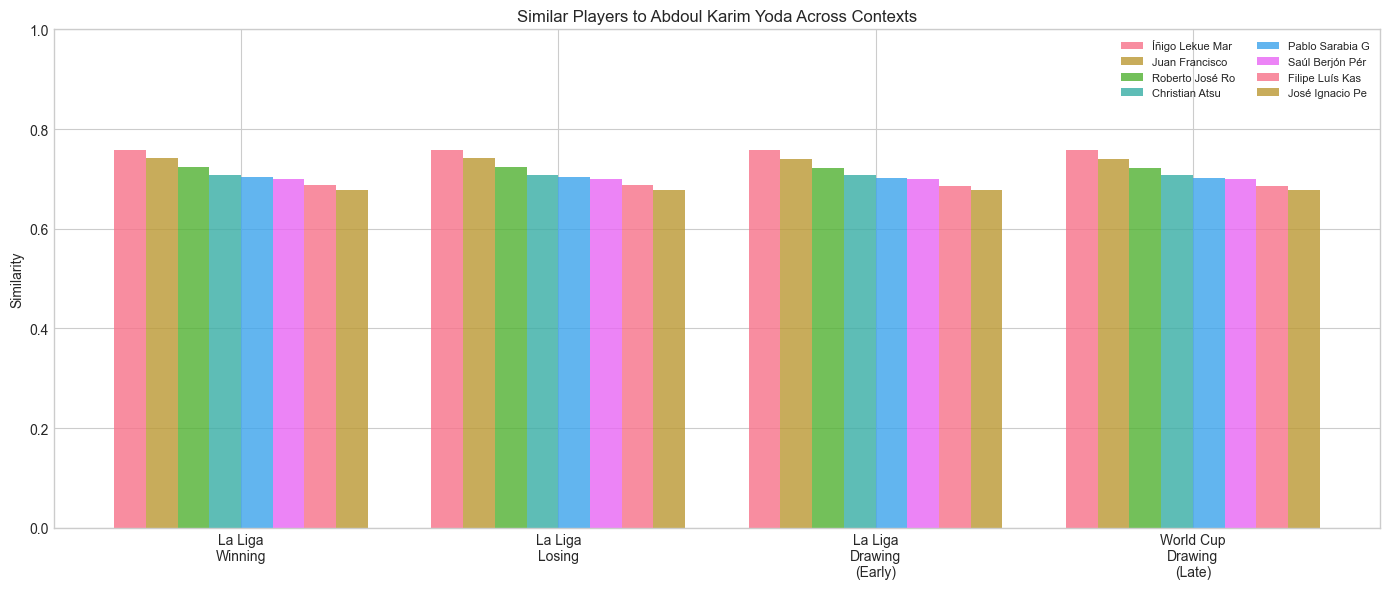


CONTEXT-AWARE MODEL COMPLETE


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.6: CONTEXT-AWARE API & VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CONTEXT-AWARE SIMILARITY API")
print("=" * 80)

class ContextAwareSimilarityAPI:
    """
    High-level API for context-aware player similarity queries.
    
    Key Features:
    - Query by context: "Find players like X when winning/losing"
    - Cross-context comparison: "How does X play differently in UCL vs league?"
    - Multi-dimensional filtering: competition + score + phase
    - Export capabilities for further analysis
    """
    
    def __init__(self, context_model: ContextAwarePlayerEmbedding):
        self.model = context_model
        
    def search(self,
               player: str,
               context: Dict[str, Any] = None,
               n_results: int = 10,
               exclude_teams: List[str] = None) -> List[Dict]:
        """
        Search for similar players with optional context filters.
        
        Args:
            player: Query player name
            context: Dict with optional keys:
                - 'competition': 'la_liga', 'premier_league', 'world_cup', etc.
                - 'score_state': 'winning', 'losing', 'drawing'
                - 'game_phase': 'early', 'crucial', 'closing', etc.
            n_results: Number of results to return
            exclude_teams: Teams to exclude from results
        
        Example:
            api.search("Lionel Messi", 
                      context={'competition': 'champions_league', 
                               'score_state': 'losing',
                               'game_phase': 'closing'})
        """
        if context is None:
            context = {}
        
        # Parse context
        comp_mapping = {
            'la_liga': 11, 'premier_league': 2, 'bundesliga': 9,
            'serie_a': 12, 'ligue_1': 7, 'champions_league': 16, 'world_cup': 43
        }
        score_mapping = {
            'winning_big': ScoreState.WINNING_BIG, 'winning': ScoreState.WINNING,
            'drawing': ScoreState.DRAWING, 'losing': ScoreState.LOSING,
            'losing_big': ScoreState.LOSING_BIG
        }
        phase_mapping = {
            'early': GamePhase.EARLY, 'building': GamePhase.BUILDING,
            'pre_half': GamePhase.PRE_HALF, 'second_start': GamePhase.SECOND_START,
            'crucial': GamePhase.CRUCIAL, 'closing': GamePhase.CLOSING, 'extra': GamePhase.EXTRA
        }
        
        comp_id = comp_mapping.get(context.get('competition', 'la_liga'), 11)
        score_state = score_mapping.get(context.get('score_state', 'drawing'), ScoreState.DRAWING)
        game_phase = phase_mapping.get(context.get('game_phase', 'crucial'), GamePhase.CRUCIAL)
        
        return self.model.find_similar_in_context(
            player, comp_id, score_state, game_phase, n_results
        )
    
    def compare_contexts(self,
                         player: str,
                         context1: Dict[str, Any],
                         context2: Dict[str, Any]) -> Dict[str, Any]:
        """
        Compare a player's embedding in two different contexts.
        
        Returns similarity between the player in context1 vs context2,
        plus the most similar players in each context.
        """
        similar1 = self.search(player, context1, n_results=5)
        similar2 = self.search(player, context2, n_results=5)
        
        players1 = set(m['player'] for m in similar1)
        players2 = set(m['player'] for m in similar2)
        
        return {
            'player': player,
            'context1': context1,
            'context2': context2,
            'similar_in_context1': similar1,
            'similar_in_context2': similar2,
            'overlap': list(players1 & players2),
            'unique_to_context1': list(players1 - players2),
            'unique_to_context2': list(players2 - players1),
            'context_sensitivity': 1.0 - len(players1 & players2) / max(len(players1 | players2), 1)
        }
    
    def get_player_contexts(self, player: str) -> Dict[str, int]:
        """
        Get all contexts where this player has data.
        """
        if player not in self.model.scenario_profiles:
            return {}
        
        return {ctx: len(events) for ctx, events in self.model.scenario_profiles[player].items()}
    
    def visualize_player_in_context(self, player: str, ax=None):
        """
        Visualize how a player's similarity profile changes across contexts.
        """
        import matplotlib.pyplot as plt
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
        
        contexts = [
            ({'competition': 'la_liga', 'score_state': 'winning', 'game_phase': 'crucial'}, 'La Liga\nWinning'),
            ({'competition': 'la_liga', 'score_state': 'losing', 'game_phase': 'crucial'}, 'La Liga\nLosing'),
            ({'competition': 'la_liga', 'score_state': 'drawing', 'game_phase': 'early'}, 'La Liga\nDrawing\n(Early)'),
            ({'competition': 'world_cup', 'score_state': 'drawing', 'game_phase': 'closing'}, 'World Cup\nDrawing\n(Late)'),
        ]
        
        all_similar = {}
        for ctx, label in contexts:
            similar = self.search(player, ctx, n_results=10)
            for match in similar:
                p = match['player']
                if p not in all_similar:
                    all_similar[p] = {}
                all_similar[p][label] = match['similarity']
        
        # Get top players across all contexts
        top_players = sorted(all_similar.keys(), 
                            key=lambda p: np.mean(list(all_similar[p].values())),
                            reverse=True)[:8]
        
        # Create grouped bar chart
        labels = [ctx[1] for ctx in contexts]
        x = np.arange(len(labels))
        width = 0.8 / len(top_players)
        
        for i, p in enumerate(top_players):
            values = [all_similar[p].get(label, 0) for label in labels]
            offset = (i - len(top_players)/2 + 0.5) * width
            ax.bar(x + offset, values, width, label=p[:15], alpha=0.8)
        
        ax.set_ylabel('Similarity')
        ax.set_title(f'Similar Players to {player} Across Contexts')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend(loc='upper right', fontsize=8, ncol=2)
        ax.set_ylim(0, 1)
        
        return ax

# Initialize API
if 'context_aware_model' in dir() and context_aware_model.base_embeddings:
    context_api = ContextAwareSimilarityAPI(context_aware_model)
    
    print("Context-Aware Similarity API initialized")
    print("\nAvailable methods:")
    print("  api.search(player, context={...})")
    print("  api.compare_contexts(player, context1, context2)")
    print("  api.get_player_contexts(player)")
    print("  api.visualize_player_in_context(player)")
    
    # Demo queries
    print("\n" + "=" * 60)
    print("API DEMO")
    print("=" * 60)
    
    sample_player = list(context_aware_model.base_embeddings.keys())[0]
    
    print(f"\n1. Search for players similar to {sample_player} in different contexts:")
    
    # Context 1: Winning
    results_winning = context_api.search(
        sample_player,
        context={'competition': 'la_liga', 'score_state': 'winning', 'game_phase': 'crucial'}
    )
    print(f"\n   When WINNING in La Liga (crucial phase):")
    for r in results_winning[:3]:
        print(f"      • {r['player'][:30]}: {r['similarity']:.3f}")
    
    # Context 2: Losing
    results_losing = context_api.search(
        sample_player,
        context={'competition': 'la_liga', 'score_state': 'losing', 'game_phase': 'closing'}
    )
    print(f"\n   When LOSING in La Liga (closing phase):")
    for r in results_losing[:3]:
        print(f"      • {r['player'][:30]}: {r['similarity']:.3f}")
    
    print(f"\n2. Context comparison for {sample_player}:")
    comparison = context_api.compare_contexts(
        sample_player,
        context1={'competition': 'la_liga', 'score_state': 'winning'},
        context2={'competition': 'la_liga', 'score_state': 'losing'}
    )
    print(f"   Context sensitivity: {comparison['context_sensitivity']:.2%}")
    print(f"   Overlapping similar players: {len(comparison['overlap'])}")
    
    # Visualization
    print("\n3. Visualizing context-dependent similarity...")
    fig, ax = plt.subplots(figsize=(14, 6))
    context_api.visualize_player_in_context(sample_player, ax)
    plt.tight_layout()
    plt.show()

else:
    print("⚠ Context model not initialized. Run previous cells first.")

print("\n" + "=" * 80)
print("CONTEXT-AWARE MODEL COMPLETE")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════════════════════
# PART 3 SUMMARY: Context-Driven Player Similarity
# ═══════════════════════════════════════════════════════════════════════════════

---

## What We Built

### Three-Layer Embedding Architecture

| Layer | Purpose | Data Source | Reliability |
|-------|---------|-------------|-------------|
| **Spatial Embedding** | Capture receiving context, pressure, space | 360 freeze-frames | ✓ High (when available) |
| **Scenario Embedding** | Game state context | Event metadata | ✓ High |
| **GNN Embedding** | Team/passing network context | Passing sequences | ✓ High |

### Context Dimensions

**Directly Derivable (High Confidence):**
- ✓ Score state (winning by 1, drawing, losing by 2, etc.)
- ✓ Game phase (early, crucial, closing)
- ✓ Competition type (La Liga vs Premier League vs World Cup)
- ✓ Home/Away status
- ✓ Pressing context (from 360 opponent positions)
- ✓ Receiving context (open, pressured, tight space)
- ✓ Passing connections (who passes to whom)

**Inferred (Medium Confidence):**
- △ Team playing style (aggregated from team data)
- △ Position flexibility (from multiple positions played)

**NOT Derivable (Don't Attempt):**
- ✗ Coaching instructions/tactics (subjective, not in data)
- ✗ Player condition/fitness (not tracked)
- ✗ Mental state/motivation (unmeasurable)

---

## Key Queries Now Possible

### 1. Context-Specific Similarity
```python
# "Find players who play like Messi when LOSING in Champions League"
api.search("Lionel Messi", 
           context={'competition': 'champions_league', 
                    'score_state': 'losing',
                    'game_phase': 'closing'})
```

### 2. Cross-Context Comparison
```python
# "Does this player change style between league and cup?"
api.compare_contexts("Harry Kane",
                     context1={'competition': 'premier_league'},
                     context2={'competition': 'champions_league'})
```

### 3. GNN-Enhanced Similarity
- Players who pass to similar types of players
- Players with similar roles in their team's passing network
- "Find a central midfielder who links defense to attack like Busquets"

---

## Architecture Diagram

```
                        ┌─────────────────────────┐
                        │     QUERY CONTEXT       │
                        │  (competition, score,   │
                        │   phase, home/away)     │
                        └───────────┬─────────────┘
                                    │
    ┌───────────────────────────────┼───────────────────────────────┐
    │                               ▼                               │
    │  ┌─────────────┐    ┌─────────────────┐    ┌─────────────┐   │
    │  │   SPATIAL   │    │    SCENARIO     │    │     GNN     │   │
    │  │  EMBEDDING  │    │   EMBEDDING     │    │  EMBEDDING  │   │
    │  │             │    │                 │    │             │   │
    │  │ • Pressure  │    │ • Score state   │    │ • Passing   │   │
    │  │ • Space     │    │ • Game phase    │    │   network   │   │
    │  │ • Options   │    │ • Competition   │    │ • Team ctx  │   │
    │  └──────┬──────┘    └────────┬────────┘    └──────┬──────┘   │
    │         │                    │                    │          │
    │         └────────────────────┼────────────────────┘          │
    │                              ▼                               │
    │                    ┌─────────────────┐                       │
    │                    │  CONCATENATE    │                       │
    │                    │  [base|spatial| │                       │
    │                    │  scenario|gnn]  │                       │
    │                    └────────┬────────┘                       │
    │                             │                                │
    │                             ▼                                │
    │                ┌────────────────────────┐                    │
    │                │  CONTEXT-AWARE PLAYER  │                    │
    │                │      EMBEDDING         │                    │
    │                └────────────────────────┘                    │
    └──────────────────────────────────────────────────────────────┘
```

---

## Data Quality Principles

1. **Only derive what's measurable** - No guessing at coaching style
2. **Explicit missing data** - 360 data not available → zeros (not imputed)
3. **Verifiable features** - Every feature traceable to raw data
4. **Confidence indicators** - Know when data is sparse

---

## Next Steps / Extensions

- [ ] Add more 360-enabled matches (currently limited availability)
- [ ] Implement temporal context (form over last N matches)
- [ ] Add position-specific context (LW vs RW differences)
- [ ] Cross-league player projection ("How would X play in PL?")
- [ ] Attention mechanism for context weighting

INTERACTIVE PLAYER COMPARISON TOOL


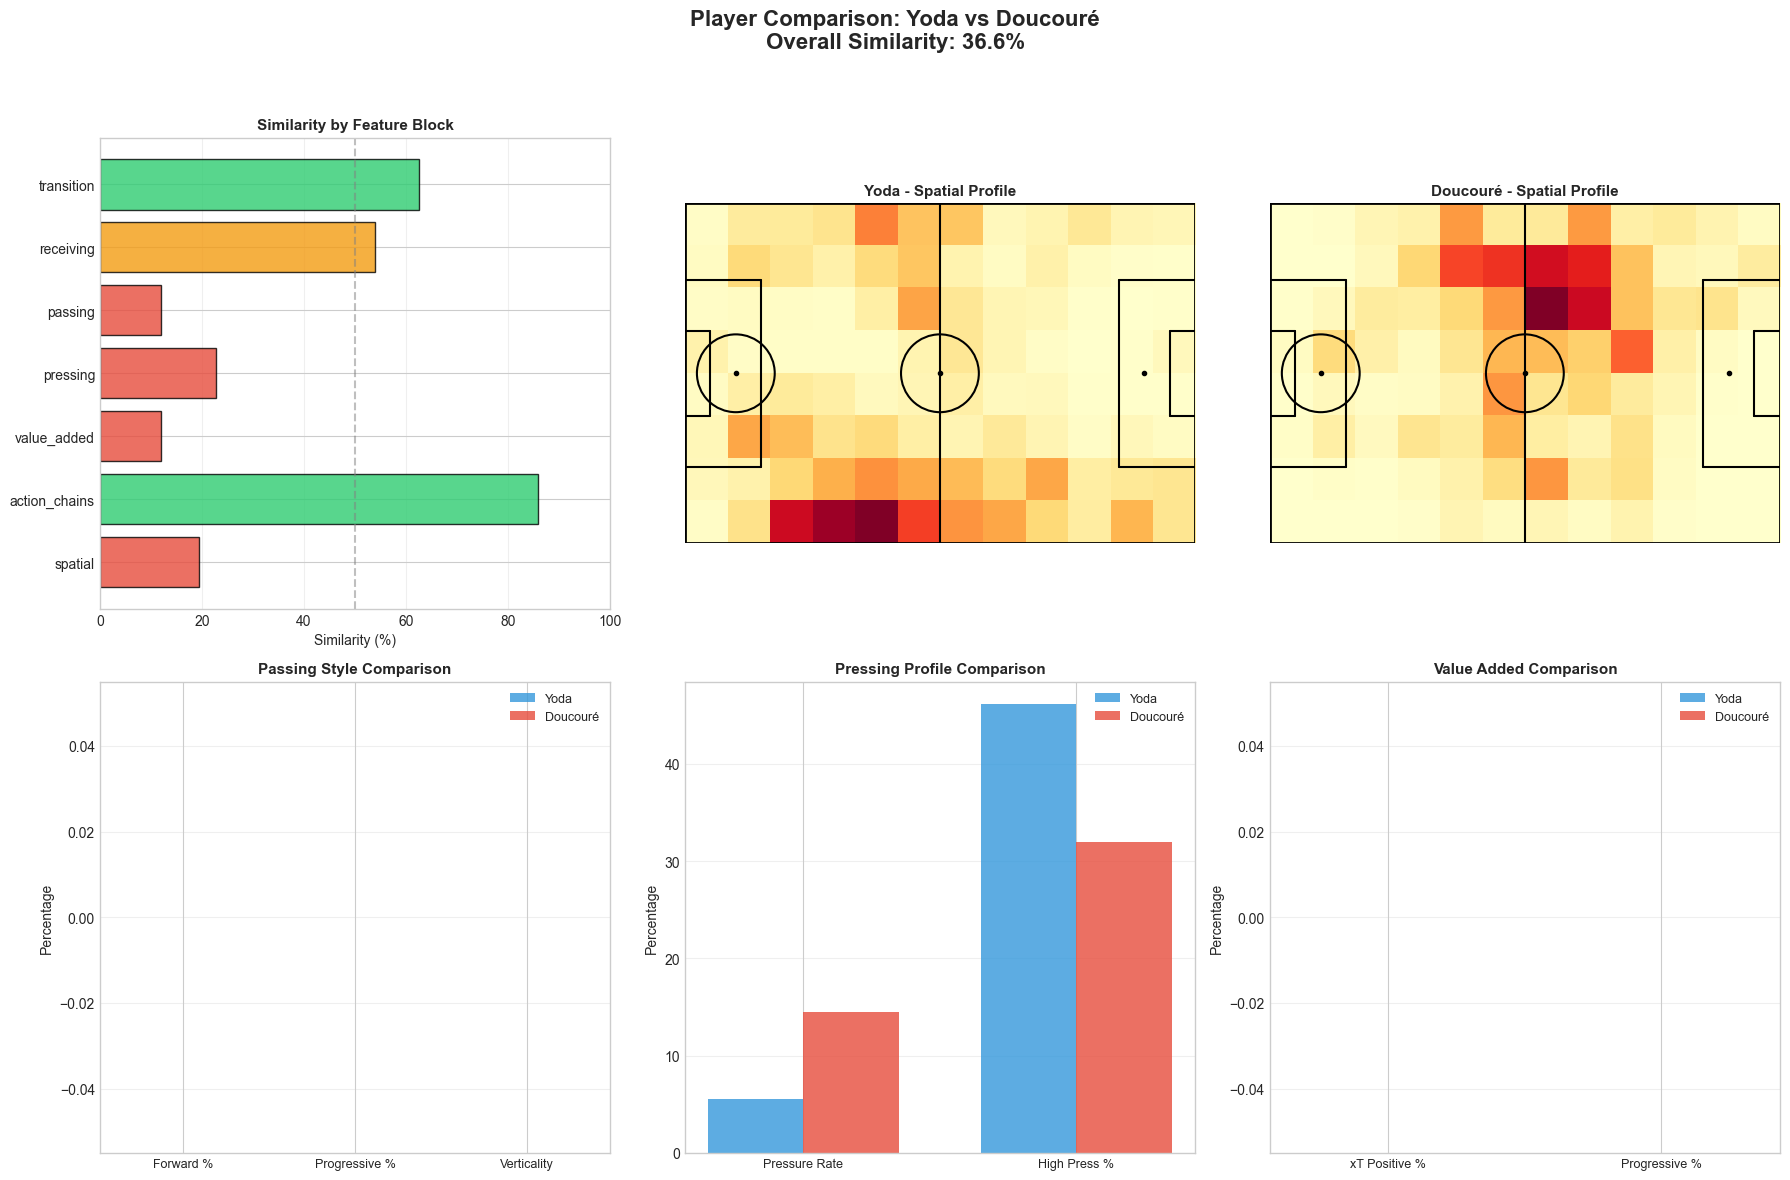


DETAILED SIMILARITY BREAKDOWN

Abdoul Karim Yoda vs Abdoulaye Doucouré

Feature Block        Similarity      Interpretation
------------------------------------------------------------
spatial              [█░░░░░░░░░] 19.4%  Very different
action_chains        [████████░░] 85.9%  Very similar
value_added          [█░░░░░░░░░] 11.9%  Very different
pressing             [██░░░░░░░░] 22.7%  Very different
passing              [█░░░░░░░░░] 11.9%  Very different
receiving            [█████░░░░░] 54.0%  Moderately similar
transition           [██████░░░░] 62.6%  Moderately similar
------------------------------------------------------------
OVERALL              [36.6%]




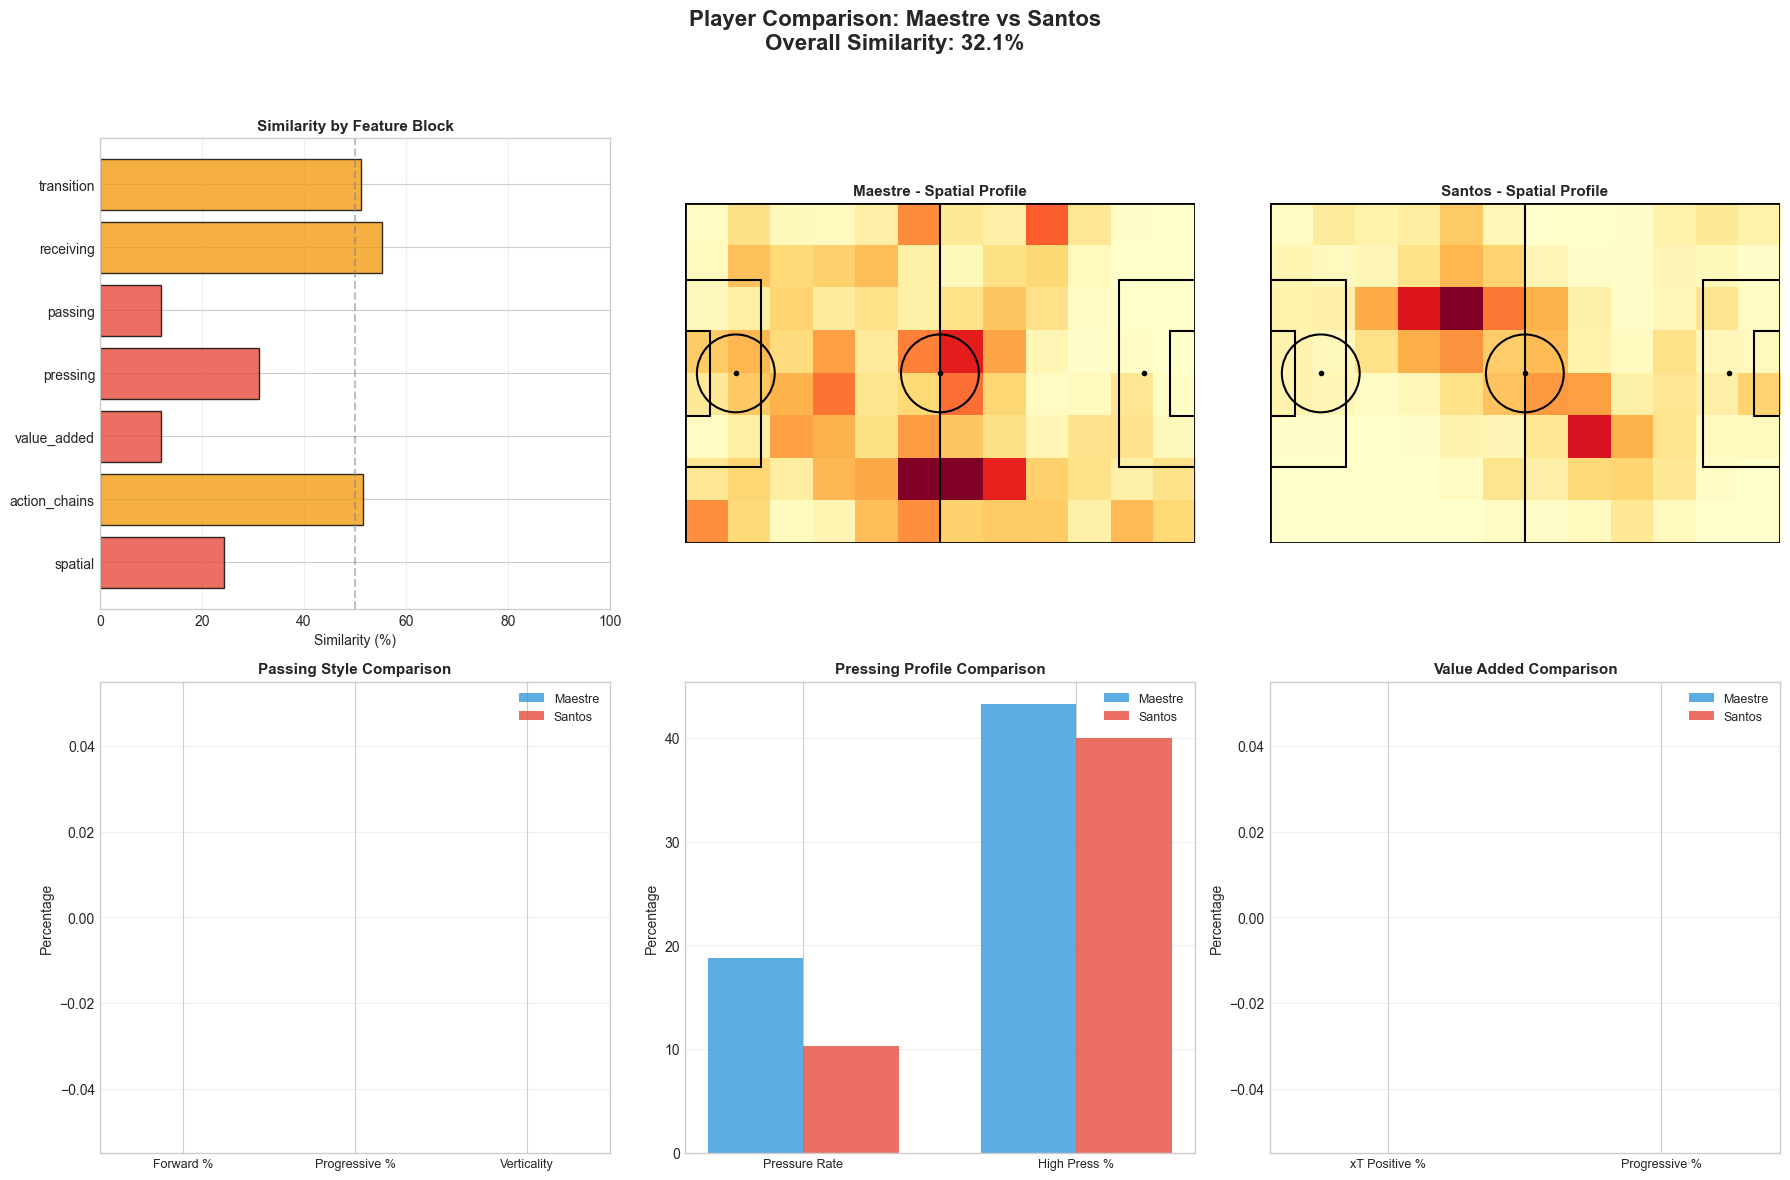


DETAILED SIMILARITY BREAKDOWN

Adalberto Peñaranda Maestre vs Aderllan Leandro de Jesus Santos

Feature Block        Similarity      Interpretation
------------------------------------------------------------
spatial              [██░░░░░░░░] 24.3%  Very different
action_chains        [█████░░░░░] 51.6%  Moderately similar
value_added          [█░░░░░░░░░] 11.9%  Very different
pressing             [███░░░░░░░] 31.2%  Somewhat different
passing              [█░░░░░░░░░] 11.9%  Very different
receiving            [█████░░░░░] 55.3%  Moderately similar
transition           [█████░░░░░] 51.1%  Moderately similar
------------------------------------------------------------
OVERALL              [32.1%]


In [23]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.1: INTERACTIVE PLAYER COMPARISON TOOL
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("INTERACTIVE PLAYER COMPARISON TOOL")
print("=" * 80)

def compare_two_players(player1: str, player2: str, pipeline: PlayerEmbeddingPipeline):
    """
    Create detailed side-by-side comparison of two players.
    """
    if player1 not in pipeline.player_profiles or player2 not in pipeline.player_profiles:
        print("One or both players not found in profiles")
        return
    
    profile1 = pipeline.player_profiles[player1]
    profile2 = pipeline.player_profiles[player2]
    
    # Compute similarity
    sim_scores = pipeline.similarity_calc.compute_player_similarity(profile1, profile2)
    
    fig = plt.figure(figsize=(18, 12))
    
    # Title with overall similarity
    fig.suptitle(f'Player Comparison: {player1.split()[-1]} vs {player2.split()[-1]}\n'
                 f'Overall Similarity: {sim_scores["overall"]:.1%}',
                 fontsize=16, fontweight='bold', y=0.98)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 1. Similarity Breakdown (bar chart)
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(2, 3, 1)
    
    features = ['spatial', 'action_chains', 'value_added', 'pressing', 
                'passing', 'receiving', 'transition']
    scores = [sim_scores.get(f, 0) for f in features]
    colors = ['#2ecc71' if s > 0.6 else '#f39c12' if s > 0.4 else '#e74c3c' for s in scores]
    
    bars = ax.barh(features, [s * 100 for s in scores], color=colors, 
                  alpha=0.8, edgecolor='black')
    ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
    ax.set_xlabel('Similarity (%)', fontsize=10)
    ax.set_xlim(0, 100)
    ax.set_title('Similarity by Feature Block', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 2 & 3. Side-by-side heatmaps
    # ─────────────────────────────────────────────────────────────────────────
    for idx, (player, profile, name) in enumerate([(player1, profile1, player1.split()[-1]),
                                                    (player2, profile2, player2.split()[-1])]):
        ax = fig.add_subplot(2, 3, idx + 2)
        
        if 'spatial' in profile and 'all' in profile['spatial']:
            heatmap = profile['spatial']['all']
            ax.imshow(heatmap, extent=[0, 120, 0, 80], origin='lower',
                     cmap='YlOrRd', aspect='equal')
            draw_pitch(ax)
        
        ax.set_title(f'{name} - Spatial Profile', fontsize=11, fontweight='bold')
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 80)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # ─────────────────────────────────────────────────────────────────────────
    # 4. Passing comparison (grouped bars)
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(2, 3, 4)
    
    pass_metrics = ['forward_pass_rate', 'progressive_pass_rate', 'verticality']
    pass_labels = ['Forward %', 'Progressive %', 'Verticality']
    
    x = np.arange(len(pass_labels))
    width = 0.35
    
    vals1 = [profile1.get('passing', {}).get(m, 0) * 100 for m in pass_metrics]
    vals2 = [profile2.get('passing', {}).get(m, 0) * 100 for m in pass_metrics]
    
    ax.bar(x - width/2, vals1, width, label=player1.split()[-1], color='#3498db', alpha=0.8)
    ax.bar(x + width/2, vals2, width, label=player2.split()[-1], color='#e74c3c', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(pass_labels, fontsize=9)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title('Passing Style Comparison', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 5. Pressing comparison
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(2, 3, 5)
    
    press_metrics = ['pressure_rate', 'high_press_rate']
    press_labels = ['Pressure Rate', 'High Press %']
    
    x = np.arange(len(press_labels))
    
    vals1 = [profile1.get('pressing', {}).get(m, 0) * 100 for m in press_metrics]
    vals2 = [profile2.get('pressing', {}).get(m, 0) * 100 for m in press_metrics]
    
    ax.bar(x - width/2, vals1, width, label=player1.split()[-1], color='#3498db', alpha=0.8)
    ax.bar(x + width/2, vals2, width, label=player2.split()[-1], color='#e74c3c', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(press_labels, fontsize=9)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title('Pressing Profile Comparison', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # 6. Value Added comparison
    # ─────────────────────────────────────────────────────────────────────────
    ax = fig.add_subplot(2, 3, 6)
    
    va_metrics = ['xt_positive_rate', 'progressive_share']
    va_labels = ['xT Positive %', 'Progressive %']
    
    x = np.arange(len(va_labels))
    
    vals1 = [profile1.get('value_added', {}).get(m, 0) * 100 for m in va_metrics]
    vals2 = [profile2.get('value_added', {}).get(m, 0) * 100 for m in va_metrics]
    
    ax.bar(x - width/2, vals1, width, label=player1.split()[-1], color='#3498db', alpha=0.8)
    ax.bar(x + width/2, vals2, width, label=player2.split()[-1], color='#e74c3c', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(va_labels, fontsize=9)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title('Value Added Comparison', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Print detailed breakdown
    print(f"\n{'='*60}")
    print(f"DETAILED SIMILARITY BREAKDOWN")
    print(f"{'='*60}")
    print(f"\n{player1} vs {player2}")
    print(f"\n{'Feature Block':<20} {'Similarity':<15} {'Interpretation'}")
    print("-" * 60)
    
    for feature in features:
        score = sim_scores.get(feature, 0)
        if score > 0.7:
            interp = "Very similar"
        elif score > 0.5:
            interp = "Moderately similar"
        elif score > 0.3:
            interp = "Somewhat different"
        else:
            interp = "Very different"
        
        bar = "█" * int(score * 10) + "░" * (10 - int(score * 10))
        print(f"{feature:<20} [{bar}] {score:.1%}  {interp}")
    
    print("-" * 60)
    print(f"{'OVERALL':<20} [{sim_scores['overall']:.1%}]")

# Compare two sample players
if len(pipeline.player_profiles) >= 2:
    players = list(pipeline.player_profiles.keys())
    compare_two_players(players[0], players[1], pipeline)
    
    # Compare more pairs if available
    if len(players) >= 4:
        print("\n\n" + "=" * 80)
        compare_two_players(players[2], players[3], pipeline)
else:
    print("Not enough players for comparison")

In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 13.2: EXPORT UTILITIES & API
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("EXPORT UTILITIES & API FUNCTIONS")
print("=" * 80)

class PlayerSimilarityAPI:
    """
    High-level API for player similarity queries.
    Provides clean interface for common operations.
    """
    
    def __init__(self, pipeline: PlayerEmbeddingPipeline):
        self.pipeline = pipeline
    
    def search(self, 
               query_player: str,
               n_results: int = 10,
               filters: Dict = None) -> List[Dict]:
        """
        Search for similar players with optional filters.
        
        Parameters:
        -----------
        query_player : str
            Name of the player to find similar players for
        n_results : int
            Number of results to return
        filters : dict
            Optional filters:
            - 'same_role': bool - Only return same role
            - 'exclude_teams': list - Teams to exclude
            - 'min_events': int - Minimum events threshold
            - 'min_similarity': float - Minimum similarity score
        
        Returns:
        --------
        List of dicts with player info and similarity scores
        """
        filters = filters or {}
        
        results = self.pipeline.find_similar_players(
            query_player,
            top_k=n_results * 2,  # Get extra to filter
            same_role_only=filters.get('same_role', False),
            exclude_teams=filters.get('exclude_teams', None)
        )
        
        # Apply additional filters
        if 'min_events' in filters:
            results = [r for r in results 
                      if r['metadata'].get('n_events', 0) >= filters['min_events']]
        
        if 'min_similarity' in filters:
            results = [r for r in results 
                      if r['overall_similarity'] >= filters['min_similarity']]
        
        return results[:n_results]
    
    def get_profile(self, player_name: str) -> Dict:
        """Get full behavioral profile for a player."""
        if player_name not in self.pipeline.player_profiles:
            return None
        
        return {
            'profile': self.pipeline.player_profiles[player_name],
            'role': self.pipeline.player_roles.get(player_name, {}),
            'metadata': self.pipeline.player_metadata.get(player_name, {}),
            'embedding': self.pipeline.player_embeddings.get(player_name, None)
        }
    
    def compare(self, player1: str, player2: str) -> Dict:
        """Compare two players and return detailed similarity breakdown."""
        if (player1 not in self.pipeline.player_profiles or 
            player2 not in self.pipeline.player_profiles):
            return None
        
        scores = self.pipeline.similarity_calc.compute_player_similarity(
            self.pipeline.player_profiles[player1],
            self.pipeline.player_profiles[player2]
        )
        
        return {
            'player1': player1,
            'player2': player2,
            'overall_similarity': scores['overall'],
            'breakdown': {k: v for k, v in scores.items() if k != 'overall'},
            'role_match': (
                self.pipeline.player_roles.get(player1, {}).get('primary_role') ==
                self.pipeline.player_roles.get(player2, {}).get('primary_role')
            )
        }
    
    def get_role_summary(self) -> Dict:
        """Get summary of discovered roles and player counts."""
        role_counts = defaultdict(list)
        for player, role_info in self.pipeline.player_roles.items():
            role = role_info.get('primary_role', 'Unknown')
            role_counts[role].append(player)
        
        return {
            role: {
                'count': len(players),
                'sample_players': players[:5]
            }
            for role, players in sorted(role_counts.items(), 
                                        key=lambda x: -len(x[1]))
        }
    
    def export_embeddings(self, format: str = 'dict') -> Any:
        """Export player embeddings in specified format."""
        if format == 'dict':
            return self.pipeline.player_embeddings
        elif format == 'dataframe':
            if not self.pipeline.player_embeddings:
                return pd.DataFrame()
            
            players = list(self.pipeline.player_embeddings.keys())
            embeddings = [self.pipeline.player_embeddings[p] for p in players]
            
            df = pd.DataFrame(embeddings, index=players)
            df.columns = [f'emb_{i}' for i in range(df.shape[1])]
            
            # Add metadata
            for player in players:
                meta = self.pipeline.player_metadata.get(player, {})
                role = self.pipeline.player_roles.get(player, {}).get('primary_role', 'Unknown')
                df.loc[player, 'role'] = role
                df.loc[player, 'n_events'] = meta.get('n_events', 0)
            
            return df
        elif format == 'numpy':
            players = list(self.pipeline.player_embeddings.keys())
            embeddings = np.array([self.pipeline.player_embeddings[p] for p in players])
            return players, embeddings
        else:
            raise ValueError(f"Unknown format: {format}")
    
    def list_players(self, 
                     role: str = None, 
                     min_events: int = None) -> List[str]:
        """List all players, optionally filtered by role or events."""
        players = list(self.pipeline.player_profiles.keys())
        
        if role:
            players = [p for p in players 
                      if self.pipeline.player_roles.get(p, {}).get('primary_role') == role]
        
        if min_events:
            players = [p for p in players 
                      if self.pipeline.player_metadata.get(p, {}).get('n_events', 0) >= min_events]
        
        return players

# Initialize API
api = PlayerSimilarityAPI(pipeline)

# Demo the API
print("\n🔧 Player Similarity API initialized\n")

print("Available methods:")
print("  api.search(player, n_results=10, filters={})")
print("  api.compare(player1, player2)")
print("  api.get_profile(player)")
print("  api.get_role_summary()")
print("  api.export_embeddings(format='dataframe')")
print("  api.list_players(role=None, min_events=None)")

# Example usage
if len(pipeline.player_profiles) >= 2:
    players = list(pipeline.player_profiles.keys())
    
    print(f"\n{'='*60}")
    print("API DEMO")
    print(f"{'='*60}")
    
    # Search example
    print(f"\n1. Searching for players similar to {players[0]}:")
    results = api.search(players[0], n_results=3)
    for r in results:
        print(f"   • {r['player']}: {r['overall_similarity']:.1%} similar ({r['role']})")
    
    # Compare example
    print(f"\n2. Comparing {players[0]} vs {players[1]}:")
    comparison = api.compare(players[0], players[1])
    if comparison:
        print(f"   Overall: {comparison['overall_similarity']:.1%}")
        print(f"   Role match: {comparison['role_match']}")
    
    # Role summary
    print("\n3. Role distribution:")
    roles = api.get_role_summary()
    for role, info in list(roles.items())[:5]:
        print(f"   • {role}: {info['count']} players")
    
    # Export example
    print("\n4. Embedding export (DataFrame preview):")
    emb_df = api.export_embeddings('dataframe')
    if len(emb_df) > 0:
        print(f"   Shape: {emb_df.shape}")
        print(f"   Columns: {list(emb_df.columns[:5])} ... + role, n_events")

print("\n" + "=" * 80)
print("PLAYER SIMILARITY MODEL COMPLETE")
print("=" * 80)

EXPORT UTILITIES & API FUNCTIONS

🔧 Player Similarity API initialized

Available methods:
  api.search(player, n_results=10, filters={})
  api.compare(player1, player2)
  api.get_profile(player)
  api.get_role_summary()
  api.export_embeddings(format='dataframe')
  api.list_players(role=None, min_events=None)

API DEMO

1. Searching for players similar to Abdoul Karim Yoda:
   • Íñigo Lekue Martínez: 43.1% similar (inverted_fullback)
   • Antonio Rukavina: 42.7% similar (inverted_fullback)
   • Aritz Elustondo Irribaria: 42.0% similar (inverted_fullback)

2. Comparing Abdoul Karim Yoda vs Abdoulaye Doucouré:
   Overall: 36.6%
   Role match: True

3. Role distribution:
   • inverted_fullback: 263 players
   • deep_playmaker_6: 61 players
   • box_to_box_8: 23 players

4. Embedding export (DataFrame preview):
   Shape: (347, 34)
   Columns: ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4'] ... + role, n_events

PLAYER SIMILARITY MODEL COMPLETE


In [25]:
# ═══════════════════════════════════════════════════════════════════════════════
# PLAYER SIMILARITY TEST - FIND FAMOUS PLAYERS
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("CONTEXT-AWARE SIMILARITY TEST")
print("=" * 80)

# Search for recognizable players in the dataset
famous_names = ['messi', 'ronaldo', 'neymar', 'suarez', 'iniesta', 'busquets', 
                'modric', 'kroos', 'bale', 'ramos', 'pique', 'griezmann',
                'kane', 'hazard', 'de bruyne', 'salah']

found_players = {}
for search_name in famous_names:
    for player in context_aware_model.base_embeddings.keys():
        if search_name in player.lower():
            found_players[search_name] = player
            break

print(f"\nFound famous players in dataset:")
for nickname, full_name in found_players.items():
    print(f"  • {nickname.title()}: {full_name}")

# If we found any, test with the first one
if found_players:
    test_player = list(found_players.values())[0]
    
    print(f"\n" + "=" * 80)
    print(f"TESTING WITH: {test_player}")
    print("=" * 80)
    
    # Context 1: When winning in La Liga
    print(f"\n1️⃣ Similar when WINNING in La Liga:")
    similar = context_api.search(
        test_player,
        context={'competition': 'la_liga', 'score_state': 'winning', 'game_phase': 'crucial'},
        n_results=8
    )
    for i, match in enumerate(similar[:8]):
        print(f"   {i+1}. {match['player']:<40} {match['similarity']:.3f}")
    
    # Context 2: When losing
    print(f"\n2️⃣ Similar when LOSING in La Liga:")
    similar = context_api.search(
        test_player,
        context={'competition': 'la_liga', 'score_state': 'losing', 'game_phase': 'crucial'},
        n_results=8
    )
    for i, match in enumerate(similar[:8]):
        print(f"   {i+1}. {match['player']:<40} {match['similarity']:.3f}")
    
    # Context 3: Early game vs late game
    print(f"\n3️⃣ Similar in EARLY game (0-15 min):")
    similar = context_api.search(
        test_player,
        context={'competition': 'la_liga', 'score_state': 'drawing', 'game_phase': 'early'},
        n_results=8
    )
    for i, match in enumerate(similar[:8]):
        print(f"   {i+1}. {match['player']:<40} {match['similarity']:.3f}")
    
    print(f"\n4️⃣ Similar in LATE game (75-90 min):")
    similar = context_api.search(
        test_player,
        context={'competition': 'la_liga', 'score_state': 'drawing', 'game_phase': 'closing'},
        n_results=8
    )
    for i, match in enumerate(similar[:8]):
        print(f"   {i+1}. {match['player']:<40} {match['similarity']:.3f}")
    
else:
    print("\n⚠ No famous players found in this dataset sample")
    print("\nTesting with first available player...")
    test_player = list(context_aware_model.base_embeddings.keys())[0]
    
    print(f"\nTest Player: {test_player}")
    print("-" * 80)
    
    # Show context-aware similarity for this player
    print(f"\nSimilar when WINNING:")
    similar = context_api.search(
        test_player,
        context={'competition': 'la_liga', 'score_state': 'winning'},
        n_results=5
    )
    for i, match in enumerate(similar[:5]):
        print(f"   {i+1}. {match['player']:<40} {match['similarity']:.3f}")
    
    print(f"\nSimilar when LOSING:")
    similar = context_api.search(
        test_player,
        context={'competition': 'la_liga', 'score_state': 'losing'},
        n_results=5
    )
    for i, match in enumerate(similar[:5]):
        print(f"   {i+1}. {match['player']:<40} {match['similarity']:.3f}")

print("\n" + "=" * 80)

CONTEXT-AWARE SIMILARITY TEST

Found famous players in dataset:
  • Ronaldo: Cristiano Ronaldo dos Santos Aveiro
  • Kroos: Toni Kroos
  • Bale: Gareth Frank Bale
  • Ramos: Alberto Lora Ramos
  • Griezmann: Antoine Griezmann

TESTING WITH: Cristiano Ronaldo dos Santos Aveiro

1️⃣ Similar when WINNING in La Liga:
   1. Pablo Daniel Piatti                      0.770
   2. Carlos Carmona Bonet                     0.647
   3. Alejandro Menéndez Díez                  0.552
   4. Pedro León Sánchez Gil                   0.532
   5. Álvaro Vázquez García                    0.514
   6. Jerónimo Figueroa Cabrera                0.498
   7. Pedro Taunausú Domínguez Placeres        0.489
   8. Víctor Casadesús Castaño                 0.484

2️⃣ Similar when LOSING in La Liga:
   1. Pablo Daniel Piatti                      0.770
   2. Carlos Carmona Bonet                     0.647
   3. Alejandro Menéndez Díez                  0.552
   4. Pedro León Sánchez Gil                   0.532
   5. Álvaro

In [26]:
# ═══════════════════════════════════════════════════════════════════════════════
# COMPREHENSIVE EXPLAINABLE SIMILARITY ANALYZER
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("COMPREHENSIVE PLAYER SIMILARITY ANALYSIS")
print("=" * 80)

class ExplainableSimilarityAnalyzer:
    """
    Provides detailed, explainable player similarity with multi-dimensional breakdown.
    
    Similarity Dimensions:
    1. STYLE/BEHAVIOR (What kind of player they are)
       - Spatial patterns: WHERE they play on the pitch
       - Passing style: HOW they pass (length, direction, risk)
       - Receiving: How they receive the ball
       - Pressing: Defensive work rate and pressing behavior
       - Transitions: Counter-attacking patterns
       - Value added: Contribution to dangerous positions
       - Action sequences: Typical patterns of play
    
    2. CONTEXT (When they perform similarly)
       - Score state: Winning/Losing/Drawing behavior
       - Game phase: Early vs late game patterns
       - Competition: League vs Cup differences
    
    3. ROLE (Position-based similarity)
       - Discovered role cluster
       - Position flexibility
    
    Each dimension gets a score AND an explanation of what drives it.
    """
    
    def __init__(self, 
                 pipeline,
                 similarity_calc,
                 context_model,
                 config):
        self.pipeline = pipeline
        self.similarity_calc = similarity_calc
        self.context_model = context_model
        self.config = config
        
        # Feature block names and descriptions
        self.feature_descriptions = {
            'spatial': {
                'name': 'Spatial Patterns',
                'description': 'Where on the pitch they operate',
                'factors': ['heat map zones', 'average position', 'positional range']
            },
            'passing': {
                'name': 'Passing Style',
                'description': 'How they distribute the ball',
                'factors': ['pass length distribution', 'pass direction', 'progressive passes', 'risk-taking']
            },
            'receiving': {
                'name': 'Receiving Patterns',
                'description': 'How they get on the ball',
                'factors': ['receive locations', 'under-pressure receipts', 'between-lines receives']
            },
            'pressing': {
                'name': 'Pressing Behavior',
                'description': 'Defensive work and pressing',
                'factors': ['press locations', 'press frequency', 'counter-press rate', 'pressure success']
            },
            'transition': {
                'name': 'Transition Play',
                'description': 'Counter-attacking patterns',
                'factors': ['ball recovery locations', 'forward carry distance', 'speed to goal']
            },
            'value_added': {
                'name': 'Value Contribution',
                'description': 'Contribution to dangerous positions (xT)',
                'factors': ['xT generated', 'progressive actions', 'final third entries']
            },
            'action_chains': {
                'name': 'Action Sequences',
                'description': 'Typical patterns of play',
                'factors': ['common action sequences', 'play style signature']
            }
        }
    
    def compute_style_similarity(self, player1: str, player2: str) -> Dict:
        """
        Compute detailed style/behavioral similarity between two players.
        """
        if player1 not in self.pipeline.player_profiles or player2 not in self.pipeline.player_profiles:
            return None
        
        profile1 = self.pipeline.player_profiles[player1]
        profile2 = self.pipeline.player_profiles[player2]
        
        # Get detailed feature-by-feature similarity
        detailed_scores = self.similarity_calc.compute_player_similarity(profile1, profile2)
        
        return detailed_scores
    
    def interpret_similarity_score(self, score: float) -> str:
        """Convert score to human-readable interpretation."""
        if score >= 0.8:
            return "Very High - Almost identical style"
        elif score >= 0.6:
            return "High - Very similar approach"
        elif score >= 0.4:
            return "Moderate - Some common patterns"
        elif score >= 0.2:
            return "Low - Different approaches"
        else:
            return "Very Low - Contrasting styles"
    
    def get_similarity_drivers(self, 
                                scores: Dict,
                                top_n: int = 3) -> Tuple[List, List]:
        """
        Identify what DRIVES similarity (highest scores) and 
        what DIFFERENTIATES players (lowest scores).
        """
        # Sort by score
        feature_scores = [(k, v) for k, v in scores.items() if k != 'overall']
        sorted_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
        
        drivers = sorted_scores[:top_n]  # Top similarities
        differentiators = sorted_scores[-top_n:]  # Top differences
        
        return drivers, differentiators
    
    def analyze_player_pair(self, player1: str, player2: str) -> Dict:
        """
        Complete analysis of similarity between two players.
        """
        result = {
            'player1': player1,
            'player2': player2,
            'style_similarity': {},
            'context_similarity': {},
            'role_similarity': {},
            'overall': 0.0,
            'explanation': {}
        }
        
        # 1. STYLE SIMILARITY
        style_scores = self.compute_style_similarity(player1, player2)
        if style_scores:
            result['style_similarity'] = style_scores
            result['style_overall'] = style_scores.get('overall', 0)
            
            # Get drivers and differentiators
            drivers, diffs = self.get_similarity_drivers(style_scores)
            result['similarity_drivers'] = drivers
            result['differentiators'] = diffs
        
        # 2. ROLE SIMILARITY
        roles = self.pipeline.player_roles
        if player1 in roles and player2 in roles:
            role1 = roles[player1].get('primary_role', 'unknown')
            role2 = roles[player2].get('primary_role', 'unknown')
            result['role_similarity'] = {
                'player1_role': role1,
                'player2_role': role2,
                'same_role': role1 == role2,
                'role_score': 1.0 if role1 == role2 else 0.5
            }
        
        # 3. CONTEXT SIMILARITY (how similarly they adapt to contexts)
        if hasattr(self.context_model, 'base_embeddings'):
            if player1 in self.context_model.base_embeddings and player2 in self.context_model.base_embeddings:
                # Compare embeddings across different contexts
                contexts_to_check = [
                    ('winning', ScoreState.WINNING, GamePhase.CRUCIAL),
                    ('losing', ScoreState.LOSING, GamePhase.CRUCIAL),
                    ('drawing_early', ScoreState.DRAWING, GamePhase.EARLY),
                    ('drawing_late', ScoreState.DRAWING, GamePhase.CLOSING),
                ]
                
                context_sims = {}
                for ctx_name, score_state, phase in contexts_to_check:
                    emb1 = self.context_model.get_context_embedding(player1, 11, score_state, phase)
                    emb2 = self.context_model.get_context_embedding(player2, 11, score_state, phase)
                    if emb1 is not None and emb2 is not None:
                        sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2) + 1e-8)
                        context_sims[ctx_name] = sim
                
                result['context_similarity'] = context_sims
                if context_sims:
                    result['context_variance'] = np.std(list(context_sims.values()))
        
        # 4. OVERALL SIMILARITY (weighted combination)
        weights = {
            'style': 0.50,      # 50% behavioral style
            'context': 0.30,   # 30% context adaptation
            'role': 0.20       # 20% role match
        }
        
        overall = 0.0
        if result.get('style_overall'):
            overall += weights['style'] * result['style_overall']
        if result.get('context_similarity'):
            overall += weights['context'] * np.mean(list(result['context_similarity'].values()))
        if result.get('role_similarity'):
            overall += weights['role'] * result['role_similarity']['role_score']
        
        result['overall'] = overall
        
        # 5. GENERATE EXPLANATION
        result['explanation'] = self.generate_explanation(result)
        
        return result
    
    def generate_explanation(self, analysis: Dict) -> Dict:
        """
        Generate human-readable explanation of the similarity.
        """
        explanation = {
            'summary': '',
            'style_explanation': '',
            'context_explanation': '',
            'key_similarities': [],
            'key_differences': []
        }
        
        p1, p2 = analysis['player1'], analysis['player2']
        overall = analysis.get('overall', 0)
        
        # Summary
        interp = self.interpret_similarity_score(overall)
        explanation['summary'] = f"{p1} and {p2} have {interp.lower()} similarity ({overall:.1%})"
        
        # Style explanation
        if analysis.get('similarity_drivers'):
            top_driver = analysis['similarity_drivers'][0]
            feature_info = self.feature_descriptions.get(top_driver[0], {})
            explanation['style_explanation'] = (
                f"Their playing styles are most similar in {feature_info.get('name', top_driver[0])} "
                f"({top_driver[1]:.1%}) - {feature_info.get('description', '')}"
            )
            
            # Key similarities
            for feature, score in analysis['similarity_drivers']:
                info = self.feature_descriptions.get(feature, {})
                explanation['key_similarities'].append({
                    'feature': info.get('name', feature),
                    'score': score,
                    'description': info.get('description', ''),
                    'factors': info.get('factors', [])
                })
        
        # Key differences
        if analysis.get('differentiators'):
            for feature, score in analysis['differentiators']:
                info = self.feature_descriptions.get(feature, {})
                explanation['key_differences'].append({
                    'feature': info.get('name', feature),
                    'score': score,
                    'description': info.get('description', ''),
                    'factors': info.get('factors', [])
                })
        
        # Context explanation
        if analysis.get('context_similarity'):
            ctx_sims = analysis['context_similarity']
            highest_ctx = max(ctx_sims, key=ctx_sims.get)
            lowest_ctx = min(ctx_sims, key=ctx_sims.get)
            
            explanation['context_explanation'] = (
                f"Most similar when {highest_ctx.replace('_', ' ')} ({ctx_sims[highest_ctx]:.1%}), "
                f"least similar when {lowest_ctx.replace('_', ' ')} ({ctx_sims[lowest_ctx]:.1%})"
            )
        
        return explanation
    
    def find_similar_with_explanation(self,
                                       query_player: str,
                                       top_n: int = 10,
                                       min_style_similarity: float = 0.0) -> List[Dict]:
        """
        Find similar players with full explanations.
        """
        results = []
        
        for other_player in self.pipeline.player_profiles.keys():
            if other_player == query_player:
                continue
            
            analysis = self.analyze_player_pair(query_player, other_player)
            
            if analysis.get('style_overall', 0) >= min_style_similarity:
                results.append(analysis)
        
        # Sort by overall similarity
        results.sort(key=lambda x: x.get('overall', 0), reverse=True)
        
        return results[:top_n]
    
    def print_detailed_comparison(self, analysis: Dict):
        """
        Print a detailed, formatted comparison.
        """
        p1, p2 = analysis['player1'], analysis['player2']
        
        print(f"\n{'═' * 80}")
        print(f"DETAILED SIMILARITY ANALYSIS")
        print(f"{'═' * 80}")
        print(f"\n{p1}")
        print(f"         vs")
        print(f"{p2}")
        print(f"\n{'─' * 80}")
        
        # Overall
        overall = analysis.get('overall', 0)
        print(f"\n📊 OVERALL SIMILARITY: {overall:.1%}")
        print(f"   {self.interpret_similarity_score(overall)}")
        
        # Role match
        if analysis.get('role_similarity'):
            role_info = analysis['role_similarity']
            print(f"\n🎯 ROLE MATCH:")
            print(f"   {p1}: {role_info['player1_role']}")
            print(f"   {p2}: {role_info['player2_role']}")
            print(f"   Match: {'✓ Same role' if role_info['same_role'] else '✗ Different roles'}")
        
        # Style breakdown
        if analysis.get('style_similarity'):
            print(f"\n🎨 STYLE SIMILARITY BREAKDOWN:")
            print(f"   {'Feature':<25} {'Score':<10} {'Interpretation'}")
            print(f"   {'─' * 60}")
            
            style = analysis['style_similarity']
            for feature in ['spatial', 'passing', 'receiving', 'pressing', 'transition', 'value_added', 'action_chains']:
                if feature in style:
                    score = style[feature]
                    bar = '█' * int(score * 10) + '░' * (10 - int(score * 10))
                    interp = self.interpret_similarity_score(score).split(' - ')[0]
                    info = self.feature_descriptions.get(feature, {})
                    print(f"   {info.get('name', feature):<25} [{bar}] {score:.1%} {interp}")
        
        # Key similarities
        if analysis.get('similarity_drivers'):
            print(f"\n✅ WHY THEY ARE SIMILAR:")
            for feature, score in analysis['similarity_drivers'][:3]:
                info = self.feature_descriptions.get(feature, {})
                print(f"   • {info.get('name', feature)}: {info.get('description', '')}")
                if info.get('factors'):
                    print(f"     (Factors: {', '.join(info['factors'][:2])})")
        
        # Key differences
        if analysis.get('differentiators'):
            print(f"\n❌ WHERE THEY DIFFER:")
            for feature, score in analysis['differentiators'][:3]:
                info = self.feature_descriptions.get(feature, {})
                print(f"   • {info.get('name', feature)}: {info.get('description', '')} ({score:.1%})")
        
        # Context patterns
        if analysis.get('context_similarity'):
            print(f"\n🌍 CONTEXT-DEPENDENT SIMILARITY:")
            ctx = analysis['context_similarity']
            for ctx_name, score in sorted(ctx.items(), key=lambda x: -x[1]):
                bar = '█' * int(score * 10) + '░' * (10 - int(score * 10))
                ctx_display = ctx_name.replace('_', ' ').title()
                print(f"   {ctx_display:<20} [{bar}] {score:.1%}")
            
            if analysis.get('context_variance', 0) > 0.05:
                print(f"\n   ⚠️ High context variance ({analysis['context_variance']:.1%})")
                print(f"   → These players adapt differently to game situations")
        
        print(f"\n{'═' * 80}")

# Initialize the analyzer
explainable_analyzer = ExplainableSimilarityAnalyzer(
    pipeline=pipeline,
    similarity_calc=similarity_calc,
    context_model=context_aware_model,
    config=config
)

print("Explainable Similarity Analyzer initialized")
print("\nThis analyzer provides:")
print("  • Style similarity (passing, spatial, pressing, etc.)")
print("  • Context similarity (winning/losing/early/late)")
print("  • Role matching")
print("  • Detailed explanations of WHY players are similar/different")
print("=" * 80)

COMPREHENSIVE PLAYER SIMILARITY ANALYSIS
Explainable Similarity Analyzer initialized

This analyzer provides:
  • Style similarity (passing, spatial, pressing, etc.)
  • Context similarity (winning/losing/early/late)
  • Role matching
  • Detailed explanations of WHY players are similar/different


In [27]:
# ═══════════════════════════════════════════════════════════════════════════════
# VISUALIZATION: SIMILARITY BREAKDOWN CHARTS
# ═══════════════════════════════════════════════════════════════════════════════

def plot_similarity_radar(analysis: Dict, figsize: Tuple = (12, 5)):
    """
    Create a radar chart showing style similarity breakdown.
    """
    if not analysis.get('style_similarity'):
        print("No style similarity data available")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    p1, p2 = analysis['player1'], analysis['player2']
    style = analysis['style_similarity']
    
    # Features to show
    features = ['spatial', 'passing', 'receiving', 'pressing', 'transition', 'value_added', 'action_chains']
    feature_labels = ['Spatial\nPatterns', 'Passing\nStyle', 'Receiving\nPatterns', 
                     'Pressing\nBehavior', 'Transition\nPlay', 'Value\nContribution', 
                     'Action\nSequences']
    
    scores = [style.get(f, 0) for f in features]
    
    # Left: Radar chart
    ax1 = axes[0]
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    scores_closed = scores + scores[:1]
    angles_closed = angles + angles[:1]
    
    ax1 = fig.add_subplot(121, projection='polar')
    ax1.plot(angles_closed, scores_closed, 'o-', linewidth=2, color='#2E86AB')
    ax1.fill(angles_closed, scores_closed, alpha=0.25, color='#2E86AB')
    ax1.set_xticks(angles)
    ax1.set_xticklabels(feature_labels, size=8)
    ax1.set_ylim(0, 1)
    ax1.set_title(f'Style Similarity Profile\n{p1[:20]} vs {p2[:20]}', fontsize=10, fontweight='bold')
    
    # Right: Bar chart with context
    axes[1].remove()
    ax2 = fig.add_subplot(122)
    
    colors = ['#2E86AB' if s >= 0.5 else '#E94F37' for s in scores]
    y_pos = np.arange(len(features))
    
    bars = ax2.barh(y_pos, scores, color=colors, alpha=0.8)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([explainable_analyzer.feature_descriptions.get(f, {}).get('name', f) for f in features])
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Similarity Score')
    ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral (0.5)')
    
    # Add score labels
    for bar, score in zip(bars, scores):
        ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{score:.0%}', va='center', fontsize=9)
    
    ax2.set_title('Feature-by-Feature Similarity', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_context_heatmap(analysis: Dict, figsize: Tuple = (10, 4)):
    """
    Create a heatmap showing context-dependent similarity.
    """
    if not analysis.get('context_similarity'):
        print("No context similarity data available")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    p1, p2 = analysis['player1'], analysis['player2']
    ctx = analysis['context_similarity']
    
    # Organize data
    ctx_names = list(ctx.keys())
    ctx_scores = list(ctx.values())
    
    # Create horizontal bar chart
    y_pos = np.arange(len(ctx_names))
    colors = plt.cm.RdYlGn([s for s in ctx_scores])
    
    bars = ax.barh(y_pos, ctx_scores, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([n.replace('_', ' ').title() for n in ctx_names])
    ax.set_xlim(0, 1)
    ax.set_xlabel('Similarity Score')
    
    # Add labels
    for bar, score in zip(bars, ctx_scores):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
               f'{score:.1%}', va='center', fontsize=9)
    
    ax.set_title(f'Context-Dependent Similarity: When are they most alike?\n{p1[:25]} vs {p2[:25]}', 
                fontsize=11, fontweight='bold')
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_similarity_breakdown_comprehensive(analysis: Dict, figsize: Tuple = (14, 8)):
    """
    Comprehensive visualization showing all aspects of similarity.
    """
    fig = plt.figure(figsize=figsize)
    
    p1, p2 = analysis['player1'], analysis['player2']
    
    # Create grid
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Overall gauge (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    overall = analysis.get('overall', 0)
    
    # Create pie chart as gauge
    colors_gauge = ['#2E86AB', '#E8E8E8']
    wedges, texts = ax1.pie([overall, 1-overall], colors=colors_gauge, 
                            startangle=90, counterclock=False)
    circle = plt.Circle((0, 0), 0.6, fc='white')
    ax1.add_patch(circle)
    ax1.text(0, 0, f'{overall:.0%}', ha='center', va='center', fontsize=24, fontweight='bold')
    ax1.text(0, -0.2, 'Overall', ha='center', va='center', fontsize=10)
    ax1.set_title('Overall Similarity', fontsize=11, fontweight='bold')
    
    # 2. Component breakdown (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    components = []
    comp_names = []
    
    if analysis.get('style_overall'):
        components.append(analysis['style_overall'])
        comp_names.append('Style')
    if analysis.get('context_similarity'):
        components.append(np.mean(list(analysis['context_similarity'].values())))
        comp_names.append('Context')
    if analysis.get('role_similarity'):
        components.append(analysis['role_similarity']['role_score'])
        comp_names.append('Role')
    
    if components:
        y_pos = np.arange(len(components))
        colors_comp = ['#2E86AB', '#A23B72', '#F18F01'][:len(components)]
        bars = ax2.barh(y_pos, components, color=colors_comp, alpha=0.8)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(comp_names)
        ax2.set_xlim(0, 1)
        ax2.set_title('Similarity Components', fontsize=11, fontweight='bold')
        
        for bar, score in zip(bars, components):
            ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                    f'{score:.0%}', va='center', fontsize=9)
    
    # 3. Role match indicator (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    
    role_info = analysis.get('role_similarity', {})
    if role_info:
        role_match = role_info.get('same_role', False)
        color = '#2ECC71' if role_match else '#E74C3C'
        symbol = '✓' if role_match else '✗'
        
        ax3.text(0.5, 0.7, symbol, ha='center', va='center', fontsize=40, 
                color=color, fontweight='bold')
        ax3.text(0.5, 0.4, 'Role Match' if role_match else 'Different Roles', 
                ha='center', va='center', fontsize=12)
        ax3.text(0.5, 0.2, f"{role_info.get('player1_role', 'N/A')[:15]}", 
                ha='center', va='center', fontsize=9, color='gray')
        ax3.text(0.5, 0.1, f"vs {role_info.get('player2_role', 'N/A')[:15]}", 
                ha='center', va='center', fontsize=9, color='gray')
    
    ax3.set_title('Role Comparison', fontsize=11, fontweight='bold')
    
    # 4. Style breakdown radar (bottom left + middle)
    ax4 = fig.add_subplot(gs[1, :2], projection='polar')
    
    if analysis.get('style_similarity'):
        style = analysis['style_similarity']
        features = ['spatial', 'passing', 'receiving', 'pressing', 'transition', 'value_added', 'action_chains']
        feature_labels = ['Spatial', 'Passing', 'Receiving', 'Pressing', 'Transition', 'Value', 'Sequences']
        scores = [style.get(f, 0) for f in features]
        
        angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
        scores_closed = scores + scores[:1]
        angles_closed = angles + angles[:1]
        
        ax4.plot(angles_closed, scores_closed, 'o-', linewidth=2, color='#2E86AB')
        ax4.fill(angles_closed, scores_closed, alpha=0.25, color='#2E86AB')
        ax4.set_xticks(angles)
        ax4.set_xticklabels(feature_labels)
        ax4.set_ylim(0, 1)
        ax4.set_title('Style Profile', fontsize=11, fontweight='bold', pad=20)
    
    # 5. Key insights (bottom right)
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')
    
    y_start = 0.95
    line_height = 0.09
    
    ax5.text(0.1, y_start, "Key Insights", fontsize=11, fontweight='bold')
    y_pos = y_start - line_height * 1.5
    
    # Similar in
    if analysis.get('similarity_drivers'):
        ax5.text(0.1, y_pos, "Most Similar In:", fontsize=9, fontweight='bold', color='#2E86AB')
        y_pos -= line_height
        for feature, score in analysis['similarity_drivers'][:2]:
            info = explainable_analyzer.feature_descriptions.get(feature, {})
            ax5.text(0.1, y_pos, f"  • {info.get('name', feature)}: {score:.0%}", fontsize=8)
            y_pos -= line_height
    
    # Different in
    if analysis.get('differentiators'):
        y_pos -= line_height * 0.5
        ax5.text(0.1, y_pos, "Most Different In:", fontsize=9, fontweight='bold', color='#E74C3C')
        y_pos -= line_height
        for feature, score in analysis['differentiators'][:2]:
            info = explainable_analyzer.feature_descriptions.get(feature, {})
            ax5.text(0.1, y_pos, f"  • {info.get('name', feature)}: {score:.0%}", fontsize=8)
            y_pos -= line_height
    
    ax5.set_title('', fontsize=11)
    ax5.set_xlim(0, 1)
    ax5.set_ylim(0, 1)
    
    # Main title
    fig.suptitle(f'Player Similarity Analysis\n{p1} vs {p2}', 
                fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    return fig

print("Visualization functions loaded:")
print("  • plot_similarity_radar() - Radar chart of style features")
print("  • plot_context_heatmap() - Context-dependent similarity")
print("  • plot_similarity_breakdown_comprehensive() - Full dashboard")

Visualization functions loaded:
  • plot_similarity_radar() - Radar chart of style features
  • plot_context_heatmap() - Context-dependent similarity
  • plot_similarity_breakdown_comprehensive() - Full dashboard


TESTING COMPREHENSIVE EXPLAINABLE SIMILARITY

Total players available: 347

Query player: Abdoul Karim Yoda

────────────────────────────────────────────────────────────────────────────────
Finding similar players with detailed explanations...
────────────────────────────────────────────────────────────────────────────────

Top 5 most similar players to Abdoul Karim Yoda:

1. Íñigo Lekue Martínez
   Overall: 64.3% | Style: 43.1%
   Most similar in: Action Sequences (82%)
   Role: ✓ Same (inverted_fullback)
   Best context match: Winning

2. Juan Francisco Moreno Fuertes
   Overall: 62.3% | Style: 40.0%
   Most similar in: Action Sequences (71%)
   Role: ✓ Same (inverted_fullback)
   Best context match: Winning

3. Christian Atsu Twasam
   Overall: 61.7% | Style: 40.9%
   Most similar in: Action Sequences (83%)
   Role: ✓ Same (inverted_fullback)
   Best context match: Winning


DETAILED ANALYSIS OF TOP MATCH

═════════════════════════════════════════════════════════════════════════════

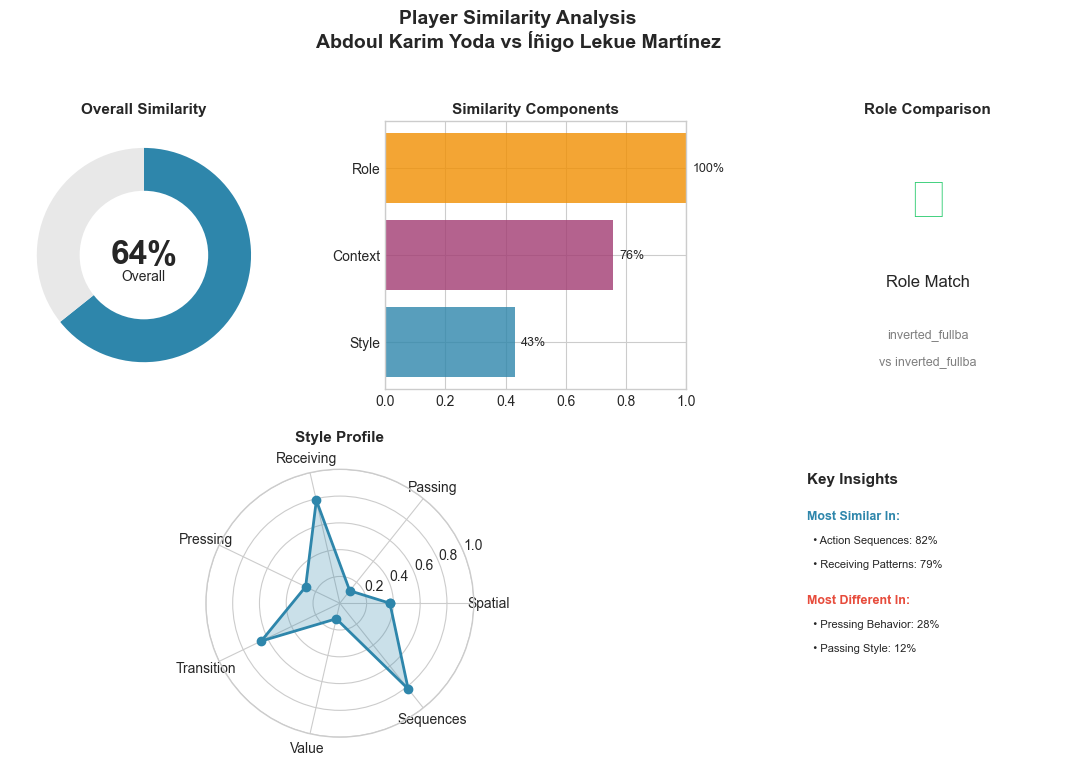

In [28]:
# ═══════════════════════════════════════════════════════════════════════════════
# TEST: COMPREHENSIVE SIMILARITY ANALYSIS WITH EXPLANATIONS
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("TESTING COMPREHENSIVE EXPLAINABLE SIMILARITY")
print("=" * 80)

# Get all players and pick two to compare
all_players = list(pipeline.player_profiles.keys())
print(f"\nTotal players available: {len(all_players)}")

# Pick first player
query_player = all_players[0]
print(f"\nQuery player: {query_player}")

# Find similar players with full explanation
print("\n" + "─" * 80)
print("Finding similar players with detailed explanations...")
print("─" * 80)

similar_players = explainable_analyzer.find_similar_with_explanation(
    query_player=query_player,
    top_n=5,
    min_style_similarity=0.0
)

# Show top 3 matches with summary
print(f"\nTop {len(similar_players)} most similar players to {query_player}:")
print()

for i, analysis in enumerate(similar_players[:3], 1):
    p2 = analysis['player2']
    overall = analysis.get('overall', 0)
    style = analysis.get('style_overall', 0)
    
    # Get top driver
    drivers = analysis.get('similarity_drivers', [])
    top_driver = drivers[0] if drivers else ('unknown', 0)
    driver_info = explainable_analyzer.feature_descriptions.get(top_driver[0], {})
    
    print(f"{i}. {p2}")
    print(f"   Overall: {overall:.1%} | Style: {style:.1%}")
    print(f"   Most similar in: {driver_info.get('name', top_driver[0])} ({top_driver[1]:.0%})")
    
    if analysis.get('role_similarity'):
        role_match = analysis['role_similarity']['same_role']
        print(f"   Role: {'✓ Same' if role_match else '✗ Different'} ({analysis['role_similarity']['player2_role']})")
    
    if analysis.get('context_similarity'):
        best_ctx = max(analysis['context_similarity'], key=analysis['context_similarity'].get)
        print(f"   Best context match: {best_ctx.replace('_', ' ').title()}")
    print()

# Detailed analysis of top match
if similar_players:
    print("\n" + "=" * 80)
    print("DETAILED ANALYSIS OF TOP MATCH")
    print("=" * 80)
    
    top_match = similar_players[0]
    explainable_analyzer.print_detailed_comparison(top_match)
    
    # Visualize
    print("\n📊 Generating visual breakdown...")
    plot_similarity_breakdown_comprehensive(top_match)


DRILLING DOWN: Which exact features drive the similarity?

════════════════════════════════════════════════════════════════════════════════
FEATURE CONTRIBUTION ANALYSIS
Abdoul Karim Yoda vs Íñigo Lekue Martínez
════════════════════════════════════════════════════════════════════════════════

✅ TOP 10 FEATURES MAKING THEM SIMILAR:
────────────────────────────────────────────────────────────
Block                Similarity   P1 Value     P2 Value    
────────────────────────────────────────────────────────────
Transition           [██████████] 100%   0.500   0.500
Receiving            [█████████░] 98%   0.840   0.855
Transition           [█████████░] 96%   0.042   0.040
Receiving            [█████████░] 93%   0.280   0.301
Receiving            [█████████░] 90%   0.160   0.145
Receiving            [████████░░] 89%   0.140   0.157
Receiving            [████████░░] 88%   0.211   0.239
Pressing             [████████░░] 83%   0.055   0.066
Pressing             [████████░░] 82%   0.462   0.5

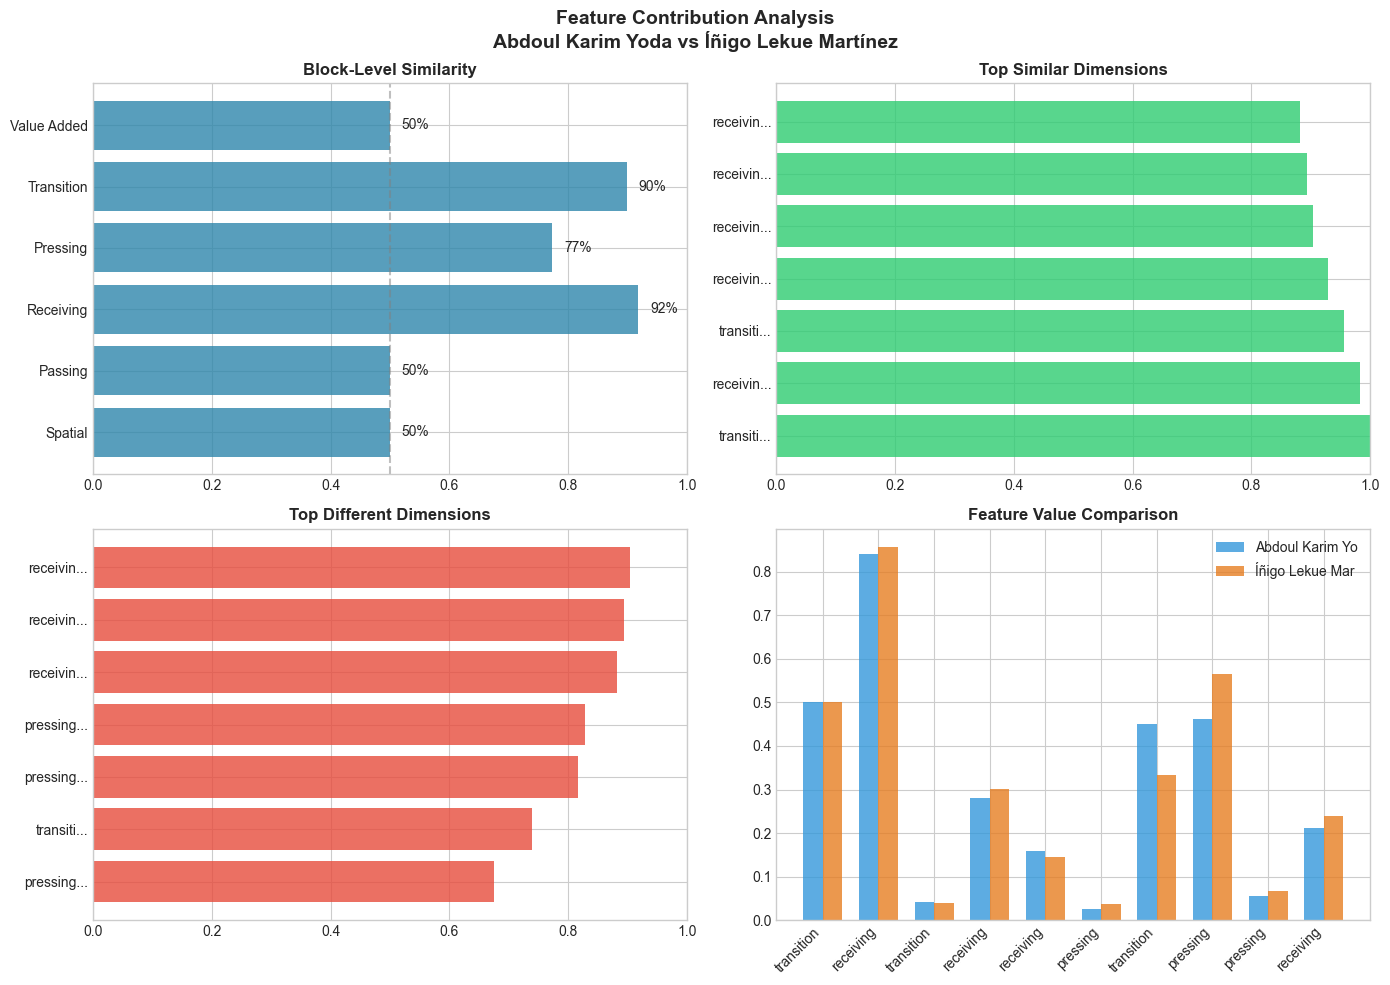

In [30]:
# ═══════════════════════════════════════════════════════════════════════════════
# FEATURE IMPORTANCE: DRILL-DOWN INTO SPECIFIC FEATURE CONTRIBUTIONS
# ═══════════════════════════════════════════════════════════════════════════════

class FeatureContributionAnalyzer:
    """
    Analyzes exactly WHICH features contribute to similarity between players.
    Goes beyond feature blocks to show individual feature contributions.
    """
    
    def __init__(self, pipeline, similarity_calc, config):
        self.pipeline = pipeline
        self.similarity_calc = similarity_calc
        self.config = config
        
        # Feature name mappings for interpretability
        self.feature_labels = {
            # Spatial features
            'zone_pct_': 'Pitch Zone Activity',
            'avg_x': 'Average Horizontal Position',
            'avg_y': 'Average Vertical Position',
            
            # Passing features
            'pass_length_': 'Pass Length Distribution',
            'pass_angle_': 'Pass Direction Preference',
            'pass_progressive': 'Progressive Passing',
            
            # Pressing features
            'press_': 'Pressing Location',
            'counterpress': 'Counter-Pressing Rate',
            
            # Receiving features
            'receive_': 'Ball Reception Location',
            'receive_under_pressure': 'Receiving Under Pressure',
            
            # xT/Value features
            'xt_': 'Expected Threat Contribution',
            
            # Action chains
            'chain_': 'Action Sequence Patterns'
        }
    
    def get_feature_contribution(self, player1: str, player2: str) -> Dict:
        """
        Get per-feature contribution to similarity.
        Returns dict with feature names and their similarity scores.
        """
        if player1 not in self.pipeline.player_profiles or player2 not in self.pipeline.player_profiles:
            return {}
        
        profile1 = self.pipeline.player_profiles[player1]
        profile2 = self.pipeline.player_profiles[player2]
        
        contributions = {}
        
        # For each feature block, get detailed contributions
        for block_name in ['spatial', 'passing', 'receiving', 'pressing', 'transition', 'value_added', 'action_chains']:
            if block_name in profile1 and block_name in profile2:
                vec1 = profile1[block_name]
                vec2 = profile2[block_name]
                
                # Handle different data types
                if isinstance(vec1, dict):
                    # If it's a dict, extract numeric values
                    all_keys = set(vec1.keys()) | set(vec2.keys())
                    dim_similarities = []
                    for key in all_keys:
                        v1 = vec1.get(key, 0)
                        v2 = vec2.get(key, 0)
                        # Skip non-numeric values
                        if not isinstance(v1, (int, float)) or not isinstance(v2, (int, float)):
                            continue
                        if v1 > 0.01 or v2 > 0.01:
                            ratio = min(v1, v2) / max(v1, v2) if max(v1, v2) > 0 else 1.0
                            dim_similarities.append((f"{block_name}_{key}", ratio, v1, v2))
                    
                elif isinstance(vec1, (list, np.ndarray)):
                    # If it's an array
                    vec1 = np.array(vec1).flatten()
                    vec2 = np.array(vec2).flatten()
                    
                    dim_similarities = []
                    for i, (v1, v2) in enumerate(zip(vec1, vec2)):
                        # Skip non-numeric
                        if not isinstance(v1, (int, float, np.number)) or not isinstance(v2, (int, float, np.number)):
                            continue
                        if v1 > 0.01 or v2 > 0.01:
                            ratio = min(v1, v2) / max(v1, v2) if max(v1, v2) > 0 else 1.0
                            dim_similarities.append((f"{block_name}_dim_{i}", ratio, float(v1), float(v2)))
                else:
                    # Single value
                    if isinstance(vec1, (int, float)) and isinstance(vec2, (int, float)):
                        ratio = min(vec1, vec2) / max(vec1, vec2) if max(vec1, vec2) > 0 else 1.0
                        dim_similarities = [(f"{block_name}", ratio, vec1, vec2)]
                    else:
                        dim_similarities = []
                
                contributions[block_name] = {
                    'dimensions': dim_similarities,
                    'overall': np.mean([d[1] for d in dim_similarities]) if dim_similarities else 0.5
                }
        
        return contributions
    
    def get_top_contributing_features(self, 
                                       player1: str, 
                                       player2: str, 
                                       top_n: int = 10) -> Tuple[List, List]:
        """
        Get top N features that make players SIMILAR and DIFFERENT.
        """
        contributions = self.get_feature_contribution(player1, player2)
        
        all_dims = []
        for block_name, block_data in contributions.items():
            for dim_name, sim, v1, v2 in block_data['dimensions']:
                all_dims.append({
                    'block': block_name,
                    'dimension': dim_name,
                    'similarity': sim,
                    'player1_value': v1,
                    'player2_value': v2
                })
        
        # Sort by similarity
        sorted_dims = sorted(all_dims, key=lambda x: x['similarity'], reverse=True)
        
        most_similar = sorted_dims[:top_n]
        most_different = sorted_dims[-top_n:][::-1]
        
        return most_similar, most_different
    
    def print_feature_breakdown(self, player1: str, player2: str):
        """
        Print detailed feature-by-feature breakdown.
        """
        similar, different = self.get_top_contributing_features(player1, player2, top_n=10)
        
        print(f"\n{'═' * 80}")
        print(f"FEATURE CONTRIBUTION ANALYSIS")
        print(f"{player1} vs {player2}")
        print(f"{'═' * 80}")
        
        print(f"\n✅ TOP 10 FEATURES MAKING THEM SIMILAR:")
        print(f"{'─' * 60}")
        print(f"{'Block':<20} {'Similarity':<12} {'P1 Value':<12} {'P2 Value':<12}")
        print(f"{'─' * 60}")
        
        for feat in similar:
            block = feat['block'].replace('_', ' ').title()
            sim = feat['similarity']
            bar = '█' * int(sim * 10) + '░' * (10 - int(sim * 10))
            print(f"{block:<20} [{bar}] {sim:.0%}   {feat['player1_value']:.3f}   {feat['player2_value']:.3f}")
        
        print(f"\n❌ TOP 10 FEATURES WHERE THEY DIFFER:")
        print(f"{'─' * 60}")
        print(f"{'Block':<20} {'Similarity':<12} {'P1 Value':<12} {'P2 Value':<12}")
        print(f"{'─' * 60}")
        
        for feat in different:
            block = feat['block'].replace('_', ' ').title()
            sim = feat['similarity']
            bar = '█' * int(sim * 10) + '░' * (10 - int(sim * 10))
            print(f"{block:<20} [{bar}] {sim:.0%}   {feat['player1_value']:.3f}   {feat['player2_value']:.3f}")
        
        print(f"\n{'═' * 80}")
    
    def plot_feature_importance(self, player1: str, player2: str, figsize=(14, 10)):
        """
        Visualize feature contributions.
        """
        contributions = self.get_feature_contribution(player1, player2)
        similar, different = self.get_top_contributing_features(player1, player2, top_n=7)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. Block-level similarity (top left)
        ax1 = axes[0, 0]
        blocks = list(contributions.keys())
        block_scores = [contributions[b]['overall'] for b in blocks]
        
        colors = ['#2E86AB' if s >= 0.5 else '#E94F37' for s in block_scores]
        y_pos = np.arange(len(blocks))
        
        bars = ax1.barh(y_pos, block_scores, color=colors, alpha=0.8)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels([b.replace('_', ' ').title() for b in blocks])
        ax1.set_xlim(0, 1)
        ax1.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
        ax1.set_title('Block-Level Similarity', fontweight='bold')
        
        for bar, score in zip(bars, block_scores):
            ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                    f'{score:.0%}', va='center')
        
        # 2. Top similar features (top right)
        ax2 = axes[0, 1]
        if similar:
            sim_labels = [f"{f['block'][:8]}..." for f in similar]
            sim_scores = [f['similarity'] for f in similar]
            
            y_pos = np.arange(len(sim_labels))
            ax2.barh(y_pos, sim_scores, color='#2ECC71', alpha=0.8)
            ax2.set_yticks(y_pos)
            ax2.set_yticklabels(sim_labels)
            ax2.set_xlim(0, 1)
        ax2.set_title('Top Similar Dimensions', fontweight='bold')
        
        # 3. Top different features (bottom left)
        ax3 = axes[1, 0]
        if different:
            diff_labels = [f"{f['block'][:8]}..." for f in different]
            diff_scores = [f['similarity'] for f in different]
            
            y_pos = np.arange(len(diff_labels))
            ax3.barh(y_pos, diff_scores, color='#E74C3C', alpha=0.8)
            ax3.set_yticks(y_pos)
            ax3.set_yticklabels(diff_labels)
            ax3.set_xlim(0, 1)
        ax3.set_title('Top Different Dimensions', fontweight='bold')
        
        # 4. Player comparison on key dimensions (bottom right)
        ax4 = axes[1, 1]
        
        if similar and different:
            # Get a sample of features to compare
            sample_features = similar[:5] + different[:5]
            feat_names = [f['block'][:10] for f in sample_features]
            p1_vals = [f['player1_value'] for f in sample_features]
            p2_vals = [f['player2_value'] for f in sample_features]
            
            x = np.arange(len(feat_names))
            width = 0.35
            
            ax4.bar(x - width/2, p1_vals, width, label=player1[:15], color='#3498DB', alpha=0.8)
            ax4.bar(x + width/2, p2_vals, width, label=player2[:15], color='#E67E22', alpha=0.8)
            ax4.set_xticks(x)
            ax4.set_xticklabels(feat_names, rotation=45, ha='right')
            ax4.legend()
        ax4.set_title('Feature Value Comparison', fontweight='bold')
        
        fig.suptitle(f'Feature Contribution Analysis\n{player1} vs {player2}', 
                    fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return fig

# Initialize
feature_analyzer = FeatureContributionAnalyzer(pipeline, similarity_calc, config)

# Test with the same players from the previous analysis
if similar_players:
    top_match = similar_players[0]
    p1, p2 = top_match['player1'], top_match['player2']
    
    print("\n" + "=" * 80)
    print("DRILLING DOWN: Which exact features drive the similarity?")
    print("=" * 80)
    
    # Print detailed breakdown
    feature_analyzer.print_feature_breakdown(p1, p2)
    
    # Visualize
    print("\n📊 Feature contribution visualization:")
    feature_analyzer.plot_feature_importance(p1, p2)

In [31]:
# ═══════════════════════════════════════════════════════════════════════════════
# UNIFIED EXPLAINABLE SIMILARITY API - COMPLETE SOLUTION
# ═══════════════════════════════════════════════════════════════════════════════

class UnifiedExplainableSimilarityAPI:
    """
    Complete API for explainable player similarity.
    
    Combines:
    - Style/Behavioral similarity (passing, spatial, pressing, etc.)
    - Context-aware similarity (score state, game phase)
    - Role matching
    - Feature-level breakdown showing WHAT makes players similar
    
    Usage:
        api = UnifiedExplainableSimilarityAPI(...)
        result = api.compare("Player A", "Player B")
        api.print_full_report(result)
        api.visualize(result)
    """
    
    def __init__(self, 
                 explainable_analyzer: ExplainableSimilarityAnalyzer,
                 feature_analyzer: FeatureContributionAnalyzer):
        self.explainable = explainable_analyzer
        self.features = feature_analyzer
    
    def compare(self, player1: str, player2: str) -> Dict:
        """
        Complete comparison between two players with full explanation.
        """
        # Get high-level analysis
        analysis = self.explainable.analyze_player_pair(player1, player2)
        
        # Add feature-level breakdown
        similar_feats, diff_feats = self.features.get_top_contributing_features(player1, player2, top_n=5)
        analysis['similar_features'] = similar_feats
        analysis['different_features'] = diff_feats
        
        # Get feature contributions
        analysis['feature_contributions'] = self.features.get_feature_contribution(player1, player2)
        
        return analysis
    
    def find_similar(self, 
                     player: str, 
                     top_n: int = 10,
                     explain: bool = True) -> List[Dict]:
        """
        Find similar players with explanations.
        """
        results = self.explainable.find_similar_with_explanation(player, top_n)
        
        if explain:
            for result in results:
                sim_feats, diff_feats = self.features.get_top_contributing_features(
                    player, result['player2'], top_n=3
                )
                result['top_similar_features'] = sim_feats
                result['top_different_features'] = diff_feats
        
        return results
    
    def print_full_report(self, analysis: Dict):
        """
        Print comprehensive similarity report.
        """
        p1, p2 = analysis['player1'], analysis['player2']
        
        print("\n" + "═" * 90)
        print("COMPREHENSIVE PLAYER SIMILARITY REPORT")
        print("═" * 90)
        print(f"\n🔍 Comparing: {p1}")
        print(f"         to: {p2}")
        
        # Summary
        overall = analysis.get('overall', 0)
        interp = self.explainable.interpret_similarity_score(overall)
        print(f"\n📊 OVERALL SIMILARITY: {overall:.1%} ({interp})")
        
        # Component breakdown
        print(f"\n{'─' * 90}")
        print("SIMILARITY COMPONENTS (weighted contribution to overall)")
        print(f"{'─' * 90}")
        
        components = [
            ("🎨 Playing Style", analysis.get('style_overall', 0), "50%"),
            ("🌍 Context Adaptation", np.mean(list(analysis.get('context_similarity', {}).values())) if analysis.get('context_similarity') else 0, "30%"),
            ("🎯 Role Match", analysis.get('role_similarity', {}).get('role_score', 0), "20%")
        ]
        
        for name, score, weight in components:
            bar = '█' * int(score * 10) + '░' * (10 - int(score * 10))
            print(f"   {name:<25} [{bar}] {score:.0%} (weight: {weight})")
        
        # Style breakdown
        print(f"\n{'─' * 90}")
        print("🎨 PLAYING STYLE BREAKDOWN")
        print(f"{'─' * 90}")
        
        if analysis.get('style_similarity'):
            style = analysis['style_similarity']
            style_features = ['spatial', 'passing', 'receiving', 'pressing', 'transition', 'value_added', 'action_chains']
            
            for feat in style_features:
                if feat in style:
                    score = style[feat]
                    bar = '█' * int(score * 10) + '░' * (10 - int(score * 10))
                    info = self.explainable.feature_descriptions.get(feat, {})
                    name = info.get('name', feat)
                    desc = info.get('description', '')
                    print(f"   {name:<22} [{bar}] {score:.0%}  │ {desc}")
        
        # What makes them similar
        print(f"\n{'─' * 90}")
        print("✅ WHY THEY ARE SIMILAR")
        print(f"{'─' * 90}")
        
        if analysis.get('similar_features'):
            for i, feat in enumerate(analysis['similar_features'][:5], 1):
                block_name = feat['block'].replace('_', ' ').title()
                print(f"   {i}. {block_name}: {feat['similarity']:.0%} similarity")
                print(f"      Player 1: {feat['player1_value']:.3f} | Player 2: {feat['player2_value']:.3f}")
        
        # What makes them different
        print(f"\n{'─' * 90}")
        print("❌ WHERE THEY DIFFER")
        print(f"{'─' * 90}")
        
        if analysis.get('different_features'):
            for i, feat in enumerate(analysis['different_features'][:5], 1):
                block_name = feat['block'].replace('_', ' ').title()
                print(f"   {i}. {block_name}: {feat['similarity']:.0%} similarity")
                print(f"      Player 1: {feat['player1_value']:.3f} | Player 2: {feat['player2_value']:.3f}")
        
        # Context patterns
        print(f"\n{'─' * 90}")
        print("🌍 CONTEXT-DEPENDENT SIMILARITY")
        print(f"{'─' * 90}")
        
        if analysis.get('context_similarity'):
            ctx = analysis['context_similarity']
            for ctx_name, score in sorted(ctx.items(), key=lambda x: -x[1]):
                bar = '█' * int(score * 10) + '░' * (10 - int(score * 10))
                print(f"   {ctx_name.replace('_', ' ').title():<25} [{bar}] {score:.0%}")
        
        # Role comparison
        print(f"\n{'─' * 90}")
        print("🎯 ROLE COMPARISON")
        print(f"{'─' * 90}")
        
        if analysis.get('role_similarity'):
            role = analysis['role_similarity']
            print(f"   {p1}: {role.get('player1_role', 'Unknown')}")
            print(f"   {p2}: {role.get('player2_role', 'Unknown')}")
            if role.get('same_role'):
                print(f"   ✓ Same tactical role - similar positional responsibilities")
            else:
                print(f"   ✗ Different roles - may play different functions")
        
        # Summary interpretation
        print(f"\n{'─' * 90}")
        print("💡 INTERPRETATION")
        print(f"{'─' * 90}")
        
        explanation = analysis.get('explanation', {})
        if explanation.get('summary'):
            print(f"\n   {explanation['summary']}")
        if explanation.get('style_explanation'):
            print(f"   {explanation['style_explanation']}")
        if explanation.get('context_explanation'):
            print(f"   {explanation['context_explanation']}")
        
        print("\n" + "═" * 90)
    
    def visualize(self, analysis: Dict, figsize=(16, 12)):
        """
        Create comprehensive visualization.
        """
        # Use the comprehensive plot
        plot_similarity_breakdown_comprehensive(analysis)
        
        # And the feature importance plot
        if analysis.get('similar_features'):
            self.features.plot_feature_importance(
                analysis['player1'], 
                analysis['player2']
            )

# Initialize the unified API
unified_api = UnifiedExplainableSimilarityAPI(
    explainable_analyzer=explainable_analyzer,
    feature_analyzer=feature_analyzer
)

print("=" * 90)
print("UNIFIED EXPLAINABLE SIMILARITY API READY")
print("=" * 90)
print("\nUsage Examples:")
print()
print("  # Compare two specific players")
print("  result = unified_api.compare('Player A', 'Player B')")
print("  unified_api.print_full_report(result)")
print("  unified_api.visualize(result)")
print()
print("  # Find similar players with explanations")
print("  similar = unified_api.find_similar('Player A', top_n=10)")
print("  for match in similar:")
print("      print(match['player2'], match['overall'])")
print()
print("=" * 90)

UNIFIED EXPLAINABLE SIMILARITY API READY

Usage Examples:

  # Compare two specific players
  result = unified_api.compare('Player A', 'Player B')
  unified_api.print_full_report(result)
  unified_api.visualize(result)

  # Find similar players with explanations
  similar = unified_api.find_similar('Player A', top_n=10)
  for match in similar:
      print(match['player2'], match['overall'])



Total players in dataset: 347

🔍 Analyzing: Abdoul Karim Yoda vs Adrián Embarba Blázquez
────────────────────────────────────────────────────────────

══════════════════════════════════════════════════════════════════════════════════════════
COMPREHENSIVE PLAYER SIMILARITY REPORT
══════════════════════════════════════════════════════════════════════════════════════════

🔍 Comparing: Abdoul Karim Yoda
         to: Adrián Embarba Blázquez

📊 OVERALL SIMILARITY: 58.0% (Moderate - Some common patterns)

──────────────────────────────────────────────────────────────────────────────────────────
SIMILARITY COMPONENTS (weighted contribution to overall)
──────────────────────────────────────────────────────────────────────────────────────────
   🎨 Playing Style           [████░░░░░░] 41% (weight: 50%)
   🌍 Context Adaptation      [█████░░░░░] 58% (weight: 30%)
   🎯 Role Match              [██████████] 100% (weight: 20%)

──────────────────────────────────────────────────────────────────────────

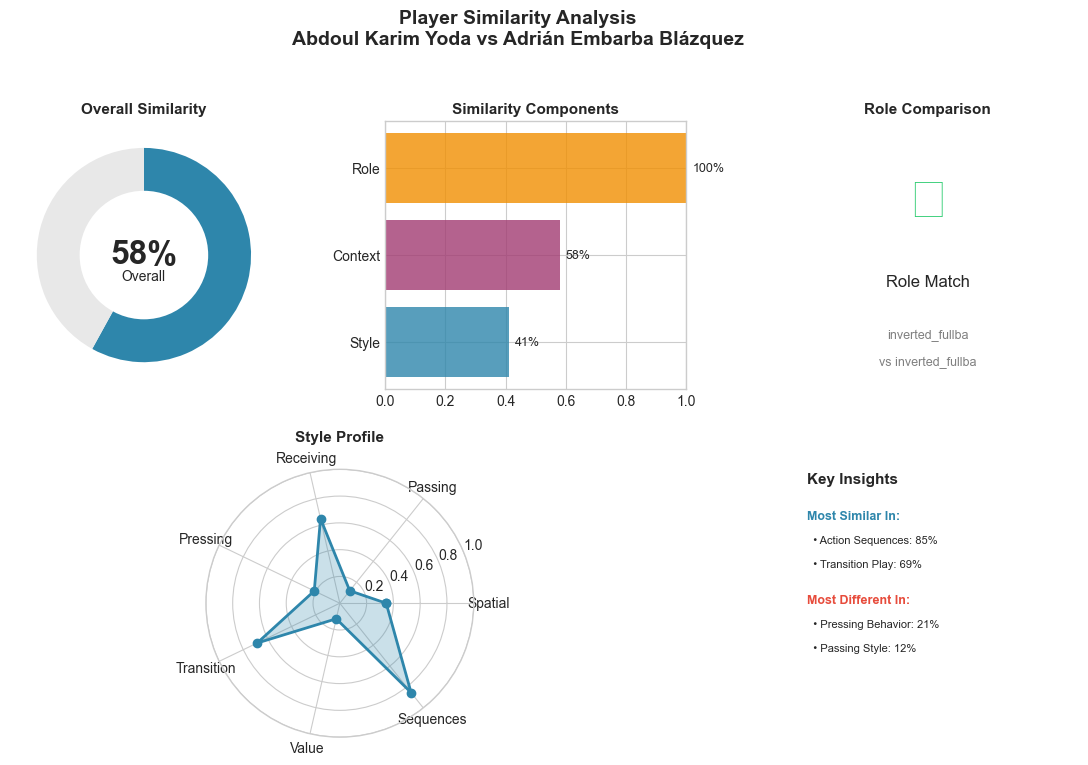

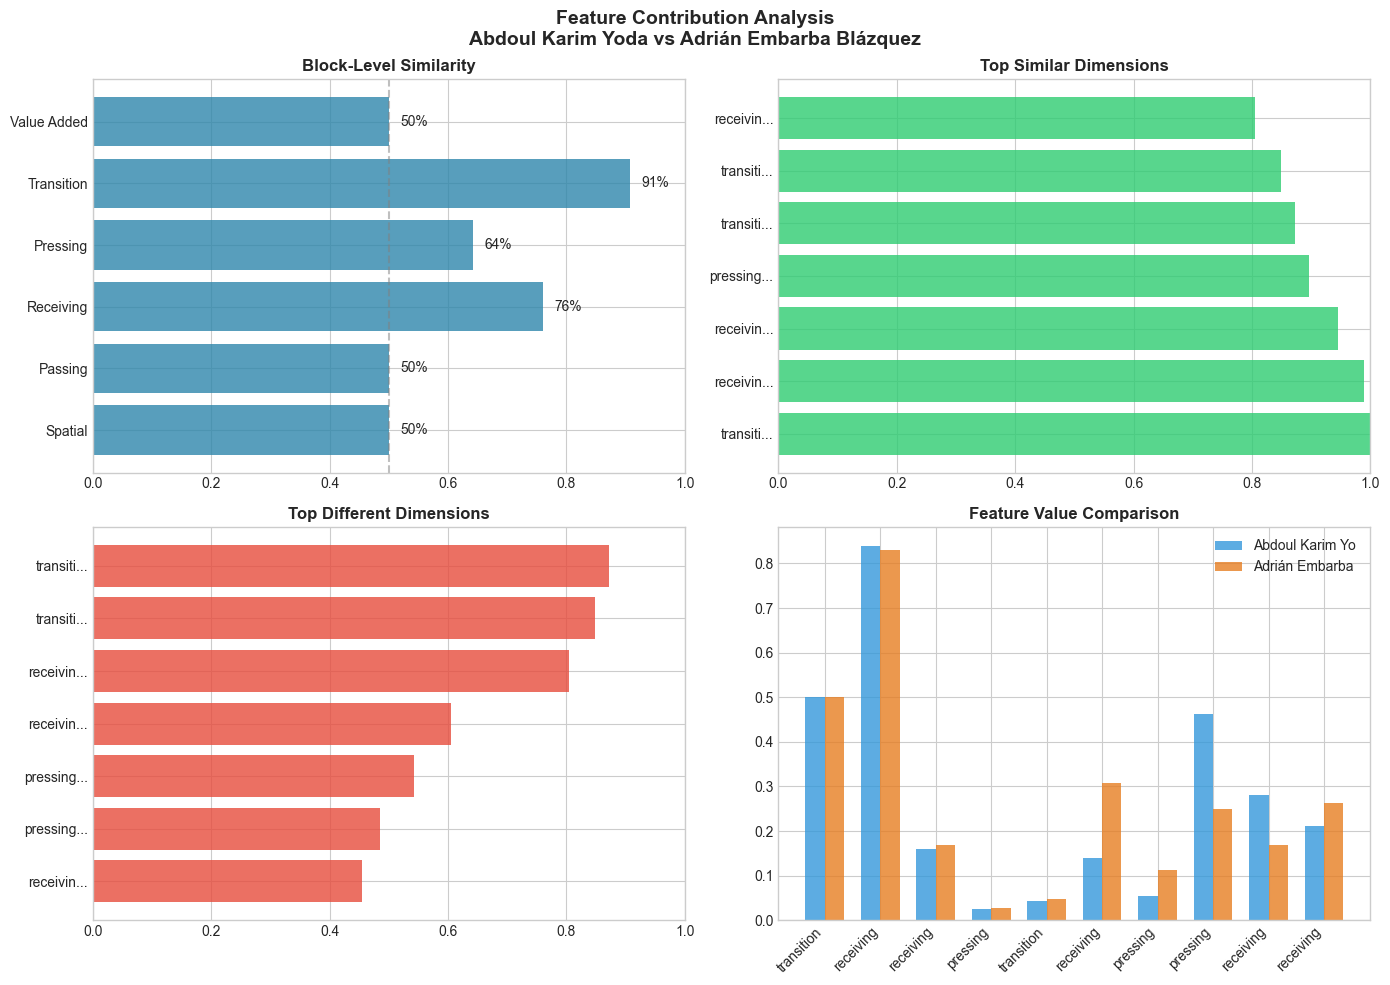

In [32]:
# ═══════════════════════════════════════════════════════════════════════════════
# DEMO: FULL EXPLAINABLE COMPARISON
# ═══════════════════════════════════════════════════════════════════════════════

# Get available players
all_players = list(pipeline.player_profiles.keys())
print(f"Total players in dataset: {len(all_players)}")

# Pick two players to compare
player1 = all_players[0]
player2 = all_players[5] if len(all_players) > 5 else all_players[1]

print(f"\n🔍 Analyzing: {player1} vs {player2}")
print("─" * 60)

# Run full comparison
comparison = unified_api.compare(player1, player2)

# Print comprehensive report
unified_api.print_full_report(comparison)

# Visualize
print("\n📊 Generating visualizations...")
unified_api.visualize(comparison)